# 연합학습 - NIH Chest X-ray
필요한 라이브러리 임포트

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.models import *
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub
from google.colab import drive
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

드라이브 마운팅

In [2]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


디렉터리 지정

In [3]:
# Set up directories
DRIVE_PATH = '/content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)'
MODEL_SAVE_PATH = f'{DRIVE_PATH}/client_models'
DATA_PATH = f'{DRIVE_PATH}/data'

디렉터리 만들기 및 데이터 다운로드

In [ ]:
# Download NIH Chest X-rays dataset and set up paths
print("Downloading NIH Chest X-rays dataset...")
try:
    # Download dataset
    download_path = kagglehub.dataset_download("nih-chest-xrays/data")
    print(f"Dataset downloaded to: {download_path}")

    # Copy dataset to Google Drive
    print(f"Copying dataset to Google Drive: {DATA_PATH}")
    import shutil

    dataset_target = f"{DATA_PATH}/nih_dataset"

    if not os.path.exists(dataset_target):
        print("Copying dataset files...")
        os.makedirs(dataset_target, exist_ok=True)

        # Copy all contents
        for item in os.listdir(download_path):
            source = os.path.join(download_path, item)
            destination = os.path.join(dataset_target, item)

            if os.path.isdir(source):
                print(f"Copying directory: {item}")
                shutil.copytree(source, destination)
            else:
                print(f"Copying file: {item}")
                shutil.copy2(source, destination)

        print("Dataset copied successfully!")
    else:
        print("Dataset already exists in Google Drive")

    # Set path to use Google Drive location
    path = dataset_target
    print(f"Using dataset from: {path}")

except Exception as e:
    print(f"Error downloading dataset: {e}")
    path = f"{DATA_PATH}/nih_dataset"  # Fallback to existing location

# Main training function - path setup only
def setup_data_paths():
    """Set up correct CSV and image paths"""
    dataset_path = f"{DATA_PATH}/nih_dataset"

    # Find CSV file
    csv_path = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv'):
                csv_path = os.path.join(root, file)
                print(f"Found CSV file: {csv_path}")
                break
        if csv_path:
            break

    # Find image directory
    img_dir = None
    for root, dirs, files in os.walk(dataset_path):
        # Look for directory with many image files
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > 100:
            img_dir = root
            print(f"Found image directory: {img_dir} ({len(image_files)} images)")
            break

    # Alternative: look for 'images' directory
    if img_dir is None:
        for root, dirs, files in os.walk(dataset_path):
            for dir_name in dirs:
                if 'image' in dir_name.lower():
                    potential_dir = os.path.join(root, dir_name)
                    try:
                        contents = os.listdir(potential_dir)
                        img_files = [f for f in contents if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        if len(img_files) > 100:
                            img_dir = potential_dir
                            print(f"Found image directory: {img_dir}")
                            break
                    except:
                        continue
            if img_dir:
                break

    return csv_path, img_dir

Dataset downloaded to: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3
Copying dataset to Google Drive: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data
Copying dataset files...
Copying file: BBox_List_2017.csv
Copying directory: images_008
Copying directory: images_006
Copying directory: images_009
Copying file: train_val_list.txt
Copying file: README_CHESTXRAY.pdf
Copying directory: images_001
Copying file: LOG_CHESTXRAY.pdf
Copying file: Data_Entry_2017.csv
Copying file: test_list.txt
Copying directory: images_011
Copying directory: images_002
Copying directory: images_007
Copying file: ARXIV_V5_CHESTXRAY.pdf
Copying directory: images_004
Copying directory: images_010
Copying file: FAQ_CHESTXRAY.pdf
Copying directory: images_012
Copying directory: images_005
Copying directory: images_003
Dataset copied successfully!
Using dataset from: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)

디바이스 정하기

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


라벨 정하기

In [4]:
NIH_LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
NUM_CLASSES = len(NIH_LABELS)

모델 학습

In [11]:
# Setup data paths function
def setup_data_paths():
    """Set up correct CSV and image paths"""
    dataset_path = f"{DATA_PATH}/nih_dataset"

    # Find CSV file - specifically look for Data_Entry file
    csv_path = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv') and ('Data_Entry' in file or 'data_entry' in file.lower()):
                csv_path = os.path.join(root, file)
                print(f"Found Data Entry CSV file: {csv_path}")
                break
        if csv_path:
            break

    # If Data_Entry not found, show all CSV files
    if csv_path is None:
        print("Data_Entry CSV not found. Available CSV files:")
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.csv'):
                    print(f"  - {os.path.join(root, file)}")

        # Look for any CSV with 'Finding Labels' column
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.csv'):
                    try:
                        test_path = os.path.join(root, file)
                        test_df = pd.read_csv(test_path, nrows=1)
                        if 'Finding Labels' in test_df.columns:
                            csv_path = test_path
                            print(f"Found CSV with 'Finding Labels' column: {csv_path}")
                            break
                    except:
                        continue
            if csv_path:
                break

    # Find image directory
    img_dir = None
    for root, dirs, files in os.walk(dataset_path):
        # Look for directory with many image files
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > 100:
            img_dir = root
            print(f"Found image directory: {img_dir} ({len(image_files)} images)")
            break

    # Alternative: look for 'images' directory
    if img_dir is None:
        for root, dirs, files in os.walk(dataset_path):
            for dir_name in dirs:
                if 'image' in dir_name.lower():
                    potential_dir = os.path.join(root, dir_name)
                    try:
                        contents = os.listdir(potential_dir)
                        img_files = [f for f in contents if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                        if len(img_files) > 100:
                            img_dir = potential_dir
                            print(f"Found image directory: {img_dir}")
                            break
                    except:
                        continue
            if img_dir:
                break

    return csv_path, img_dir

# Custom Dataset for NIH Chest X-rays
class NIHDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Process labels (multi-label)
        self.data['Finding Labels'] = self.data['Finding Labels'].fillna('No Finding')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image Index']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # If image can't be loaded, return a black image
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        # Multi-label encoding
        labels = self.data.iloc[idx]['Finding Labels']
        label_vector = torch.zeros(NUM_CLASSES)

        if labels != 'No Finding':
            for label in labels.split('|'):
                if label.strip() in NIH_LABELS:
                    label_idx = NIH_LABELS.index(label.strip())
                    label_vector[label_idx] = 1.0

        return image, label_vector

# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Model definitions - All 50 models
def get_model(model_id, num_classes=NUM_CLASSES):
    """Returns one of 50 different model architectures"""

    if model_id == 0:
        # ResNet18
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 1:
        # ResNet34
        model = resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 2:
        # ResNet50
        model = resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 3:
        # ResNet101
        model = resnet101(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 4:
        # ResNet152
        model = resnet152(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 5:
        # DenseNet121
        model = densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 6:
        # DenseNet161
        model = densenet161(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 7:
        # DenseNet169
        model = densenet169(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 8:
        # DenseNet201
        model = densenet201(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 9:
        # VGG11
        model = vgg11(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 10:
        # VGG13
        model = vgg13(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 11:
        # VGG16
        model = vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 12:
        # VGG19
        model = vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 13:
        # EfficientNet-B0
        model = efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 14:
        # EfficientNet-B1
        model = efficientnet_b1(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 15:
        # EfficientNet-B2
        model = efficientnet_b2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 16:
        # EfficientNet-B3
        model = efficientnet_b3(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 17:
        # EfficientNet-B4
        model = efficientnet_b4(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 18:
        # MobileNet-V2
        model = mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 19:
        # MobileNet-V3 Large
        model = mobilenet_v3_large(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 20:
        # MobileNet-V3 Small
        model = mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 21:
        # SqueezeNet 1.0
        model = squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 22:
        # SqueezeNet 1.1
        model = squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 23:
        # ShuffleNet V2 x0.5
        model = shufflenet_v2_x0_5(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 24:
        # ShuffleNet V2 x1.0
        model = shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 25:
        # Wide ResNet-50-2
        model = wide_resnet50_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 26:
        # Wide ResNet-101-2
        model = wide_resnet101_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 27:
        # ResNext-50-32x4d
        model = resnext50_32x4d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 28:
        # ResNext-101-32x8d
        model = resnext101_32x8d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 29:
        # RegNet Y-400MF
        model = regnet_y_400mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 30:
        # RegNet Y-800MF
        model = regnet_y_800mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 31:
        # RegNet Y-1.6GF
        model = regnet_y_1_6gf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 32:
        # VGG11 with Batch Normalization
        model = vgg11_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 33:
        # VGG13 with Batch Normalization
        model = vgg13_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 34:
        # VGG16 with Batch Normalization
        model = vgg16_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 35:
        # VGG19 with Batch Normalization
        model = vgg19_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 36:
        # AlexNet
        model = alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 37:
        # Custom CNN 1
        class CustomCNN1(nn.Module):
            def __init__(self, num_classes):
                super(CustomCNN1, self).__init__()
                self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
                self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
                self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
                self.pool = nn.MaxPool2d(2, 2)
                self.dropout = nn.Dropout(0.5)
                self.fc1 = nn.Linear(128 * 28 * 28, 512)
                self.fc2 = nn.Linear(512, num_classes)

            def forward(self, x):
                x = self.pool(torch.relu(self.conv1(x)))
                x = self.pool(torch.relu(self.conv2(x)))
                x = self.pool(torch.relu(self.conv3(x)))
                x = x.view(-1, 128 * 28 * 28)
                x = self.dropout(torch.relu(self.fc1(x)))
                x = self.fc2(x)
                return x
        return CustomCNN1(num_classes)
    elif model_id == 38:
        # Custom CNN 2
        class CustomCNN2(nn.Module):
            def __init__(self, num_classes):
                super(CustomCNN2, self).__init__()
                self.features = nn.Sequential(
                    nn.Conv2d(3, 64, 7, stride=2, padding=3),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(3, stride=2, padding=1),
                    nn.Conv2d(64, 128, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 256, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.AdaptiveAvgPool2d((7, 7))
                )
                self.classifier = nn.Sequential(
                    nn.Linear(256 * 7 * 7, 1024),
                    nn.ReLU(inplace=True),
                    nn.Dropout(),
                    nn.Linear(1024, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(),
                    nn.Linear(512, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = torch.flatten(x, 1)
                x = self.classifier(x)
                return x
        return CustomCNN2(num_classes)
    elif model_id == 39:
        # Custom ResNet variant
        class CustomResNet(nn.Module):
            def __init__(self, num_classes):
                super(CustomResNet, self).__init__()
                self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
                self.bn1 = nn.BatchNorm2d(64)
                self.relu = nn.ReLU(inplace=True)
                self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

                self.layer1 = self._make_layer(64, 64, 2)
                self.layer2 = self._make_layer(64, 128, 2, stride=2)
                self.layer3 = self._make_layer(128, 256, 2, stride=2)
                self.layer4 = self._make_layer(256, 512, 2, stride=2)

                self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
                self.fc = nn.Linear(512, num_classes)

            def _make_layer(self, in_planes, planes, blocks, stride=1):
                layers = []
                layers.append(nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1))
                layers.append(nn.BatchNorm2d(planes))
                layers.append(nn.ReLU(inplace=True))

                for _ in range(1, blocks):
                    layers.append(nn.Conv2d(planes, planes, 3, padding=1))
                    layers.append(nn.BatchNorm2d(planes))
                    layers.append(nn.ReLU(inplace=True))

                return nn.Sequential(*layers)

            def forward(self, x):
                x = self.conv1(x)
                x = self.bn1(x)
                x = self.relu(x)
                x = self.maxpool(x)

                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)

                x = self.avgpool(x)
                x = torch.flatten(x, 1)
                x = self.fc(x)
                return x
        return CustomResNet(num_classes)

    # Custom variants for remaining models (40-49)
    elif model_id >= 40:
        custom_id = model_id - 40

        class CustomVariant(nn.Module):
            def __init__(self, num_classes, variant_id):
                super(CustomVariant, self).__init__()
                base_channels = 32 + (variant_id * 8)

                self.features = nn.Sequential(
                    nn.Conv2d(3, base_channels, 3, padding=1),
                    nn.BatchNorm2d(base_channels),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
                    nn.BatchNorm2d(base_channels*2),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
                    nn.BatchNorm2d(base_channels*4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels*4, base_channels*8, 3, padding=1),
                    nn.BatchNorm2d(base_channels*8),
                    nn.ReLU(inplace=True),
                    nn.AdaptiveAvgPool2d((4, 4))
                )

                self.classifier = nn.Sequential(
                    nn.Linear(base_channels*8*16, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(512, 256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(256, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = torch.flatten(x, 1)
                x = self.classifier(x)
                return x

        return CustomVariant(num_classes, custom_id)

def get_model_name(model_id):
    """Returns model name for given ID"""
    model_names = [
        "ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152",
        "DenseNet121", "DenseNet161", "DenseNet169", "DenseNet201",
        "VGG11", "VGG13", "VGG16", "VGG19",
        "EfficientNet-B0", "EfficientNet-B1", "EfficientNet-B2", "EfficientNet-B3", "EfficientNet-B4",
        "MobileNet-V2", "MobileNet-V3-Large", "MobileNet-V3-Small",
        "SqueezeNet1.0", "SqueezeNet1.1",
        "ShuffleNet-V2-x0.5", "ShuffleNet-V2-x1.0",
        "WideResNet50-2", "WideResNet101-2",
        "ResNext50-32x4d", "ResNext101-32x8d",
        "RegNet-Y-400MF", "RegNet-Y-800MF", "RegNet-Y-1.6GF",
        "VGG11-BN", "VGG13-BN", "VGG16-BN", "VGG19-BN",
        "AlexNet", "CustomCNN1", "CustomCNN2", "CustomResNet"
    ]

    if model_id < len(model_names):
        return model_names[model_id]
    else:
        return f"CustomVariant{model_id-40}"

# Hamming Accuracy 사용으로 변경
def calculate_multilabel_accuracy(outputs, targets, threshold=0.5):
    with torch.no_grad():
        predictions = torch.sigmoid(outputs) > threshold
        predictions = predictions.float()

        # Hamming accuracy만 반환 (더 현실적)
        hamming_accuracy = (predictions == targets).float().mean().item()

        return hamming_accuracy, hamming_accuracy  # 일관성을 위해 두 번 반환

# 기존 train_client_model 함수를 이것으로 교체
def train_client_model(client_id, model, train_loader, val_loader, epochs=10, lr=0.001):
    """Train a single client model with accuracy calculation"""
    print(f"\n=== Training Client {client_id} ({get_model_name(client_id)}) ===")

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()  # Multi-label classification
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_loss = float('inf')
    best_val_accuracy = 0.0  # 추가: 최고 정확도 추적
    train_losses = []
    val_losses = []
    train_accuracies = []  # 추가: 학습 정확도 저장
    val_accuracies = []    # 추가: 검증 정확도 저장

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_predictions = []  # 추가: 학습 예측값 저장
        train_targets = []      # 추가: 학습 실제값 저장

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 정확도 계산을 위한 예측값 저장
            train_predictions.append(outputs.detach())
            train_targets.append(labels.detach())

            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

            # Memory management for large datasets
            if batch_idx % 100 == 0:
                torch.cuda.empty_cache()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 학습 정확도 계산
        all_train_predictions = torch.cat(train_predictions, dim=0)
        all_train_targets = torch.cat(train_targets, dim=0)
        train_exact_acc, train_hamming_acc = calculate_multilabel_accuracy(all_train_predictions, all_train_targets)
        train_accuracies.append(train_exact_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []    # 추가: 검증 예측값 저장
        val_targets = []        # 추가: 검증 실제값 저장

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # 정확도 계산을 위한 예측값 저장
                val_predictions.append(outputs)
                val_targets.append(labels)

                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 검증 정확도 계산
        all_val_predictions = torch.cat(val_predictions, dim=0)
        all_val_targets = torch.cat(val_targets, dim=0)
        val_exact_acc, val_hamming_acc = calculate_multilabel_accuracy(all_val_predictions, all_val_targets)
        val_accuracies.append(val_exact_acc)

        # 출력에 정확도 추가
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_exact_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_exact_acc:.4f}")

        # Save best model (정확도 기준으로 변경)
        if val_exact_acc > best_val_accuracy:
            best_val_accuracy = val_exact_acc
            best_val_loss = avg_val_loss
            model_save_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{get_model_name(client_id)}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_accuracy': train_exact_acc,     # 추가
                'val_accuracy': val_exact_acc,         # 추가
                'model_id': client_id,
                'model_name': get_model_name(client_id)
            }, model_save_path)
            print(f"Best model saved: {model_save_path} (Val Acc: {best_val_accuracy:.4f})")

        scheduler.step()
        torch.cuda.empty_cache()

    # 최종 결과 출력
    print(f"Client {client_id} training completed!")
    print(f"Final Results - Best Val Accuracy: {best_val_accuracy:.4f}, Best Val Loss: {best_val_loss:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_accuracy


# Data loading and preparation
def prepare_federated_data(csv_path, img_dir, num_clients=50, batch_size=32):
    """Prepare data for federated learning"""
    print("Preparing federated data...")

    # Create full dataset
    full_dataset = NIHDataset(csv_path, img_dir, transform_train)

    # Split dataset among clients (IID distribution for simplicity)
    total_size = len(full_dataset)
    client_size = total_size // num_clients

    client_datasets = []
    remaining_size = total_size

    for i in range(num_clients):
        if i == num_clients - 1:  # Last client gets remaining data
            size = remaining_size
        else:
            size = client_size

        client_data, full_dataset = random_split(full_dataset, [size, len(full_dataset) - size])
        client_datasets.append(client_data)
        remaining_size -= size

    print(f"Data split into {num_clients} clients, each with ~{client_size} samples")
    return client_datasets

# Main training function
def main_training_with_results(num_clients=50, epochs=10, batch_size=16):
    """Main function to train all client models and collect results"""

    # Setup paths
    csv_path, img_dir = setup_data_paths()

    # Validate paths
    if csv_path is None or not os.path.exists(csv_path):
        print("❌ CSV file not found!")
        return

    if img_dir is None or not os.path.exists(img_dir):
        print("❌ Image directory not found!")
        return

    print(f"✅ Using CSV: {csv_path}")
    print(f"✅ Using images: {img_dir}")

    # Prepare federated data
    client_datasets = prepare_federated_data(csv_path, img_dir, num_clients, batch_size)

    # 결과 저장용 리스트
    all_results = []

    # Train each client model
    for client_id in range(num_clients):
        print(f"\n{'='*60}")
        print(f"Starting training for Client {client_id}")
        print(f"{'='*60}")

        try:
            # Create data loaders for this client
            train_size = int(0.8 * len(client_datasets[client_id]))
            val_size = len(client_datasets[client_id]) - train_size

            train_data, val_data = random_split(client_datasets[client_id], [train_size, val_size])

            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

            print(f"Client {client_id} - Train samples: {len(train_data)}, Val samples: {len(val_data)}")

            # Create and train model
            model = get_model(client_id)
            train_losses, val_losses, train_accs, val_accs, best_acc = train_client_model(
                client_id, model, train_loader, val_loader, epochs, lr=0.001
            )

            # 결과 저장
            all_results.append({
                'client_id': client_id,
                'model_name': get_model_name(client_id),
                'best_val_accuracy': best_acc,
                'final_train_loss': train_losses[-1],
                'final_val_loss': val_losses[-1],
                'final_train_acc': train_accs[-1],
                'final_val_acc': val_accs[-1]
            })

            print(f"Client {client_id} completed! Best Accuracy: {best_acc:.4f}")

            # Clear memory
            del model, train_loader, val_loader, train_data, val_data
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"Error training client {client_id}: {str(e)}")
            continue

    # 결과 요약 출력
    print("\n" + "="*80)
    print("TRAINING RESULTS SUMMARY")
    print("="*80)
    print(f"{'Client':<8} {'Model':<20} {'Best Val Acc':<12} {'Final Train Acc':<15} {'Final Val Acc':<13}")
    print("-"*80)

    for result in all_results:
        print(f"{result['client_id']:<8} {result['model_name']:<20} {result['best_val_accuracy']:<12.4f} "
              f"{result['final_train_acc']:<15.4f} {result['final_val_acc']:<13.4f}")

    # 통계 계산
    if all_results:
        accuracies = [r['best_val_accuracy'] for r in all_results]
        print("-"*80)
        print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
        print(f"Max Accuracy: {np.max(accuracies):.4f}")
        print(f"Min Accuracy: {np.min(accuracies):.4f}")
        print(f"Total Models: {len(all_results)}")

    print("\n" + "="*60)
    print("All client models training completed!")
    print(f"Models saved in: {MODEL_SAVE_PATH}")
    print("="*60)

    return all_results

# Run the training
if __name__ == "__main__":
    print("Starting Federated Learning Client Training...")
    print(f"Using {NUM_CLASSES} classes: {NIH_LABELS}")

    # 결과와 함께 학습 실행
    results = main_training_with_results(num_clients=50, epochs=10, batch_size=64)

    print("\nTraining completed! Check your Google Drive for saved models.")

Starting Federated Learning Client Training...
Using 14 classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
Found Data Entry CSV file: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data/nih_dataset/Data_Entry_2017.csv
Found image directory: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data/nih_dataset/images_001/images (4999 images)
✅ Using CSV: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data/nih_dataset/Data_Entry_2017.csv
✅ Using images: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data/nih_dataset/images_001/images
Preparing federated data...
Data split into 50 clients, each with ~2242 samples

Starting training for Client 0
Client 0 - Train samples: 1793, Val samp

Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s, Loss=2.4209]


Epoch 1/10 - Train Loss: 0.2269, Train Acc: 0.9300, Val Loss: 0.6483, Val Acc: 0.9486
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_0_ResNet18.pth (Val Acc: 0.9486)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=0.4345]


Epoch 2/10 - Train Loss: 0.1901, Train Acc: 0.9457, Val Loss: 0.2161, Val Acc: 0.9486


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.39it/s, Loss=1.9558]


Epoch 3/10 - Train Loss: 0.2152, Train Acc: 0.9447, Val Loss: 0.4225, Val Acc: 0.9486


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.5920]


Epoch 4/10 - Train Loss: 0.1897, Train Acc: 0.9459, Val Loss: 0.2374, Val Acc: 0.9486


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s, Loss=0.4096]


Epoch 5/10 - Train Loss: 0.1896, Train Acc: 0.9459, Val Loss: 0.2140, Val Acc: 0.9486


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.4158]


Epoch 6/10 - Train Loss: 0.1883, Train Acc: 0.9458, Val Loss: 0.2147, Val Acc: 0.9486


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s, Loss=0.4421]


Epoch 7/10 - Train Loss: 0.1850, Train Acc: 0.9459, Val Loss: 0.2188, Val Acc: 0.9486


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s, Loss=0.4192]


Epoch 8/10 - Train Loss: 0.1841, Train Acc: 0.9459, Val Loss: 0.2150, Val Acc: 0.9486


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.4055]


Epoch 9/10 - Train Loss: 0.1841, Train Acc: 0.9459, Val Loss: 0.2141, Val Acc: 0.9486


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s, Loss=0.4462]


Epoch 10/10 - Train Loss: 0.2014, Train Acc: 0.9459, Val Loss: 0.2214, Val Acc: 0.9486
Client 0 training completed!
Final Results - Best Val Accuracy: 0.9486, Best Val Loss: 0.6483
Client 0 completed! Best Accuracy: 0.9486

Starting training for Client 1
Client 1 - Train samples: 1793, Val samples: 449

=== Training Client 1 (ResNet34) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.42it/s, Loss=0.8493]


Epoch 1/10 - Train Loss: 0.2289, Train Acc: 0.9198, Val Loss: 0.2898, Val Acc: 0.9475
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_1_ResNet34.pth (Val Acc: 0.9475)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.37it/s, Loss=0.6764]


Epoch 2/10 - Train Loss: 0.1862, Train Acc: 0.9482, Val Loss: 0.2487, Val Acc: 0.9475


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s, Loss=0.6956]


Epoch 3/10 - Train Loss: 0.1830, Train Acc: 0.9483, Val Loss: 0.2517, Val Acc: 0.9475


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.62it/s, Loss=0.6522]


Epoch 4/10 - Train Loss: 0.1974, Train Acc: 0.9483, Val Loss: 0.2479, Val Acc: 0.9475


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.56it/s, Loss=0.7194]


Epoch 5/10 - Train Loss: 0.1839, Train Acc: 0.9483, Val Loss: 0.2526, Val Acc: 0.9475


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.6845]


Epoch 6/10 - Train Loss: 0.1802, Train Acc: 0.9483, Val Loss: 0.2488, Val Acc: 0.9475


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.57it/s, Loss=0.6910]


Epoch 7/10 - Train Loss: 0.1846, Train Acc: 0.9483, Val Loss: 0.2495, Val Acc: 0.9475


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s, Loss=0.6962]


Epoch 8/10 - Train Loss: 0.1966, Train Acc: 0.9483, Val Loss: 0.2503, Val Acc: 0.9475


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s, Loss=0.6626]


Epoch 9/10 - Train Loss: 0.1820, Train Acc: 0.9483, Val Loss: 0.3122, Val Acc: 0.9462


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s, Loss=0.7266]


Epoch 10/10 - Train Loss: 0.1874, Train Acc: 0.9483, Val Loss: 0.2535, Val Acc: 0.9475
Client 1 training completed!
Final Results - Best Val Accuracy: 0.9475, Best Val Loss: 0.2898
Client 1 completed! Best Accuracy: 0.9475

Starting training for Client 2
Client 2 - Train samples: 1793, Val samples: 449

=== Training Client 2 (ResNet50) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s, Loss=0.3166]


Epoch 1/10 - Train Loss: 0.2184, Train Acc: 0.9304, Val Loss: 0.2298, Val Acc: 0.9429
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_2_ResNet50.pth (Val Acc: 0.9429)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s, Loss=0.2690]


Epoch 2/10 - Train Loss: 0.1838, Train Acc: 0.9467, Val Loss: 0.2068, Val Acc: 0.9430
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_2_ResNet50.pth (Val Acc: 0.9430)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s, Loss=0.6213]


Epoch 3/10 - Train Loss: 0.1956, Train Acc: 0.9467, Val Loss: 0.4171, Val Acc: 0.9430


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s, Loss=0.2557]


Epoch 4/10 - Train Loss: 0.1867, Train Acc: 0.9467, Val Loss: 0.2049, Val Acc: 0.9430


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.2615]


Epoch 5/10 - Train Loss: 0.1827, Train Acc: 0.9467, Val Loss: 0.2051, Val Acc: 0.9430


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s, Loss=0.2385]


Epoch 6/10 - Train Loss: 0.1814, Train Acc: 0.9467, Val Loss: 0.2022, Val Acc: 0.9430


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s, Loss=0.2813]


Epoch 7/10 - Train Loss: 0.2049, Train Acc: 0.9467, Val Loss: 0.2077, Val Acc: 0.9430


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s, Loss=0.2592]


Epoch 8/10 - Train Loss: 0.1916, Train Acc: 0.9467, Val Loss: 0.2058, Val Acc: 0.9430


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s, Loss=0.2498]


Epoch 9/10 - Train Loss: 0.1829, Train Acc: 0.9467, Val Loss: 0.2041, Val Acc: 0.9430


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s, Loss=0.2538]


Epoch 10/10 - Train Loss: 0.1910, Train Acc: 0.9467, Val Loss: 0.2064, Val Acc: 0.9430
Client 2 training completed!
Final Results - Best Val Accuracy: 0.9430, Best Val Loss: 0.2068
Client 2 completed! Best Accuracy: 0.9430

Starting training for Client 3
Client 3 - Train samples: 1793, Val samples: 449

=== Training Client 3 (ResNet101) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.8096]


Epoch 1/10 - Train Loss: 0.2368, Train Acc: 0.9339, Val Loss: 3.4260, Val Acc: 0.9462
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_3_ResNet101.pth (Val Acc: 0.9462)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s, Loss=0.2457]


Epoch 2/10 - Train Loss: 0.1901, Train Acc: 0.9501, Val Loss: 0.2253, Val Acc: 0.9462


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.2194]


Epoch 3/10 - Train Loss: 0.1906, Train Acc: 0.9501, Val Loss: 0.2147, Val Acc: 0.9462


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s, Loss=0.2250]


Epoch 4/10 - Train Loss: 0.1790, Train Acc: 0.9501, Val Loss: 0.2055, Val Acc: 0.9462


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.2036]


Epoch 5/10 - Train Loss: 0.1750, Train Acc: 0.9501, Val Loss: 0.1949, Val Acc: 0.9462


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s, Loss=0.2145]


Epoch 6/10 - Train Loss: 0.1741, Train Acc: 0.9501, Val Loss: 0.1972, Val Acc: 0.9462


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s, Loss=0.2303]


Epoch 7/10 - Train Loss: 0.1863, Train Acc: 0.9501, Val Loss: 0.2026, Val Acc: 0.9462


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.2113]


Epoch 8/10 - Train Loss: 0.1962, Train Acc: 0.9501, Val Loss: 0.2048, Val Acc: 0.9462


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s, Loss=0.2244]


Epoch 9/10 - Train Loss: 0.1782, Train Acc: 0.9501, Val Loss: 0.2068, Val Acc: 0.9462


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.2171]


Epoch 10/10 - Train Loss: 0.1783, Train Acc: 0.9501, Val Loss: 0.2109, Val Acc: 0.9462
Client 3 training completed!
Final Results - Best Val Accuracy: 0.9462, Best Val Loss: 3.4260
Client 3 completed! Best Accuracy: 0.9462

Starting training for Client 4
Client 4 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 226MB/s]



=== Training Client 4 (ResNet152) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.0085]


Epoch 1/10 - Train Loss: 0.2248, Train Acc: 0.9334, Val Loss: 0.7324, Val Acc: 0.9508
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_4_ResNet152.pth (Val Acc: 0.9508)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=0.0359]


Epoch 2/10 - Train Loss: 0.1825, Train Acc: 0.9485, Val Loss: 0.1429, Val Acc: 0.9569
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_4_ResNet152.pth (Val Acc: 0.9569)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s, Loss=0.0903]


Epoch 3/10 - Train Loss: 0.1798, Train Acc: 0.9485, Val Loss: 0.1639, Val Acc: 0.9569


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s, Loss=0.0369]


Epoch 4/10 - Train Loss: 0.1991, Train Acc: 0.9485, Val Loss: 0.1465, Val Acc: 0.9569


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s, Loss=0.1015]


Epoch 5/10 - Train Loss: 0.1884, Train Acc: 0.9485, Val Loss: 0.1690, Val Acc: 0.9569


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, Loss=0.1008]


Epoch 6/10 - Train Loss: 0.1807, Train Acc: 0.9485, Val Loss: 0.1694, Val Acc: 0.9569


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s, Loss=0.0990]


Epoch 7/10 - Train Loss: 0.1830, Train Acc: 0.9485, Val Loss: 0.1682, Val Acc: 0.9569


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s, Loss=0.0954]


Epoch 8/10 - Train Loss: 0.1798, Train Acc: 0.9485, Val Loss: 0.1668, Val Acc: 0.9569


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s, Loss=0.1022]


Epoch 9/10 - Train Loss: 0.1990, Train Acc: 0.9485, Val Loss: 0.1712, Val Acc: 0.9566


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, Loss=0.1019]


Epoch 10/10 - Train Loss: 0.1883, Train Acc: 0.9485, Val Loss: 0.1734, Val Acc: 0.9553
Client 4 training completed!
Final Results - Best Val Accuracy: 0.9569, Best Val Loss: 0.1429
Client 4 completed! Best Accuracy: 0.9569

Starting training for Client 5
Client 5 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 218MB/s]



=== Training Client 5 (DenseNet121) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s, Loss=0.0582]


Epoch 1/10 - Train Loss: 0.2168, Train Acc: 0.9383, Val Loss: 0.1733, Val Acc: 0.9485
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_5_DenseNet121.pth (Val Acc: 0.9485)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.54it/s, Loss=0.0516]


Epoch 2/10 - Train Loss: 0.1724, Train Acc: 0.9511, Val Loss: 0.1699, Val Acc: 0.9485


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s, Loss=0.0812]


Epoch 3/10 - Train Loss: 0.1717, Train Acc: 0.9511, Val Loss: 0.1777, Val Acc: 0.9485


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.52it/s, Loss=0.0341]


Epoch 4/10 - Train Loss: 0.1803, Train Acc: 0.9511, Val Loss: 0.1716, Val Acc: 0.9485


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.0400]


Epoch 5/10 - Train Loss: 0.1731, Train Acc: 0.9511, Val Loss: 0.1706, Val Acc: 0.9485


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s, Loss=0.0593]


Epoch 6/10 - Train Loss: 0.1723, Train Acc: 0.9511, Val Loss: 0.1701, Val Acc: 0.9485


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.41it/s, Loss=0.0639]


Epoch 7/10 - Train Loss: 0.1714, Train Acc: 0.9511, Val Loss: 0.1708, Val Acc: 0.9485


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s, Loss=0.0689]


Epoch 8/10 - Train Loss: 0.1809, Train Acc: 0.9511, Val Loss: 0.1724, Val Acc: 0.9485


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.49it/s, Loss=0.0619]


Epoch 9/10 - Train Loss: 0.1850, Train Acc: 0.9511, Val Loss: 0.1709, Val Acc: 0.9485


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.63it/s, Loss=0.0712]


Epoch 10/10 - Train Loss: 0.1805, Train Acc: 0.9511, Val Loss: 0.1732, Val Acc: 0.9485
Client 5 training completed!
Final Results - Best Val Accuracy: 0.9485, Best Val Loss: 0.1733
Client 5 completed! Best Accuracy: 0.9485

Starting training for Client 6
Client 6 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


100%|██████████| 110M/110M [00:00<00:00, 219MB/s]



=== Training Client 6 (DenseNet161) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s, Loss=0.0324]


Epoch 1/10 - Train Loss: 0.2213, Train Acc: 0.9340, Val Loss: 0.2177, Val Acc: 0.9456
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_6_DenseNet161.pth (Val Acc: 0.9456)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s, Loss=0.0686]


Epoch 2/10 - Train Loss: 0.1770, Train Acc: 0.9492, Val Loss: 0.1756, Val Acc: 0.9456


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=0.0786]


Epoch 3/10 - Train Loss: 0.1780, Train Acc: 0.9492, Val Loss: 0.1786, Val Acc: 0.9456


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s, Loss=0.1184]


Epoch 4/10 - Train Loss: 0.1807, Train Acc: 0.9492, Val Loss: 0.1993, Val Acc: 0.9456


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, Loss=0.0764]


Epoch 5/10 - Train Loss: 0.1783, Train Acc: 0.9492, Val Loss: 0.1805, Val Acc: 0.9456


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s, Loss=0.0123]


Epoch 6/10 - Train Loss: 0.1771, Train Acc: 0.9492, Val Loss: 0.2115, Val Acc: 0.9456


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.0891]


Epoch 7/10 - Train Loss: 0.1758, Train Acc: 0.9492, Val Loss: 0.1860, Val Acc: 0.9456


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s, Loss=0.0767]


Epoch 8/10 - Train Loss: 0.1760, Train Acc: 0.9492, Val Loss: 0.1815, Val Acc: 0.9456


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s, Loss=0.0831]


Epoch 9/10 - Train Loss: 0.1853, Train Acc: 0.9492, Val Loss: 0.1827, Val Acc: 0.9456


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s, Loss=0.0771]


Epoch 10/10 - Train Loss: 0.1843, Train Acc: 0.9492, Val Loss: 0.1819, Val Acc: 0.9456
Client 6 training completed!
Final Results - Best Val Accuracy: 0.9456, Best Val Loss: 0.2177
Client 6 completed! Best Accuracy: 0.9456

Starting training for Client 7
Client 7 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 205MB/s]



=== Training Client 7 (DenseNet169) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.20it/s, Loss=0.0860]


Epoch 1/10 - Train Loss: 0.2269, Train Acc: 0.9311, Val Loss: 0.1916, Val Acc: 0.9470
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_7_DenseNet169.pth (Val Acc: 0.9470)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.0573]


Epoch 2/10 - Train Loss: 0.1843, Train Acc: 0.9473, Val Loss: 0.1701, Val Acc: 0.9470


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s, Loss=0.0671]


Epoch 3/10 - Train Loss: 0.1921, Train Acc: 0.9473, Val Loss: 0.1718, Val Acc: 0.9470


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.16it/s, Loss=0.0568]


Epoch 4/10 - Train Loss: 0.1933, Train Acc: 0.9473, Val Loss: 0.1689, Val Acc: 0.9470


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s, Loss=0.0619]


Epoch 5/10 - Train Loss: 0.1843, Train Acc: 0.9473, Val Loss: 0.1704, Val Acc: 0.9470


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s, Loss=0.0688]


Epoch 6/10 - Train Loss: 0.1830, Train Acc: 0.9473, Val Loss: 0.1724, Val Acc: 0.9470


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.0688]


Epoch 7/10 - Train Loss: 0.1924, Train Acc: 0.9473, Val Loss: 0.1725, Val Acc: 0.9470


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s, Loss=0.0701]


Epoch 8/10 - Train Loss: 0.1919, Train Acc: 0.9473, Val Loss: 0.1723, Val Acc: 0.9470


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.0671]


Epoch 9/10 - Train Loss: 0.1874, Train Acc: 0.9473, Val Loss: 0.1721, Val Acc: 0.9470


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s, Loss=0.0660]


Epoch 10/10 - Train Loss: 0.1833, Train Acc: 0.9473, Val Loss: 0.1720, Val Acc: 0.9470
Client 7 training completed!
Final Results - Best Val Accuracy: 0.9470, Best Val Loss: 0.1916
Client 7 completed! Best Accuracy: 0.9470

Starting training for Client 8
Client 8 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:05<00:00, 14.6MB/s]



=== Training Client 8 (DenseNet201) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0123]


Epoch 1/10 - Train Loss: 0.2297, Train Acc: 0.9308, Val Loss: 0.2203, Val Acc: 0.9427
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_8_DenseNet201.pth (Val Acc: 0.9427)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s, Loss=0.0728]


Epoch 2/10 - Train Loss: 0.1911, Train Acc: 0.9459, Val Loss: 0.1778, Val Acc: 0.9445
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_8_DenseNet201.pth (Val Acc: 0.9445)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s, Loss=0.1132]


Epoch 3/10 - Train Loss: 0.1908, Train Acc: 0.9459, Val Loss: 0.1965, Val Acc: 0.9445


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s, Loss=0.1284]


Epoch 4/10 - Train Loss: 0.1877, Train Acc: 0.9459, Val Loss: 0.2068, Val Acc: 0.9445


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s, Loss=0.1288]


Epoch 5/10 - Train Loss: 0.2034, Train Acc: 0.9459, Val Loss: 0.2056, Val Acc: 0.9445


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s, Loss=0.0934]


Epoch 6/10 - Train Loss: 0.1882, Train Acc: 0.9459, Val Loss: 0.1884, Val Acc: 0.9445


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s, Loss=0.0856]


Epoch 7/10 - Train Loss: 0.1856, Train Acc: 0.9459, Val Loss: 0.1827, Val Acc: 0.9445


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s, Loss=0.1125]


Epoch 8/10 - Train Loss: 0.1906, Train Acc: 0.9459, Val Loss: 0.1960, Val Acc: 0.9445


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.0845]


Epoch 9/10 - Train Loss: 0.1970, Train Acc: 0.9459, Val Loss: 0.1820, Val Acc: 0.9445


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s, Loss=0.1089]


Epoch 10/10 - Train Loss: 0.1998, Train Acc: 0.9459, Val Loss: 0.1938, Val Acc: 0.9445
Client 8 training completed!
Final Results - Best Val Accuracy: 0.9445, Best Val Loss: 0.1778
Client 8 completed! Best Accuracy: 0.9445

Starting training for Client 9
Client 9 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


100%|██████████| 507M/507M [00:02<00:00, 208MB/s]



=== Training Client 9 (VGG11) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.98it/s, Loss=0.4803]


Epoch 1/10 - Train Loss: 0.2806, Train Acc: 0.9266, Val Loss: 0.3538, Val Acc: 0.9427
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_9_VGG11.pth (Val Acc: 0.9427)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.09it/s, Loss=0.4882]


Epoch 2/10 - Train Loss: 0.2303, Train Acc: 0.9464, Val Loss: 0.2675, Val Acc: 0.9427


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it, Loss=0.6381]


Epoch 3/10 - Train Loss: 0.2024, Train Acc: 0.9464, Val Loss: 0.2576, Val Acc: 0.9427


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.76it/s, Loss=0.7161]


Epoch 4/10 - Train Loss: 0.1919, Train Acc: 0.9464, Val Loss: 0.2835, Val Acc: 0.9427


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.90it/s, Loss=0.6191]


Epoch 5/10 - Train Loss: 0.2000, Train Acc: 0.9464, Val Loss: 0.2532, Val Acc: 0.9427


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.94it/s, Loss=0.6571]


Epoch 6/10 - Train Loss: 0.1892, Train Acc: 0.9464, Val Loss: 0.2603, Val Acc: 0.9427


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.89it/s, Loss=0.5868]


Epoch 7/10 - Train Loss: 0.2085, Train Acc: 0.9464, Val Loss: 0.2477, Val Acc: 0.9427


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.83it/s, Loss=0.6270]


Epoch 8/10 - Train Loss: 0.1901, Train Acc: 0.9464, Val Loss: 0.2524, Val Acc: 0.9427


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.89it/s, Loss=0.6816]


Epoch 9/10 - Train Loss: 0.1874, Train Acc: 0.9464, Val Loss: 0.2654, Val Acc: 0.9427


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.04it/s, Loss=0.6184]


Epoch 10/10 - Train Loss: 0.1904, Train Acc: 0.9464, Val Loss: 0.2514, Val Acc: 0.9427
Client 9 training completed!
Final Results - Best Val Accuracy: 0.9427, Best Val Loss: 0.3538
Client 9 completed! Best Accuracy: 0.9427

Starting training for Client 10
Client 10 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


100%|██████████| 508M/508M [00:02<00:00, 223MB/s]



=== Training Client 10 (VGG13) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.8639]


Epoch 1/10 - Train Loss: 0.3030, Train Acc: 0.9240, Val Loss: 0.3474, Val Acc: 0.9470
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_10_VGG13.pth (Val Acc: 0.9470)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s, Loss=0.5572]


Epoch 2/10 - Train Loss: 0.1881, Train Acc: 0.9489, Val Loss: 0.2376, Val Acc: 0.9470


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.4121]


Epoch 3/10 - Train Loss: 0.1960, Train Acc: 0.9489, Val Loss: 0.2215, Val Acc: 0.9470


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s, Loss=0.5230]


Epoch 4/10 - Train Loss: 0.1843, Train Acc: 0.9489, Val Loss: 0.2335, Val Acc: 0.9470


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s, Loss=0.4078]


Epoch 5/10 - Train Loss: 0.1930, Train Acc: 0.9489, Val Loss: 0.2300, Val Acc: 0.9470


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s, Loss=0.5040]


Epoch 6/10 - Train Loss: 0.1816, Train Acc: 0.9489, Val Loss: 0.2256, Val Acc: 0.9470


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.4517]


Epoch 7/10 - Train Loss: 0.1863, Train Acc: 0.9489, Val Loss: 0.2220, Val Acc: 0.9470


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.4636]


Epoch 8/10 - Train Loss: 0.1824, Train Acc: 0.9489, Val Loss: 0.2197, Val Acc: 0.9470


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s, Loss=0.4537]


Epoch 9/10 - Train Loss: 0.1866, Train Acc: 0.9489, Val Loss: 0.2221, Val Acc: 0.9470


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.4958]


Epoch 10/10 - Train Loss: 0.1808, Train Acc: 0.9489, Val Loss: 0.2256, Val Acc: 0.9470
Client 10 training completed!
Final Results - Best Val Accuracy: 0.9470, Best Val Loss: 0.3474
Client 10 completed! Best Accuracy: 0.9470

Starting training for Client 11
Client 11 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 232MB/s]



=== Training Client 11 (VGG16) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.4129]


Epoch 1/10 - Train Loss: 0.3551, Train Acc: 0.9269, Val Loss: 0.2264, Val Acc: 0.9505
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_11_VGG16.pth (Val Acc: 0.9505)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s, Loss=0.4966]


Epoch 2/10 - Train Loss: 0.1856, Train Acc: 0.9490, Val Loss: 0.2932, Val Acc: 0.9505


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s, Loss=0.3566]


Epoch 3/10 - Train Loss: 0.1880, Train Acc: 0.9490, Val Loss: 0.2093, Val Acc: 0.9505


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s, Loss=0.3802]


Epoch 4/10 - Train Loss: 0.1784, Train Acc: 0.9490, Val Loss: 0.2340, Val Acc: 0.9505


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.2670]


Epoch 5/10 - Train Loss: 0.1962, Train Acc: 0.9490, Val Loss: 0.2172, Val Acc: 0.9505


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.2884]


Epoch 6/10 - Train Loss: 0.1842, Train Acc: 0.9490, Val Loss: 0.1947, Val Acc: 0.9505


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.67it/s, Loss=0.3135]


Epoch 7/10 - Train Loss: 0.1786, Train Acc: 0.9490, Val Loss: 0.1967, Val Acc: 0.9505


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s, Loss=0.2561]


Epoch 8/10 - Train Loss: 0.1874, Train Acc: 0.9490, Val Loss: 0.1947, Val Acc: 0.9505


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.2887]


Epoch 9/10 - Train Loss: 0.1787, Train Acc: 0.9490, Val Loss: 0.1933, Val Acc: 0.9505


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.3160]


Epoch 10/10 - Train Loss: 0.1775, Train Acc: 0.9490, Val Loss: 0.1970, Val Acc: 0.9505
Client 11 training completed!
Final Results - Best Val Accuracy: 0.9505, Best Val Loss: 0.2264
Client 11 completed! Best Accuracy: 0.9505

Starting training for Client 12
Client 12 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 232MB/s]



=== Training Client 12 (VGG19) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.50it/s, Loss=0.0002]


Epoch 1/10 - Train Loss: 0.3096, Train Acc: 0.9312, Val Loss: 0.4843, Val Acc: 0.9469
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_12_VGG19.pth (Val Acc: 0.9469)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.56it/s, Loss=0.0568]


Epoch 2/10 - Train Loss: 0.1965, Train Acc: 0.9506, Val Loss: 0.1774, Val Acc: 0.9469


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.47it/s, Loss=0.0517]


Epoch 3/10 - Train Loss: 0.1877, Train Acc: 0.9506, Val Loss: 0.1747, Val Acc: 0.9469


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.57it/s, Loss=0.0564]


Epoch 4/10 - Train Loss: 0.1864, Train Acc: 0.9505, Val Loss: 0.1722, Val Acc: 0.9469


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.0266]


Epoch 5/10 - Train Loss: 0.1776, Train Acc: 0.9506, Val Loss: 0.1801, Val Acc: 0.9469


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s, Loss=0.0492]


Epoch 6/10 - Train Loss: 0.1780, Train Acc: 0.9506, Val Loss: 0.1706, Val Acc: 0.9469


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.45it/s, Loss=0.0829]


Epoch 7/10 - Train Loss: 0.1894, Train Acc: 0.9506, Val Loss: 0.1795, Val Acc: 0.9469


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.46it/s, Loss=0.0488]


Epoch 8/10 - Train Loss: 0.1782, Train Acc: 0.9506, Val Loss: 0.1722, Val Acc: 0.9469


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.63it/s, Loss=0.0559]


Epoch 9/10 - Train Loss: 0.1769, Train Acc: 0.9506, Val Loss: 0.1712, Val Acc: 0.9469


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.54it/s, Loss=0.0714]


Epoch 10/10 - Train Loss: 0.1840, Train Acc: 0.9506, Val Loss: 0.1749, Val Acc: 0.9469
Client 12 training completed!
Final Results - Best Val Accuracy: 0.9469, Best Val Loss: 0.4843
Client 12 completed! Best Accuracy: 0.9469

Starting training for Client 13
Client 13 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 212MB/s]



=== Training Client 13 (EfficientNet-B0) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s, Loss=0.0694]


Epoch 1/10 - Train Loss: 0.2496, Train Acc: 0.9280, Val Loss: 0.1807, Val Acc: 0.9427
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_13_EfficientNet-B0.pth (Val Acc: 0.9427)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.22it/s, Loss=0.0492]


Epoch 2/10 - Train Loss: 0.1923, Train Acc: 0.9478, Val Loss: 0.1859, Val Acc: 0.9427


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s, Loss=0.0537]


Epoch 3/10 - Train Loss: 0.1865, Train Acc: 0.9476, Val Loss: 0.1818, Val Acc: 0.9427


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s, Loss=0.0711]


Epoch 4/10 - Train Loss: 0.1843, Train Acc: 0.9478, Val Loss: 0.1826, Val Acc: 0.9427


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s, Loss=0.0852]


Epoch 5/10 - Train Loss: 0.1851, Train Acc: 0.9477, Val Loss: 0.1864, Val Acc: 0.9427


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.04it/s, Loss=0.0748]


Epoch 6/10 - Train Loss: 0.1824, Train Acc: 0.9478, Val Loss: 0.1829, Val Acc: 0.9427


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.0589]


Epoch 7/10 - Train Loss: 0.1821, Train Acc: 0.9478, Val Loss: 0.1794, Val Acc: 0.9427


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s, Loss=0.0923]


Epoch 8/10 - Train Loss: 0.1811, Train Acc: 0.9478, Val Loss: 0.1894, Val Acc: 0.9427


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s, Loss=0.1121]


Epoch 9/10 - Train Loss: 0.1810, Train Acc: 0.9478, Val Loss: 0.1994, Val Acc: 0.9427


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.0906]


Epoch 10/10 - Train Loss: 0.1823, Train Acc: 0.9478, Val Loss: 0.1880, Val Acc: 0.9427
Client 13 training completed!
Final Results - Best Val Accuracy: 0.9427, Best Val Loss: 0.1807
Client 13 completed! Best Accuracy: 0.9427

Starting training for Client 14
Client 14 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:00<00:00, 200MB/s]



=== Training Client 14 (EfficientNet-B1) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s, Loss=0.0544]


Epoch 1/10 - Train Loss: 0.2393, Train Acc: 0.9297, Val Loss: 0.1746, Val Acc: 0.9459
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_14_EfficientNet-B1.pth (Val Acc: 0.9459)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s, Loss=0.0582]


Epoch 2/10 - Train Loss: 0.1837, Train Acc: 0.9479, Val Loss: 0.1739, Val Acc: 0.9459


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s, Loss=0.0730]


Epoch 3/10 - Train Loss: 0.1811, Train Acc: 0.9479, Val Loss: 0.1784, Val Acc: 0.9459


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s, Loss=0.0964]


Epoch 4/10 - Train Loss: 0.1900, Train Acc: 0.9480, Val Loss: 0.1869, Val Acc: 0.9459


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.93it/s, Loss=0.0723]


Epoch 5/10 - Train Loss: 0.1812, Train Acc: 0.9480, Val Loss: 0.1779, Val Acc: 0.9459


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s, Loss=0.0894]


Epoch 6/10 - Train Loss: 0.1797, Train Acc: 0.9480, Val Loss: 0.1844, Val Acc: 0.9459


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.0895]


Epoch 7/10 - Train Loss: 0.1939, Train Acc: 0.9480, Val Loss: 0.1832, Val Acc: 0.9459


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.0705]


Epoch 8/10 - Train Loss: 0.1887, Train Acc: 0.9480, Val Loss: 0.1756, Val Acc: 0.9459


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.0891]


Epoch 9/10 - Train Loss: 0.1800, Train Acc: 0.9480, Val Loss: 0.1835, Val Acc: 0.9459


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s, Loss=0.0783]


Epoch 10/10 - Train Loss: 0.1888, Train Acc: 0.9480, Val Loss: 0.1773, Val Acc: 0.9459
Client 14 training completed!
Final Results - Best Val Accuracy: 0.9459, Best Val Loss: 0.1746
Client 14 completed! Best Accuracy: 0.9459

Starting training for Client 15
Client 15 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 225MB/s]



=== Training Client 15 (EfficientNet-B2) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s, Loss=0.0376]


Epoch 1/10 - Train Loss: 0.2417, Train Acc: 0.9261, Val Loss: 0.1631, Val Acc: 0.9510
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_15_EfficientNet-B2.pth (Val Acc: 0.9510)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, Loss=0.0463]


Epoch 2/10 - Train Loss: 0.1817, Train Acc: 0.9497, Val Loss: 0.1641, Val Acc: 0.9510


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.55it/s, Loss=0.0390]


Epoch 3/10 - Train Loss: 0.1801, Train Acc: 0.9498, Val Loss: 0.1629, Val Acc: 0.9510


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s, Loss=0.0476]


Epoch 4/10 - Train Loss: 0.1800, Train Acc: 0.9498, Val Loss: 0.1633, Val Acc: 0.9510


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s, Loss=0.0667]


Epoch 5/10 - Train Loss: 0.1797, Train Acc: 0.9498, Val Loss: 0.1667, Val Acc: 0.9510


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s, Loss=0.0533]


Epoch 6/10 - Train Loss: 0.1781, Train Acc: 0.9498, Val Loss: 0.1624, Val Acc: 0.9510


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s, Loss=0.0574]


Epoch 7/10 - Train Loss: 0.1778, Train Acc: 0.9498, Val Loss: 0.1634, Val Acc: 0.9510


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s, Loss=0.0524]


Epoch 8/10 - Train Loss: 0.1825, Train Acc: 0.9498, Val Loss: 0.1629, Val Acc: 0.9510


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s, Loss=0.0717]


Epoch 9/10 - Train Loss: 0.1921, Train Acc: 0.9498, Val Loss: 0.1676, Val Acc: 0.9510


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0489]


Epoch 10/10 - Train Loss: 0.1833, Train Acc: 0.9498, Val Loss: 0.1620, Val Acc: 0.9510
Client 15 training completed!
Final Results - Best Val Accuracy: 0.9510, Best Val Loss: 0.1631
Client 15 completed! Best Accuracy: 0.9510

Starting training for Client 16
Client 16 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 170MB/s]



=== Training Client 16 (EfficientNet-B3) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.1577]


Epoch 1/10 - Train Loss: 0.2511, Train Acc: 0.9286, Val Loss: 0.1882, Val Acc: 0.9481
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_16_EfficientNet-B3.pth (Val Acc: 0.9481)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.1687]


Epoch 2/10 - Train Loss: 0.1928, Train Acc: 0.9470, Val Loss: 0.1845, Val Acc: 0.9481


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s, Loss=0.1418]


Epoch 3/10 - Train Loss: 0.1951, Train Acc: 0.9467, Val Loss: 0.1845, Val Acc: 0.9481


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, Loss=0.1651]


Epoch 4/10 - Train Loss: 0.1862, Train Acc: 0.9474, Val Loss: 0.1841, Val Acc: 0.9481


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s, Loss=0.1689]


Epoch 5/10 - Train Loss: 0.1887, Train Acc: 0.9473, Val Loss: 0.1843, Val Acc: 0.9481


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.1822]


Epoch 6/10 - Train Loss: 0.1830, Train Acc: 0.9473, Val Loss: 0.1884, Val Acc: 0.9481


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s, Loss=0.1783]


Epoch 7/10 - Train Loss: 0.1901, Train Acc: 0.9473, Val Loss: 0.1864, Val Acc: 0.9481


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s, Loss=0.1760]


Epoch 8/10 - Train Loss: 0.1910, Train Acc: 0.9473, Val Loss: 0.1867, Val Acc: 0.9481


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s, Loss=0.1630]


Epoch 9/10 - Train Loss: 0.1823, Train Acc: 0.9473, Val Loss: 0.1857, Val Acc: 0.9481


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s, Loss=0.1528]


Epoch 10/10 - Train Loss: 0.1824, Train Acc: 0.9473, Val Loss: 0.1808, Val Acc: 0.9481
Client 16 training completed!
Final Results - Best Val Accuracy: 0.9481, Best Val Loss: 0.1882
Client 16 completed! Best Accuracy: 0.9481

Starting training for Client 17
Client 17 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 221MB/s]



=== Training Client 17 (EfficientNet-B4) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s, Loss=0.0441]


Epoch 1/10 - Train Loss: 0.2554, Train Acc: 0.9238, Val Loss: 0.1647, Val Acc: 0.9504
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_17_EfficientNet-B4.pth (Val Acc: 0.9504)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s, Loss=0.0891]


Epoch 2/10 - Train Loss: 0.1980, Train Acc: 0.9473, Val Loss: 0.1830, Val Acc: 0.9504


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s, Loss=0.0684]


Epoch 3/10 - Train Loss: 0.1939, Train Acc: 0.9473, Val Loss: 0.1683, Val Acc: 0.9504


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s, Loss=0.0902]


Epoch 4/10 - Train Loss: 0.1884, Train Acc: 0.9473, Val Loss: 0.1776, Val Acc: 0.9504


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.0950]


Epoch 5/10 - Train Loss: 0.1855, Train Acc: 0.9473, Val Loss: 0.1870, Val Acc: 0.9504


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.0744]


Epoch 6/10 - Train Loss: 0.1813, Train Acc: 0.9473, Val Loss: 0.1719, Val Acc: 0.9504


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.0844]


Epoch 7/10 - Train Loss: 0.1851, Train Acc: 0.9473, Val Loss: 0.1735, Val Acc: 0.9504


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s, Loss=0.0768]


Epoch 8/10 - Train Loss: 0.1975, Train Acc: 0.9473, Val Loss: 0.1874, Val Acc: 0.9504


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.0706]


Epoch 9/10 - Train Loss: 0.1897, Train Acc: 0.9473, Val Loss: 0.1692, Val Acc: 0.9504


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s, Loss=0.0875]


Epoch 10/10 - Train Loss: 0.1899, Train Acc: 0.9473, Val Loss: 0.1811, Val Acc: 0.9504
Client 17 training completed!
Final Results - Best Val Accuracy: 0.9504, Best Val Loss: 0.1647
Client 17 completed! Best Accuracy: 0.9504

Starting training for Client 18
Client 18 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 220MB/s]



=== Training Client 18 (MobileNet-V2) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s, Loss=0.0300]


Epoch 1/10 - Train Loss: 0.2168, Train Acc: 0.9378, Val Loss: 0.1842, Val Acc: 0.9459
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_18_MobileNet-V2.pth (Val Acc: 0.9459)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s, Loss=0.0462]


Epoch 2/10 - Train Loss: 0.1727, Train Acc: 0.9516, Val Loss: 0.1756, Val Acc: 0.9459


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s, Loss=0.0893]


Epoch 3/10 - Train Loss: 0.1726, Train Acc: 0.9516, Val Loss: 0.1844, Val Acc: 0.9459


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s, Loss=0.0614]


Epoch 4/10 - Train Loss: 0.1722, Train Acc: 0.9516, Val Loss: 0.1769, Val Acc: 0.9459


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s, Loss=0.0409]


Epoch 5/10 - Train Loss: 0.1804, Train Acc: 0.9516, Val Loss: 0.1768, Val Acc: 0.9459


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s, Loss=0.0865]


Epoch 6/10 - Train Loss: 0.1723, Train Acc: 0.9516, Val Loss: 0.1838, Val Acc: 0.9459


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s, Loss=0.0660]


Epoch 7/10 - Train Loss: 0.1710, Train Acc: 0.9516, Val Loss: 0.1772, Val Acc: 0.9459


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s, Loss=0.1008]


Epoch 8/10 - Train Loss: 0.1783, Train Acc: 0.9516, Val Loss: 0.1909, Val Acc: 0.9459


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s, Loss=0.0902]


Epoch 9/10 - Train Loss: 0.1802, Train Acc: 0.9516, Val Loss: 0.1852, Val Acc: 0.9459


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s, Loss=0.0793]


Epoch 10/10 - Train Loss: 0.1714, Train Acc: 0.9516, Val Loss: 0.1804, Val Acc: 0.9459
Client 18 training completed!
Final Results - Best Val Accuracy: 0.9459, Best Val Loss: 0.1842
Client 18 completed! Best Accuracy: 0.9459

Starting training for Client 19
Client 19 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 198MB/s]



=== Training Client 19 (MobileNet-V3-Large) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.2329]


Epoch 1/10 - Train Loss: 0.2226, Train Acc: 0.9330, Val Loss: 0.2056, Val Acc: 0.9510
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_19_MobileNet-V3-Large.pth (Val Acc: 0.9510)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s, Loss=0.2018]


Epoch 2/10 - Train Loss: 0.1893, Train Acc: 0.9478, Val Loss: 0.2055, Val Acc: 0.9529
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_19_MobileNet-V3-Large.pth (Val Acc: 0.9529)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s, Loss=1.1320]


Epoch 3/10 - Train Loss: 0.1820, Train Acc: 0.9486, Val Loss: 1.1371, Val Acc: 0.0476


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s, Loss=1.2937]


Epoch 4/10 - Train Loss: 0.1815, Train Acc: 0.9486, Val Loss: 1.2994, Val Acc: 0.0471


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=2.9633]


Epoch 5/10 - Train Loss: 0.1889, Train Acc: 0.9486, Val Loss: 2.9813, Val Acc: 0.0471


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=2.7615]


Epoch 6/10 - Train Loss: 0.1806, Train Acc: 0.9486, Val Loss: 2.7486, Val Acc: 0.0471


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=2.5799]


Epoch 7/10 - Train Loss: 0.1793, Train Acc: 0.9486, Val Loss: 2.5582, Val Acc: 0.0471


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s, Loss=1.9807]


Epoch 8/10 - Train Loss: 0.1787, Train Acc: 0.9486, Val Loss: 1.9574, Val Acc: 0.0472


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s, Loss=1.4969]


Epoch 9/10 - Train Loss: 0.1865, Train Acc: 0.9486, Val Loss: 1.4755, Val Acc: 0.0492


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s, Loss=1.4443]


Epoch 10/10 - Train Loss: 0.1801, Train Acc: 0.9486, Val Loss: 1.4154, Val Acc: 0.0636
Client 19 training completed!
Final Results - Best Val Accuracy: 0.9529, Best Val Loss: 0.2055
Client 19 completed! Best Accuracy: 0.9529

Starting training for Client 20
Client 20 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 112MB/s]



=== Training Client 20 (MobileNet-V3-Small) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s, Loss=0.3076]


Epoch 1/10 - Train Loss: 0.2320, Train Acc: 0.9358, Val Loss: 0.3489, Val Acc: 0.9469
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_20_MobileNet-V3-Small.pth (Val Acc: 0.9469)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s, Loss=0.1872]


Epoch 2/10 - Train Loss: 0.1934, Train Acc: 0.9458, Val Loss: 0.2512, Val Acc: 0.9469


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s, Loss=0.3899]


Epoch 3/10 - Train Loss: 0.1930, Train Acc: 0.9479, Val Loss: 0.4123, Val Acc: 0.8396


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s, Loss=0.6829]


Epoch 4/10 - Train Loss: 0.1847, Train Acc: 0.9465, Val Loss: 0.6734, Val Acc: 0.5743


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s, Loss=0.8725]


Epoch 5/10 - Train Loss: 0.1835, Train Acc: 0.9480, Val Loss: 0.8529, Val Acc: 0.1292


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s, Loss=0.8683]


Epoch 6/10 - Train Loss: 0.1948, Train Acc: 0.9481, Val Loss: 0.8457, Val Acc: 0.1915


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.37it/s, Loss=1.3224]


Epoch 7/10 - Train Loss: 0.1922, Train Acc: 0.9481, Val Loss: 1.2651, Val Acc: 0.0802


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s, Loss=1.8481]


Epoch 8/10 - Train Loss: 0.1855, Train Acc: 0.9481, Val Loss: 1.7532, Val Acc: 0.0802


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s, Loss=1.5489]


Epoch 9/10 - Train Loss: 0.1893, Train Acc: 0.9481, Val Loss: 1.4587, Val Acc: 0.0802


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.32it/s, Loss=0.9752]


Epoch 10/10 - Train Loss: 0.1932, Train Acc: 0.9481, Val Loss: 0.9402, Val Acc: 0.0802
Client 20 training completed!
Final Results - Best Val Accuracy: 0.9469, Best Val Loss: 0.3489
Client 20 completed! Best Accuracy: 0.9469

Starting training for Client 21
Client 21 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 95.7MB/s]



=== Training Client 21 (SqueezeNet1.0) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s, Loss=0.6931]


Epoch 1/10 - Train Loss: 0.7111, Train Acc: 0.3464, Val Loss: 0.6931, Val Acc: 0.9504
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_21_SqueezeNet1.0.pth (Val Acc: 0.9504)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s, Loss=0.6931]


Epoch 2/10 - Train Loss: 0.6932, Train Acc: 0.8310, Val Loss: 0.6931, Val Acc: 0.9508
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_21_SqueezeNet1.0.pth (Val Acc: 0.9508)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s, Loss=0.6931]


Epoch 3/10 - Train Loss: 0.6931, Train Acc: 0.9467, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.6931]


Epoch 4/10 - Train Loss: 0.6931, Train Acc: 0.9467, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.6931]


Epoch 5/10 - Train Loss: 0.6931, Train Acc: 0.9478, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s, Loss=0.6931]


Epoch 6/10 - Train Loss: 0.6931, Train Acc: 0.9483, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s, Loss=0.6931]


Epoch 7/10 - Train Loss: 0.6931, Train Acc: 0.9483, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s, Loss=0.6931]


Epoch 8/10 - Train Loss: 0.6931, Train Acc: 0.9472, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.6931]


Epoch 9/10 - Train Loss: 0.6931, Train Acc: 0.9482, Val Loss: 0.6931, Val Acc: 0.9508


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.6931]


Epoch 10/10 - Train Loss: 0.6931, Train Acc: 0.9480, Val Loss: 0.6931, Val Acc: 0.9508
Client 21 training completed!
Final Results - Best Val Accuracy: 0.9508, Best Val Loss: 0.6931
Client 21 completed! Best Accuracy: 0.9508

Starting training for Client 22
Client 22 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


100%|██████████| 4.73M/4.73M [00:01<00:00, 3.37MB/s]



=== Training Client 22 (SqueezeNet1.1) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s, Loss=0.6934]


Epoch 1/10 - Train Loss: 0.7081, Train Acc: 0.6087, Val Loss: 0.6934, Val Acc: 0.8836
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_22_SqueezeNet1.1.pth (Val Acc: 0.8836)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s, Loss=0.6931]


Epoch 2/10 - Train Loss: 0.6932, Train Acc: 0.9265, Val Loss: 0.6931, Val Acc: 0.9472
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_22_SqueezeNet1.1.pth (Val Acc: 0.9472)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s, Loss=0.6931]


Epoch 3/10 - Train Loss: 0.6931, Train Acc: 0.9386, Val Loss: 0.6931, Val Acc: 0.9475
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_22_SqueezeNet1.1.pth (Val Acc: 0.9475)


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s, Loss=0.6931]


Epoch 4/10 - Train Loss: 0.6931, Train Acc: 0.9446, Val Loss: 0.6931, Val Acc: 0.9481
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_22_SqueezeNet1.1.pth (Val Acc: 0.9481)


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s, Loss=0.6931]


Epoch 5/10 - Train Loss: 0.6931, Train Acc: 0.9449, Val Loss: 0.6931, Val Acc: 0.9481


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.33it/s, Loss=0.6931]


Epoch 6/10 - Train Loss: 0.6931, Train Acc: 0.9461, Val Loss: 0.6931, Val Acc: 0.9481


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s, Loss=0.6931]


Epoch 7/10 - Train Loss: 0.6931, Train Acc: 0.9438, Val Loss: 0.6931, Val Acc: 0.9481


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s, Loss=0.6931]


Epoch 8/10 - Train Loss: 0.6931, Train Acc: 0.9443, Val Loss: 0.6931, Val Acc: 0.9481


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s, Loss=0.6931]


Epoch 9/10 - Train Loss: 0.6931, Train Acc: 0.9470, Val Loss: 0.6931, Val Acc: 0.9481


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s, Loss=0.6931]


Epoch 10/10 - Train Loss: 0.6931, Train Acc: 0.9464, Val Loss: 0.6931, Val Acc: 0.9481
Client 22 training completed!
Final Results - Best Val Accuracy: 0.9481, Best Val Loss: 0.6931
Client 22 completed! Best Accuracy: 0.9481

Starting training for Client 23
Client 23 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


100%|██████████| 5.28M/5.28M [00:00<00:00, 155MB/s]



=== Training Client 23 (ShuffleNet-V2-x0.5) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s, Loss=0.3990]


Epoch 1/10 - Train Loss: 0.4690, Train Acc: 0.9289, Val Loss: 0.3805, Val Acc: 0.9465
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_23_ShuffleNet-V2-x0.5.pth (Val Acc: 0.9465)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s, Loss=0.2734]


Epoch 2/10 - Train Loss: 0.1929, Train Acc: 0.9501, Val Loss: 0.2484, Val Acc: 0.9465


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.05it/s, Loss=0.2937]


Epoch 3/10 - Train Loss: 0.1774, Train Acc: 0.9501, Val Loss: 0.2803, Val Acc: 0.9465


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.2599]


Epoch 4/10 - Train Loss: 0.1834, Train Acc: 0.9501, Val Loss: 0.2428, Val Acc: 0.9465


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.2844]


Epoch 5/10 - Train Loss: 0.1832, Train Acc: 0.9501, Val Loss: 0.2699, Val Acc: 0.9465


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s, Loss=0.2579]


Epoch 6/10 - Train Loss: 0.1907, Train Acc: 0.9501, Val Loss: 0.2422, Val Acc: 0.9465


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.2278]


Epoch 7/10 - Train Loss: 0.1814, Train Acc: 0.9501, Val Loss: 0.2100, Val Acc: 0.9465


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, Loss=0.2217]


Epoch 8/10 - Train Loss: 0.1801, Train Acc: 0.9501, Val Loss: 0.2032, Val Acc: 0.9465


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s, Loss=0.2319]


Epoch 9/10 - Train Loss: 0.1827, Train Acc: 0.9501, Val Loss: 0.2173, Val Acc: 0.9465


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.90it/s, Loss=0.2530]


Epoch 10/10 - Train Loss: 0.1825, Train Acc: 0.9501, Val Loss: 0.2340, Val Acc: 0.9465
Client 23 training completed!
Final Results - Best Val Accuracy: 0.9465, Best Val Loss: 0.3805
Client 23 completed! Best Accuracy: 0.9465

Starting training for Client 24
Client 24 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 213MB/s]



=== Training Client 24 (ShuffleNet-V2-x1.0) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s, Loss=0.5102]


Epoch 1/10 - Train Loss: 0.4924, Train Acc: 0.9112, Val Loss: 0.5150, Val Acc: 0.9508
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_24_ShuffleNet-V2-x1.0.pth (Val Acc: 0.9508)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s, Loss=0.3184]


Epoch 2/10 - Train Loss: 0.2129, Train Acc: 0.9467, Val Loss: 0.3465, Val Acc: 0.9508


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s, Loss=0.5205]


Epoch 3/10 - Train Loss: 0.1853, Train Acc: 0.9467, Val Loss: 0.5178, Val Acc: 0.9508


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s, Loss=0.6204]


Epoch 4/10 - Train Loss: 0.2108, Train Acc: 0.9467, Val Loss: 0.6058, Val Acc: 0.9508


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.53it/s, Loss=0.6473]


Epoch 5/10 - Train Loss: 0.1894, Train Acc: 0.9467, Val Loss: 0.6307, Val Acc: 0.9508


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.47it/s, Loss=0.4799]


Epoch 6/10 - Train Loss: 0.1828, Train Acc: 0.9467, Val Loss: 0.4816, Val Acc: 0.9508


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s, Loss=0.3216]


Epoch 7/10 - Train Loss: 0.1867, Train Acc: 0.9467, Val Loss: 0.3460, Val Acc: 0.9508


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s, Loss=0.3953]


Epoch 8/10 - Train Loss: 0.1913, Train Acc: 0.9467, Val Loss: 0.4082, Val Acc: 0.9508


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.44it/s, Loss=0.4484]


Epoch 9/10 - Train Loss: 0.1823, Train Acc: 0.9467, Val Loss: 0.4545, Val Acc: 0.9508


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s, Loss=0.4276]


Epoch 10/10 - Train Loss: 0.1821, Train Acc: 0.9467, Val Loss: 0.4364, Val Acc: 0.9508
Client 24 training completed!
Final Results - Best Val Accuracy: 0.9508, Best Val Loss: 0.5150
Client 24 completed! Best Accuracy: 0.9508

Starting training for Client 25
Client 25 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


100%|██████████| 132M/132M [00:00<00:00, 225MB/s]



=== Training Client 25 (WideResNet50-2) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, Loss=0.0185]


Epoch 1/10 - Train Loss: 0.2416, Train Acc: 0.9371, Val Loss: 0.5622, Val Acc: 0.9467
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_25_WideResNet50-2.pth (Val Acc: 0.9467)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s, Loss=0.0480]


Epoch 2/10 - Train Loss: 0.1848, Train Acc: 0.9483, Val Loss: 0.1708, Val Acc: 0.9467


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.62it/s, Loss=0.1046]


Epoch 3/10 - Train Loss: 0.1883, Train Acc: 0.9483, Val Loss: 0.1881, Val Acc: 0.9467


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, Loss=0.1026]


Epoch 4/10 - Train Loss: 0.1821, Train Acc: 0.9483, Val Loss: 0.1880, Val Acc: 0.9467


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s, Loss=0.0424]


Epoch 5/10 - Train Loss: 0.1877, Train Acc: 0.9483, Val Loss: 0.1696, Val Acc: 0.9467


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s, Loss=0.0523]


Epoch 6/10 - Train Loss: 0.2046, Train Acc: 0.9482, Val Loss: 0.1689, Val Acc: 0.9467


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0620]


Epoch 7/10 - Train Loss: 0.2154, Train Acc: 0.9483, Val Loss: 0.1715, Val Acc: 0.9467


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, Loss=0.0782]


Epoch 8/10 - Train Loss: 0.1883, Train Acc: 0.9483, Val Loss: 0.1782, Val Acc: 0.9467


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=0.0553]


Epoch 9/10 - Train Loss: 0.1813, Train Acc: 0.9483, Val Loss: 0.1702, Val Acc: 0.9467


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0565]


Epoch 10/10 - Train Loss: 0.1802, Train Acc: 0.9483, Val Loss: 0.1703, Val Acc: 0.9467
Client 25 training completed!
Final Results - Best Val Accuracy: 0.9467, Best Val Loss: 0.5622
Client 25 completed! Best Accuracy: 0.9467

Starting training for Client 26
Client 26 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


100%|██████████| 243M/243M [00:01<00:00, 229MB/s]



=== Training Client 26 (WideResNet101-2) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.44it/s, Loss=0.0422]


Epoch 1/10 - Train Loss: 0.2407, Train Acc: 0.9305, Val Loss: 1.8059, Val Acc: 0.9502
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_26_WideResNet101-2.pth (Val Acc: 0.9502)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s, Loss=0.0607]


Epoch 2/10 - Train Loss: 0.1856, Train Acc: 0.9479, Val Loss: 1.5801, Val Acc: 0.9416


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s, Loss=0.0589]


Epoch 3/10 - Train Loss: 0.1868, Train Acc: 0.9478, Val Loss: 0.1635, Val Acc: 0.9500


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s, Loss=0.0624]


Epoch 4/10 - Train Loss: 0.2178, Train Acc: 0.9477, Val Loss: 0.1636, Val Acc: 0.9502


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.15it/s, Loss=0.0612]


Epoch 5/10 - Train Loss: 0.1991, Train Acc: 0.9476, Val Loss: 0.2537, Val Acc: 0.9502


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s, Loss=0.0659]


Epoch 6/10 - Train Loss: 0.1823, Train Acc: 0.9479, Val Loss: 0.1713, Val Acc: 0.9502


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s, Loss=0.0605]


Epoch 7/10 - Train Loss: 0.1799, Train Acc: 0.9479, Val Loss: 0.1683, Val Acc: 0.9502


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.11it/s, Loss=0.0578]


Epoch 8/10 - Train Loss: 0.1898, Train Acc: 0.9479, Val Loss: 0.1628, Val Acc: 0.9502


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s, Loss=0.0569]


Epoch 9/10 - Train Loss: 0.1813, Train Acc: 0.9479, Val Loss: 0.1693, Val Acc: 0.9502


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s, Loss=0.0543]


Epoch 10/10 - Train Loss: 0.1796, Train Acc: 0.9479, Val Loss: 0.1695, Val Acc: 0.9502
Client 26 training completed!
Final Results - Best Val Accuracy: 0.9502, Best Val Loss: 1.8059
Client 26 completed! Best Accuracy: 0.9502

Starting training for Client 27
Client 27 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 222MB/s]



=== Training Client 27 (ResNext50-32x4d) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s, Loss=0.0227]


Epoch 1/10 - Train Loss: 0.2217, Train Acc: 0.9320, Val Loss: 0.1854, Val Acc: 0.9477
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_27_ResNext50-32x4d.pth (Val Acc: 0.9477)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s, Loss=0.0611]


Epoch 2/10 - Train Loss: 0.1820, Train Acc: 0.9474, Val Loss: 0.1648, Val Acc: 0.9488
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_27_ResNext50-32x4d.pth (Val Acc: 0.9488)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s, Loss=0.0622]


Epoch 3/10 - Train Loss: 0.1915, Train Acc: 0.9474, Val Loss: 0.1670, Val Acc: 0.9488


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s, Loss=0.0591]


Epoch 4/10 - Train Loss: 0.1841, Train Acc: 0.9474, Val Loss: 0.1639, Val Acc: 0.9488


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.0703]


Epoch 5/10 - Train Loss: 0.2011, Train Acc: 0.9473, Val Loss: 0.1691, Val Acc: 0.9488


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.45it/s, Loss=0.0686]


Epoch 6/10 - Train Loss: 0.1847, Train Acc: 0.9474, Val Loss: 0.1674, Val Acc: 0.9488


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s, Loss=0.0724]


Epoch 7/10 - Train Loss: 0.1886, Train Acc: 0.9474, Val Loss: 0.1686, Val Acc: 0.9488


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s, Loss=0.0719]


Epoch 8/10 - Train Loss: 0.1829, Train Acc: 0.9474, Val Loss: 0.1685, Val Acc: 0.9488


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.42it/s, Loss=0.0699]


Epoch 9/10 - Train Loss: 0.1813, Train Acc: 0.9474, Val Loss: 0.1684, Val Acc: 0.9488


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.34it/s, Loss=0.0780]


Epoch 10/10 - Train Loss: 0.2071, Train Acc: 0.9474, Val Loss: 0.1710, Val Acc: 0.9488
Client 27 training completed!
Final Results - Best Val Accuracy: 0.9488, Best Val Loss: 0.1648
Client 27 completed! Best Accuracy: 0.9488

Starting training for Client 28
Client 28 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


100%|██████████| 340M/340M [00:01<00:00, 229MB/s]



=== Training Client 28 (ResNext101-32x8d) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0250]


Epoch 1/10 - Train Loss: 0.2225, Train Acc: 0.9339, Val Loss: 0.1730, Val Acc: 0.9521
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_28_ResNext101-32x8d.pth (Val Acc: 0.9521)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:21<00:00,  2.66s/it, Loss=0.0922]


Epoch 2/10 - Train Loss: 0.1936, Train Acc: 0.9483, Val Loss: 0.1749, Val Acc: 0.9521


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s, Loss=0.0814]


Epoch 3/10 - Train Loss: 0.1926, Train Acc: 0.9483, Val Loss: 0.1701, Val Acc: 0.9521


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s, Loss=0.0824]


Epoch 4/10 - Train Loss: 0.1849, Train Acc: 0.9483, Val Loss: 0.1697, Val Acc: 0.9521


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s, Loss=0.0716]


Epoch 5/10 - Train Loss: 0.2021, Train Acc: 0.9483, Val Loss: 0.1657, Val Acc: 0.9521


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s, Loss=0.0606]


Epoch 6/10 - Train Loss: 0.2076, Train Acc: 0.9483, Val Loss: 0.1607, Val Acc: 0.9521


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.54it/s, Loss=0.0665]


Epoch 7/10 - Train Loss: 0.1840, Train Acc: 0.9483, Val Loss: 0.1638, Val Acc: 0.9521


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s, Loss=0.0676]


Epoch 8/10 - Train Loss: 0.1821, Train Acc: 0.9483, Val Loss: 0.1629, Val Acc: 0.9521


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0668]


Epoch 9/10 - Train Loss: 0.1819, Train Acc: 0.9483, Val Loss: 0.1630, Val Acc: 0.9521


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.0598]


Epoch 10/10 - Train Loss: 0.1819, Train Acc: 0.9483, Val Loss: 0.1610, Val Acc: 0.9521
Client 28 training completed!
Final Results - Best Val Accuracy: 0.9521, Best Val Loss: 0.1730
Client 28 completed! Best Accuracy: 0.9521

Starting training for Client 29
Client 29 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth


100%|██████████| 16.8M/16.8M [00:02<00:00, 8.22MB/s]



=== Training Client 29 (RegNet-Y-400MF) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.5330]


Epoch 1/10 - Train Loss: 0.2437, Train Acc: 0.9225, Val Loss: 0.2380, Val Acc: 0.9510
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_29_RegNet-Y-400MF.pth (Val Acc: 0.9510)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s, Loss=0.5379]


Epoch 2/10 - Train Loss: 0.1922, Train Acc: 0.9460, Val Loss: 0.2397, Val Acc: 0.9510


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s, Loss=0.5070]


Epoch 3/10 - Train Loss: 0.1885, Train Acc: 0.9460, Val Loss: 0.2304, Val Acc: 0.9510


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.4638]


Epoch 4/10 - Train Loss: 0.1965, Train Acc: 0.9460, Val Loss: 0.2257, Val Acc: 0.9510


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s, Loss=0.5253]


Epoch 5/10 - Train Loss: 0.1890, Train Acc: 0.9460, Val Loss: 0.2220, Val Acc: 0.9510


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.4893]


Epoch 6/10 - Train Loss: 0.1867, Train Acc: 0.9460, Val Loss: 0.2268, Val Acc: 0.9510


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s, Loss=0.4770]


Epoch 7/10 - Train Loss: 0.1862, Train Acc: 0.9460, Val Loss: 0.2285, Val Acc: 0.9510


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.4995]


Epoch 8/10 - Train Loss: 0.1903, Train Acc: 0.9460, Val Loss: 0.2324, Val Acc: 0.9510


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s, Loss=0.4757]


Epoch 9/10 - Train Loss: 0.1954, Train Acc: 0.9460, Val Loss: 0.2520, Val Acc: 0.9510


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s, Loss=0.4749]


Epoch 10/10 - Train Loss: 0.1880, Train Acc: 0.9460, Val Loss: 0.2380, Val Acc: 0.9510
Client 29 training completed!
Final Results - Best Val Accuracy: 0.9510, Best Val Loss: 0.2380
Client 29 completed! Best Accuracy: 0.9510

Starting training for Client 30
Client 30 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/regnet_y_800mf-1b27b58c.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-1b27b58c.pth


100%|██████████| 24.8M/24.8M [00:02<00:00, 10.2MB/s]



=== Training Client 30 (RegNet-Y-800MF) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s, Loss=0.1319]


Epoch 1/10 - Train Loss: 0.2211, Train Acc: 0.9338, Val Loss: 0.1884, Val Acc: 0.9446
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_30_RegNet-Y-800MF.pth (Val Acc: 0.9446)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.81it/s, Loss=0.1748]


Epoch 2/10 - Train Loss: 0.1754, Train Acc: 0.9508, Val Loss: 0.1945, Val Acc: 0.9446


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.65it/s, Loss=0.1645]


Epoch 3/10 - Train Loss: 0.1756, Train Acc: 0.9508, Val Loss: 0.1891, Val Acc: 0.9446


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s, Loss=0.1749]


Epoch 4/10 - Train Loss: 0.1833, Train Acc: 0.9508, Val Loss: 0.1903, Val Acc: 0.9446


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.1853]


Epoch 5/10 - Train Loss: 0.1855, Train Acc: 0.9508, Val Loss: 0.1960, Val Acc: 0.9446


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s, Loss=0.1718]


Epoch 6/10 - Train Loss: 0.1844, Train Acc: 0.9508, Val Loss: 0.1898, Val Acc: 0.9446


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s, Loss=0.1767]


Epoch 7/10 - Train Loss: 0.1803, Train Acc: 0.9508, Val Loss: 0.1995, Val Acc: 0.9446


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s, Loss=0.1757]


Epoch 8/10 - Train Loss: 0.1749, Train Acc: 0.9508, Val Loss: 0.1936, Val Acc: 0.9446


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, Loss=0.1854]


Epoch 9/10 - Train Loss: 0.1745, Train Acc: 0.9508, Val Loss: 0.2031, Val Acc: 0.9446


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s, Loss=0.1716]


Epoch 10/10 - Train Loss: 0.1747, Train Acc: 0.9508, Val Loss: 0.1894, Val Acc: 0.9446
Client 30 training completed!
Final Results - Best Val Accuracy: 0.9446, Best Val Loss: 0.1884
Client 30 completed! Best Accuracy: 0.9446

Starting training for Client 31
Client 31 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-b11a554e.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-b11a554e.pth


100%|██████████| 43.2M/43.2M [00:00<00:00, 181MB/s]



=== Training Client 31 (RegNet-Y-1.6GF) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s, Loss=0.0262]


Epoch 1/10 - Train Loss: 0.2252, Train Acc: 0.9353, Val Loss: 0.1639, Val Acc: 0.9534
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_31_RegNet-Y-1.6GF.pth (Val Acc: 0.9534)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.0643]


Epoch 2/10 - Train Loss: 0.1873, Train Acc: 0.9464, Val Loss: 0.1584, Val Acc: 0.9534


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s, Loss=0.0629]


Epoch 3/10 - Train Loss: 0.1918, Train Acc: 0.9464, Val Loss: 0.1574, Val Acc: 0.9534


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s, Loss=0.1318]


Epoch 4/10 - Train Loss: 0.1877, Train Acc: 0.9464, Val Loss: 0.1954, Val Acc: 0.9534


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.0678]


Epoch 5/10 - Train Loss: 0.1952, Train Acc: 0.9464, Val Loss: 0.1593, Val Acc: 0.9534


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.0859]


Epoch 6/10 - Train Loss: 0.1923, Train Acc: 0.9464, Val Loss: 0.1672, Val Acc: 0.9534


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s, Loss=0.0999]


Epoch 7/10 - Train Loss: 0.1977, Train Acc: 0.9464, Val Loss: 0.1749, Val Acc: 0.9535
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_31_RegNet-Y-1.6GF.pth (Val Acc: 0.9535)


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.10it/s, Loss=0.1170]


Epoch 8/10 - Train Loss: 0.2013, Train Acc: 0.9464, Val Loss: 0.1857, Val Acc: 0.9534


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s, Loss=0.0874]


Epoch 9/10 - Train Loss: 0.2037, Train Acc: 0.9464, Val Loss: 0.1685, Val Acc: 0.9534


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.1214]


Epoch 10/10 - Train Loss: 0.1880, Train Acc: 0.9464, Val Loss: 0.1877, Val Acc: 0.9534
Client 31 training completed!
Final Results - Best Val Accuracy: 0.9535, Best Val Loss: 0.1749
Client 31 completed! Best Accuracy: 0.9535

Starting training for Client 32
Client 32 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


100%|██████████| 507M/507M [00:02<00:00, 232MB/s]



=== Training Client 32 (VGG11-BN) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.31it/s, Loss=0.2462]


Epoch 1/10 - Train Loss: 0.2652, Train Acc: 0.9279, Val Loss: 0.1970, Val Acc: 0.9465
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_32_VGG11-BN.pth (Val Acc: 0.9465)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s, Loss=0.2370]


Epoch 2/10 - Train Loss: 0.1930, Train Acc: 0.9450, Val Loss: 0.2050, Val Acc: 0.9465


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.36it/s, Loss=0.2491]


Epoch 3/10 - Train Loss: 0.2233, Train Acc: 0.9449, Val Loss: 0.2123, Val Acc: 0.9465


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.46it/s, Loss=0.2395]


Epoch 4/10 - Train Loss: 0.2088, Train Acc: 0.9447, Val Loss: 0.1988, Val Acc: 0.9465


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.27it/s, Loss=0.2950]


Epoch 5/10 - Train Loss: 0.1956, Train Acc: 0.9430, Val Loss: 0.2111, Val Acc: 0.9465


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s, Loss=0.2434]


Epoch 6/10 - Train Loss: 0.2026, Train Acc: 0.9449, Val Loss: 0.2115, Val Acc: 0.9465


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s, Loss=0.2426]


Epoch 7/10 - Train Loss: 0.2126, Train Acc: 0.9450, Val Loss: 0.1977, Val Acc: 0.9465


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s, Loss=0.2272]


Epoch 8/10 - Train Loss: 0.1988, Train Acc: 0.9447, Val Loss: 0.1959, Val Acc: 0.9465


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.19it/s, Loss=0.2699]


Epoch 9/10 - Train Loss: 0.1965, Train Acc: 0.9449, Val Loss: 0.2008, Val Acc: 0.9465


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.25it/s, Loss=0.2411]


Epoch 10/10 - Train Loss: 0.1934, Train Acc: 0.9449, Val Loss: 0.1975, Val Acc: 0.9465
Client 32 training completed!
Final Results - Best Val Accuracy: 0.9465, Best Val Loss: 0.1970
Client 32 completed! Best Accuracy: 0.9465

Starting training for Client 33
Client 33 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


100%|██████████| 508M/508M [00:29<00:00, 18.0MB/s]



=== Training Client 33 (VGG13-BN) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.1550]


Epoch 1/10 - Train Loss: 0.2530, Train Acc: 0.9302, Val Loss: 0.2231, Val Acc: 0.9448
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_33_VGG13-BN.pth (Val Acc: 0.9448)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.1729]


Epoch 2/10 - Train Loss: 0.2096, Train Acc: 0.9481, Val Loss: 0.2041, Val Acc: 0.9464
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_33_VGG13-BN.pth (Val Acc: 0.9464)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s, Loss=0.1641]


Epoch 3/10 - Train Loss: 0.2061, Train Acc: 0.9483, Val Loss: 0.2220, Val Acc: 0.9464


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.1857]


Epoch 4/10 - Train Loss: 0.2440, Train Acc: 0.9480, Val Loss: 0.2519, Val Acc: 0.9442


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s, Loss=0.1678]


Epoch 5/10 - Train Loss: 0.2744, Train Acc: 0.9410, Val Loss: 0.2021, Val Acc: 0.9464


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=0.1505]


Epoch 6/10 - Train Loss: 0.1919, Train Acc: 0.9479, Val Loss: 0.1868, Val Acc: 0.9464


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s, Loss=0.1586]


Epoch 7/10 - Train Loss: 0.2014, Train Acc: 0.9475, Val Loss: 0.1884, Val Acc: 0.9464


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, Loss=0.1782]


Epoch 8/10 - Train Loss: 0.1853, Train Acc: 0.9484, Val Loss: 0.1899, Val Acc: 0.9459


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s, Loss=0.1680]


Epoch 9/10 - Train Loss: 0.1796, Train Acc: 0.9486, Val Loss: 0.1892, Val Acc: 0.9464


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.68it/s, Loss=0.1683]


Epoch 10/10 - Train Loss: 0.1966, Train Acc: 0.9485, Val Loss: 0.1885, Val Acc: 0.9464
Client 33 training completed!
Final Results - Best Val Accuracy: 0.9464, Best Val Loss: 0.2041
Client 33 completed! Best Accuracy: 0.9464

Starting training for Client 34
Client 34 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:02<00:00, 224MB/s]



=== Training Client 34 (VGG16-BN) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.30it/s, Loss=0.0378]


Epoch 1/10 - Train Loss: 0.2209, Train Acc: 0.9332, Val Loss: 0.3502, Val Acc: 0.9470
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_34_VGG16-BN.pth (Val Acc: 0.9470)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.55it/s, Loss=0.0595]


Epoch 2/10 - Train Loss: 0.2301, Train Acc: 0.9458, Val Loss: 0.1755, Val Acc: 0.9470


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:34<00:00,  4.25s/it, Loss=0.0692]


Epoch 3/10 - Train Loss: 0.2098, Train Acc: 0.9501, Val Loss: 0.4062, Val Acc: 0.9470


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s, Loss=0.0509]


Epoch 4/10 - Train Loss: 0.2247, Train Acc: 0.9497, Val Loss: 0.3036, Val Acc: 0.9470


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s, Loss=0.0584]


Epoch 5/10 - Train Loss: 0.1853, Train Acc: 0.9501, Val Loss: 0.2176, Val Acc: 0.9470


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s, Loss=0.0486]


Epoch 6/10 - Train Loss: 0.2064, Train Acc: 0.9457, Val Loss: 0.3355, Val Acc: 0.9470


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s, Loss=0.0524]


Epoch 7/10 - Train Loss: 0.1889, Train Acc: 0.9500, Val Loss: 0.2106, Val Acc: 0.9470


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.41it/s, Loss=0.0621]


Epoch 8/10 - Train Loss: 0.1816, Train Acc: 0.9495, Val Loss: 0.3881, Val Acc: 0.9470


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s, Loss=0.0442]


Epoch 9/10 - Train Loss: 0.2158, Train Acc: 0.9502, Val Loss: 0.1813, Val Acc: 0.9470


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, Loss=0.0590]


Epoch 10/10 - Train Loss: 0.1803, Train Acc: 0.9502, Val Loss: 0.1806, Val Acc: 0.9470
Client 34 training completed!
Final Results - Best Val Accuracy: 0.9470, Best Val Loss: 0.3502
Client 34 completed! Best Accuracy: 0.9470

Starting training for Client 35
Client 35 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:02<00:00, 226MB/s]



=== Training Client 35 (VGG19-BN) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.45it/s, Loss=0.3703]


Epoch 1/10 - Train Loss: 0.2359, Train Acc: 0.9297, Val Loss: 0.3573, Val Acc: 0.9497
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_35_VGG19-BN.pth (Val Acc: 0.9497)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s, Loss=0.3853]


Epoch 2/10 - Train Loss: 0.1897, Train Acc: 0.9504, Val Loss: 0.2128, Val Acc: 0.9497


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s, Loss=0.4331]


Epoch 3/10 - Train Loss: 0.1956, Train Acc: 0.9503, Val Loss: 0.3649, Val Acc: 0.9497


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.20it/s, Loss=0.3993]


Epoch 4/10 - Train Loss: 0.1821, Train Acc: 0.9504, Val Loss: 0.2169, Val Acc: 0.9497


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s, Loss=0.3321]


Epoch 5/10 - Train Loss: 0.2049, Train Acc: 0.9500, Val Loss: 0.2029, Val Acc: 0.9497


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s, Loss=0.3719]


Epoch 6/10 - Train Loss: 0.2249, Train Acc: 0.9506, Val Loss: 0.2190, Val Acc: 0.9461


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.20it/s, Loss=0.3620]


Epoch 7/10 - Train Loss: 0.1900, Train Acc: 0.9501, Val Loss: 0.2090, Val Acc: 0.9497


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s, Loss=0.3882]


Epoch 8/10 - Train Loss: 0.1846, Train Acc: 0.9504, Val Loss: 0.2089, Val Acc: 0.9497


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s, Loss=0.3724]


Epoch 9/10 - Train Loss: 0.2062, Train Acc: 0.9503, Val Loss: 0.2064, Val Acc: 0.9497


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s, Loss=0.3799]


Epoch 10/10 - Train Loss: 0.1814, Train Acc: 0.9505, Val Loss: 0.2074, Val Acc: 0.9497
Client 35 training completed!
Final Results - Best Val Accuracy: 0.9497, Best Val Loss: 0.3573
Client 35 completed! Best Accuracy: 0.9497

Starting training for Client 36
Client 36 - Train samples: 1793, Val samples: 449
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 228MB/s]



=== Training Client 36 (AlexNet) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.39it/s, Loss=0.6514]


Epoch 1/10 - Train Loss: 0.2491, Train Acc: 0.9245, Val Loss: 0.2608, Val Acc: 0.9437
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_36_AlexNet.pth (Val Acc: 0.9437)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.4627]


Epoch 2/10 - Train Loss: 0.1916, Train Acc: 0.9484, Val Loss: 0.2329, Val Acc: 0.9437


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=0.5464]


Epoch 3/10 - Train Loss: 0.1877, Train Acc: 0.9484, Val Loss: 0.2423, Val Acc: 0.9437


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.40it/s, Loss=0.6077]


Epoch 4/10 - Train Loss: 0.1903, Train Acc: 0.9484, Val Loss: 0.2454, Val Acc: 0.9437


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s, Loss=0.6231]


Epoch 5/10 - Train Loss: 0.1886, Train Acc: 0.9484, Val Loss: 0.2529, Val Acc: 0.9437


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.37it/s, Loss=0.5824]


Epoch 6/10 - Train Loss: 0.1857, Train Acc: 0.9484, Val Loss: 0.2419, Val Acc: 0.9437


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s, Loss=0.5617]


Epoch 7/10 - Train Loss: 0.1850, Train Acc: 0.9484, Val Loss: 0.2393, Val Acc: 0.9437


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.30it/s, Loss=0.5367]


Epoch 8/10 - Train Loss: 0.1832, Train Acc: 0.9484, Val Loss: 0.2365, Val Acc: 0.9437


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.4673]


Epoch 9/10 - Train Loss: 0.1966, Train Acc: 0.9484, Val Loss: 0.2289, Val Acc: 0.9437


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.41it/s, Loss=0.6313]


Epoch 10/10 - Train Loss: 0.1843, Train Acc: 0.9484, Val Loss: 0.2495, Val Acc: 0.9437
Client 36 training completed!
Final Results - Best Val Accuracy: 0.9437, Best Val Loss: 0.2608
Client 36 completed! Best Accuracy: 0.9437

Starting training for Client 37
Client 37 - Train samples: 1793, Val samples: 449

=== Training Client 37 (CustomCNN1) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.49it/s, Loss=0.0629]


Epoch 1/10 - Train Loss: 0.2349, Train Acc: 0.9288, Val Loss: 0.1775, Val Acc: 0.9442
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_37_CustomCNN1.pth (Val Acc: 0.9442)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.1153]


Epoch 2/10 - Train Loss: 0.2125, Train Acc: 0.9457, Val Loss: 0.1980, Val Acc: 0.9442


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=0.0546]


Epoch 3/10 - Train Loss: 0.2022, Train Acc: 0.9458, Val Loss: 0.1762, Val Acc: 0.9442


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s, Loss=0.0434]


Epoch 4/10 - Train Loss: 0.1901, Train Acc: 0.9459, Val Loss: 0.1769, Val Acc: 0.9442


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, Loss=0.0833]


Epoch 5/10 - Train Loss: 0.2042, Train Acc: 0.9459, Val Loss: 0.1830, Val Acc: 0.9442


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s, Loss=0.0573]


Epoch 6/10 - Train Loss: 0.1988, Train Acc: 0.9459, Val Loss: 0.1763, Val Acc: 0.9442


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s, Loss=0.0614]


Epoch 7/10 - Train Loss: 0.1922, Train Acc: 0.9459, Val Loss: 0.1767, Val Acc: 0.9442


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.03it/s, Loss=0.0556]


Epoch 8/10 - Train Loss: 0.1898, Train Acc: 0.9458, Val Loss: 0.1762, Val Acc: 0.9442


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s, Loss=0.0563]


Epoch 9/10 - Train Loss: 0.1878, Train Acc: 0.9459, Val Loss: 0.1755, Val Acc: 0.9442


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s, Loss=0.0520]


Epoch 10/10 - Train Loss: 0.1874, Train Acc: 0.9459, Val Loss: 0.1757, Val Acc: 0.9442
Client 37 training completed!
Final Results - Best Val Accuracy: 0.9442, Best Val Loss: 0.1775
Client 37 completed! Best Accuracy: 0.9442

Starting training for Client 38
Client 38 - Train samples: 1793, Val samples: 449

=== Training Client 38 (CustomCNN2) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s, Loss=0.0442]


Epoch 1/10 - Train Loss: 0.2491, Train Acc: 0.9259, Val Loss: 0.1687, Val Acc: 0.9488
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_38_CustomCNN2.pth (Val Acc: 0.9488)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s, Loss=0.0785]


Epoch 2/10 - Train Loss: 0.2030, Train Acc: 0.9466, Val Loss: 0.1738, Val Acc: 0.9488


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s, Loss=0.0399]


Epoch 3/10 - Train Loss: 0.1945, Train Acc: 0.9467, Val Loss: 0.1695, Val Acc: 0.9488


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, Loss=0.0268]


Epoch 4/10 - Train Loss: 0.1935, Train Acc: 0.9467, Val Loss: 0.1754, Val Acc: 0.9488


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s, Loss=0.0304]


Epoch 5/10 - Train Loss: 0.1940, Train Acc: 0.9467, Val Loss: 0.1722, Val Acc: 0.9488


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s, Loss=0.0490]


Epoch 6/10 - Train Loss: 0.1972, Train Acc: 0.9467, Val Loss: 0.1668, Val Acc: 0.9488


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s, Loss=0.0749]


Epoch 7/10 - Train Loss: 0.2029, Train Acc: 0.9467, Val Loss: 0.1732, Val Acc: 0.9488


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s, Loss=0.0628]


Epoch 8/10 - Train Loss: 0.1917, Train Acc: 0.9467, Val Loss: 0.1708, Val Acc: 0.9488


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s, Loss=0.0545]


Epoch 9/10 - Train Loss: 0.2025, Train Acc: 0.9467, Val Loss: 0.1675, Val Acc: 0.9488


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, Loss=0.0377]


Epoch 10/10 - Train Loss: 0.1887, Train Acc: 0.9467, Val Loss: 0.1682, Val Acc: 0.9488
Client 38 training completed!
Final Results - Best Val Accuracy: 0.9488, Best Val Loss: 0.1687
Client 38 completed! Best Accuracy: 0.9488

Starting training for Client 39
Client 39 - Train samples: 1793, Val samples: 449

=== Training Client 39 (CustomResNet) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s, Loss=0.1739]


Epoch 1/10 - Train Loss: 0.2704, Train Acc: 0.9181, Val Loss: 0.1877, Val Acc: 0.9491
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_39_CustomResNet.pth (Val Acc: 0.9491)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.78it/s, Loss=0.1819]


Epoch 2/10 - Train Loss: 0.1926, Train Acc: 0.9479, Val Loss: 0.1866, Val Acc: 0.9491


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s, Loss=0.1911]


Epoch 3/10 - Train Loss: 0.1898, Train Acc: 0.9479, Val Loss: 0.1874, Val Acc: 0.9491


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s, Loss=0.1616]


Epoch 4/10 - Train Loss: 0.1874, Train Acc: 0.9479, Val Loss: 0.1848, Val Acc: 0.9491


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s, Loss=0.1658]


Epoch 5/10 - Train Loss: 0.2065, Train Acc: 0.9479, Val Loss: 0.1866, Val Acc: 0.9491


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.1710]


Epoch 6/10 - Train Loss: 0.2086, Train Acc: 0.9479, Val Loss: 0.1838, Val Acc: 0.9491


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s, Loss=0.1708]


Epoch 7/10 - Train Loss: 0.1830, Train Acc: 0.9479, Val Loss: 0.1839, Val Acc: 0.9491


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s, Loss=0.1647]


Epoch 8/10 - Train Loss: 0.1820, Train Acc: 0.9479, Val Loss: 0.1833, Val Acc: 0.9491


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.1594]


Epoch 9/10 - Train Loss: 0.1870, Train Acc: 0.9479, Val Loss: 0.1847, Val Acc: 0.9491


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.77it/s, Loss=0.1765]


Epoch 10/10 - Train Loss: 0.1824, Train Acc: 0.9479, Val Loss: 0.1846, Val Acc: 0.9491
Client 39 training completed!
Final Results - Best Val Accuracy: 0.9491, Best Val Loss: 0.1877
Client 39 completed! Best Accuracy: 0.9491

Starting training for Client 40
Client 40 - Train samples: 1793, Val samples: 449

=== Training Client 40 (CustomVariant0) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s, Loss=0.0587]


Epoch 1/10 - Train Loss: 0.2325, Train Acc: 0.9368, Val Loss: 0.1707, Val Acc: 0.9477
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_40_CustomVariant0.pth (Val Acc: 0.9477)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.37it/s, Loss=0.0641]


Epoch 2/10 - Train Loss: 0.1969, Train Acc: 0.9497, Val Loss: 0.1721, Val Acc: 0.9477


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s, Loss=0.0500]


Epoch 3/10 - Train Loss: 0.1874, Train Acc: 0.9497, Val Loss: 0.1689, Val Acc: 0.9477


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s, Loss=0.0370]


Epoch 4/10 - Train Loss: 0.1874, Train Acc: 0.9497, Val Loss: 0.1709, Val Acc: 0.9477


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s, Loss=0.0673]


Epoch 5/10 - Train Loss: 0.1912, Train Acc: 0.9498, Val Loss: 0.1722, Val Acc: 0.9477


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.48it/s, Loss=0.0474]


Epoch 6/10 - Train Loss: 0.1839, Train Acc: 0.9498, Val Loss: 0.1683, Val Acc: 0.9477


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.37it/s, Loss=0.0684]


Epoch 7/10 - Train Loss: 0.1973, Train Acc: 0.9498, Val Loss: 0.1712, Val Acc: 0.9477


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.17it/s, Loss=0.0441]


Epoch 8/10 - Train Loss: 0.1849, Train Acc: 0.9498, Val Loss: 0.1689, Val Acc: 0.9477


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s, Loss=0.0519]


Epoch 9/10 - Train Loss: 0.1831, Train Acc: 0.9498, Val Loss: 0.1684, Val Acc: 0.9477


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.39it/s, Loss=0.0491]


Epoch 10/10 - Train Loss: 0.1840, Train Acc: 0.9498, Val Loss: 0.1681, Val Acc: 0.9477
Client 40 training completed!
Final Results - Best Val Accuracy: 0.9477, Best Val Loss: 0.1707
Client 40 completed! Best Accuracy: 0.9477

Starting training for Client 41
Client 41 - Train samples: 1793, Val samples: 449

=== Training Client 41 (CustomVariant1) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.92it/s, Loss=0.0969]


Epoch 1/10 - Train Loss: 0.2471, Train Acc: 0.9280, Val Loss: 0.1851, Val Acc: 0.9496
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_41_CustomVariant1.pth (Val Acc: 0.9496)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, Loss=0.0430]


Epoch 2/10 - Train Loss: 0.1901, Train Acc: 0.9488, Val Loss: 0.1694, Val Acc: 0.9496


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.74it/s, Loss=0.0840]


Epoch 3/10 - Train Loss: 0.2013, Train Acc: 0.9491, Val Loss: 0.1775, Val Acc: 0.9496


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.0949]


Epoch 4/10 - Train Loss: 0.1898, Train Acc: 0.9492, Val Loss: 0.1831, Val Acc: 0.9496


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.0391]


Epoch 5/10 - Train Loss: 0.1874, Train Acc: 0.9492, Val Loss: 0.1700, Val Acc: 0.9496


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s, Loss=0.0745]


Epoch 6/10 - Train Loss: 0.1987, Train Acc: 0.9492, Val Loss: 0.1744, Val Acc: 0.9496


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s, Loss=0.0566]


Epoch 7/10 - Train Loss: 0.1919, Train Acc: 0.9492, Val Loss: 0.1692, Val Acc: 0.9496


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.0644]


Epoch 8/10 - Train Loss: 0.2087, Train Acc: 0.9492, Val Loss: 0.1710, Val Acc: 0.9496


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s, Loss=0.1946]


Epoch 9/10 - Train Loss: 0.1855, Train Acc: 0.9492, Val Loss: 0.2480, Val Acc: 0.9496


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.97it/s, Loss=0.0691]


Epoch 10/10 - Train Loss: 0.1904, Train Acc: 0.9492, Val Loss: 0.1723, Val Acc: 0.9496
Client 41 training completed!
Final Results - Best Val Accuracy: 0.9496, Best Val Loss: 0.1851
Client 41 completed! Best Accuracy: 0.9496

Starting training for Client 42
Client 42 - Train samples: 1793, Val samples: 449

=== Training Client 42 (CustomVariant2) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.63it/s, Loss=0.0400]


Epoch 1/10 - Train Loss: 0.2427, Train Acc: 0.9329, Val Loss: 0.1869, Val Acc: 0.9513
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_42_CustomVariant2.pth (Val Acc: 0.9513)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s, Loss=0.0696]


Epoch 2/10 - Train Loss: 0.2007, Train Acc: 0.9468, Val Loss: 0.1643, Val Acc: 0.9513


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s, Loss=0.0264]


Epoch 3/10 - Train Loss: 0.1918, Train Acc: 0.9479, Val Loss: 0.1630, Val Acc: 0.9513


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0295]


Epoch 4/10 - Train Loss: 0.1929, Train Acc: 0.9482, Val Loss: 0.1598, Val Acc: 0.9513


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.88it/s, Loss=0.0709]


Epoch 5/10 - Train Loss: 0.1952, Train Acc: 0.9482, Val Loss: 0.1664, Val Acc: 0.9513


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0406]


Epoch 6/10 - Train Loss: 0.1997, Train Acc: 0.9482, Val Loss: 0.1640, Val Acc: 0.9513


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.94it/s, Loss=0.0551]


Epoch 7/10 - Train Loss: 0.1883, Train Acc: 0.9482, Val Loss: 0.1625, Val Acc: 0.9513


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0389]


Epoch 8/10 - Train Loss: 0.2174, Train Acc: 0.9482, Val Loss: 0.1642, Val Acc: 0.9513


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.01it/s, Loss=0.0362]


Epoch 9/10 - Train Loss: 0.1877, Train Acc: 0.9482, Val Loss: 0.1607, Val Acc: 0.9513


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, Loss=0.0507]


Epoch 10/10 - Train Loss: 0.1904, Train Acc: 0.9482, Val Loss: 0.1624, Val Acc: 0.9513
Client 42 training completed!
Final Results - Best Val Accuracy: 0.9513, Best Val Loss: 0.1869
Client 42 completed! Best Accuracy: 0.9513

Starting training for Client 43
Client 43 - Train samples: 1793, Val samples: 449

=== Training Client 43 (CustomVariant3) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s, Loss=0.0930]


Epoch 1/10 - Train Loss: 0.2352, Train Acc: 0.9322, Val Loss: 0.1642, Val Acc: 0.9572
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_43_CustomVariant3.pth (Val Acc: 0.9572)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.33it/s, Loss=0.0952]


Epoch 2/10 - Train Loss: 0.2044, Train Acc: 0.9464, Val Loss: 0.1648, Val Acc: 0.9572


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s, Loss=0.0769]


Epoch 3/10 - Train Loss: 0.1985, Train Acc: 0.9468, Val Loss: 0.1561, Val Acc: 0.9572


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.21it/s, Loss=0.1130]


Epoch 4/10 - Train Loss: 0.1979, Train Acc: 0.9467, Val Loss: 0.1763, Val Acc: 0.9572


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.18it/s, Loss=0.0601]


Epoch 5/10 - Train Loss: 0.1906, Train Acc: 0.9468, Val Loss: 0.1479, Val Acc: 0.9572


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.0846]


Epoch 6/10 - Train Loss: 0.1902, Train Acc: 0.9468, Val Loss: 0.1585, Val Acc: 0.9572


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.24it/s, Loss=0.0978]


Epoch 7/10 - Train Loss: 0.1902, Train Acc: 0.9468, Val Loss: 0.1664, Val Acc: 0.9572


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.12it/s, Loss=0.0572]


Epoch 8/10 - Train Loss: 0.1888, Train Acc: 0.9468, Val Loss: 0.1467, Val Acc: 0.9572


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.31it/s, Loss=0.0799]


Epoch 9/10 - Train Loss: 0.1938, Train Acc: 0.9468, Val Loss: 0.1561, Val Acc: 0.9572


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.15it/s, Loss=0.0834]


Epoch 10/10 - Train Loss: 0.1859, Train Acc: 0.9468, Val Loss: 0.1582, Val Acc: 0.9572
Client 43 training completed!
Final Results - Best Val Accuracy: 0.9572, Best Val Loss: 0.1642
Client 43 completed! Best Accuracy: 0.9572

Starting training for Client 44
Client 44 - Train samples: 1793, Val samples: 449

=== Training Client 44 (CustomVariant4) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s, Loss=0.0806]


Epoch 1/10 - Train Loss: 0.2345, Train Acc: 0.9243, Val Loss: 0.1615, Val Acc: 0.9563
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_44_CustomVariant4.pth (Val Acc: 0.9563)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0524]


Epoch 2/10 - Train Loss: 0.1854, Train Acc: 0.9502, Val Loss: 0.1483, Val Acc: 0.9563


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s, Loss=0.0841]


Epoch 3/10 - Train Loss: 0.1957, Train Acc: 0.9504, Val Loss: 0.1604, Val Acc: 0.9563


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0712]


Epoch 4/10 - Train Loss: 0.1955, Train Acc: 0.9502, Val Loss: 0.1545, Val Acc: 0.9563


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.76it/s, Loss=0.1390]


Epoch 5/10 - Train Loss: 0.1855, Train Acc: 0.9503, Val Loss: 0.1969, Val Acc: 0.9563


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.73it/s, Loss=0.0707]


Epoch 6/10 - Train Loss: 0.1884, Train Acc: 0.9505, Val Loss: 0.1538, Val Acc: 0.9563


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.60it/s, Loss=0.0525]


Epoch 7/10 - Train Loss: 0.1838, Train Acc: 0.9505, Val Loss: 0.1474, Val Acc: 0.9563


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s, Loss=0.0702]


Epoch 8/10 - Train Loss: 0.1879, Train Acc: 0.9505, Val Loss: 0.1533, Val Acc: 0.9563


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.70it/s, Loss=0.0615]


Epoch 9/10 - Train Loss: 0.1788, Train Acc: 0.9505, Val Loss: 0.1498, Val Acc: 0.9563


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s, Loss=0.0435]


Epoch 10/10 - Train Loss: 0.1800, Train Acc: 0.9505, Val Loss: 0.1457, Val Acc: 0.9563
Client 44 training completed!
Final Results - Best Val Accuracy: 0.9563, Best Val Loss: 0.1615
Client 44 completed! Best Accuracy: 0.9563

Starting training for Client 45
Client 45 - Train samples: 1793, Val samples: 449

=== Training Client 45 (CustomVariant5) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s, Loss=0.0621]


Epoch 1/10 - Train Loss: 0.2566, Train Acc: 0.9287, Val Loss: 0.1759, Val Acc: 0.9473
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_45_CustomVariant5.pth (Val Acc: 0.9473)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0477]


Epoch 2/10 - Train Loss: 0.2002, Train Acc: 0.9473, Val Loss: 0.1737, Val Acc: 0.9473


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, Loss=0.1304]


Epoch 3/10 - Train Loss: 0.2059, Train Acc: 0.9473, Val Loss: 0.2060, Val Acc: 0.9473


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s, Loss=0.2512]


Epoch 4/10 - Train Loss: 0.2001, Train Acc: 0.9474, Val Loss: 0.2939, Val Acc: 0.9473


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s, Loss=0.0659]


Epoch 5/10 - Train Loss: 0.1952, Train Acc: 0.9474, Val Loss: 0.1756, Val Acc: 0.9473


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, Loss=0.0582]


Epoch 6/10 - Train Loss: 0.1903, Train Acc: 0.9474, Val Loss: 0.1740, Val Acc: 0.9473


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, Loss=0.0722]


Epoch 7/10 - Train Loss: 0.1957, Train Acc: 0.9474, Val Loss: 0.1763, Val Acc: 0.9473


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s, Loss=0.0621]


Epoch 8/10 - Train Loss: 0.1991, Train Acc: 0.9474, Val Loss: 0.1738, Val Acc: 0.9473


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.64it/s, Loss=0.0909]


Epoch 9/10 - Train Loss: 0.2025, Train Acc: 0.9474, Val Loss: 0.1834, Val Acc: 0.9473


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s, Loss=0.0760]


Epoch 10/10 - Train Loss: 0.2148, Train Acc: 0.9474, Val Loss: 0.1775, Val Acc: 0.9473
Client 45 training completed!
Final Results - Best Val Accuracy: 0.9473, Best Val Loss: 0.1759
Client 45 completed! Best Accuracy: 0.9473

Starting training for Client 46
Client 46 - Train samples: 1793, Val samples: 449

=== Training Client 46 (CustomVariant6) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s, Loss=0.0792]


Epoch 1/10 - Train Loss: 0.2753, Train Acc: 0.9235, Val Loss: 0.1798, Val Acc: 0.9481
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_46_CustomVariant6.pth (Val Acc: 0.9481)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.99it/s, Loss=0.1039]


Epoch 2/10 - Train Loss: 0.2149, Train Acc: 0.9465, Val Loss: 0.1873, Val Acc: 0.9491
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_46_CustomVariant6.pth (Val Acc: 0.9491)


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s, Loss=0.1159]


Epoch 3/10 - Train Loss: 0.2024, Train Acc: 0.9475, Val Loss: 0.1932, Val Acc: 0.9491


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.00it/s, Loss=0.0928]


Epoch 4/10 - Train Loss: 0.1971, Train Acc: 0.9473, Val Loss: 0.1805, Val Acc: 0.9491


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s, Loss=0.0776]


Epoch 5/10 - Train Loss: 0.1960, Train Acc: 0.9476, Val Loss: 0.1731, Val Acc: 0.9491


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.02it/s, Loss=0.0731]


Epoch 6/10 - Train Loss: 0.1921, Train Acc: 0.9476, Val Loss: 0.1714, Val Acc: 0.9491


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.14it/s, Loss=0.0700]


Epoch 7/10 - Train Loss: 0.1922, Train Acc: 0.9476, Val Loss: 0.1701, Val Acc: 0.9491


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s, Loss=0.0595]


Epoch 8/10 - Train Loss: 0.1897, Train Acc: 0.9476, Val Loss: 0.1671, Val Acc: 0.9491


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.07it/s, Loss=0.0892]


Epoch 9/10 - Train Loss: 0.1917, Train Acc: 0.9476, Val Loss: 0.1777, Val Acc: 0.9491


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.91it/s, Loss=0.0665]


Epoch 10/10 - Train Loss: 0.2065, Train Acc: 0.9476, Val Loss: 0.1721, Val Acc: 0.9491
Client 46 training completed!
Final Results - Best Val Accuracy: 0.9491, Best Val Loss: 0.1873
Client 46 completed! Best Accuracy: 0.9491

Starting training for Client 47
Client 47 - Train samples: 1793, Val samples: 449

=== Training Client 47 (CustomVariant7) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:02<00:00,  3.44it/s, Loss=0.0431]


Epoch 1/10 - Train Loss: 0.2663, Train Acc: 0.9261, Val Loss: 0.1808, Val Acc: 0.9459
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_47_CustomVariant7.pth (Val Acc: 0.9459)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.80it/s, Loss=0.0505]


Epoch 2/10 - Train Loss: 0.2084, Train Acc: 0.9487, Val Loss: 0.1755, Val Acc: 0.9459


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s, Loss=0.0622]


Epoch 3/10 - Train Loss: 0.1920, Train Acc: 0.9492, Val Loss: 0.1759, Val Acc: 0.9459


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s, Loss=0.0413]


Epoch 4/10 - Train Loss: 0.1894, Train Acc: 0.9494, Val Loss: 0.1788, Val Acc: 0.9459


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.95it/s, Loss=0.0796]


Epoch 5/10 - Train Loss: 0.1887, Train Acc: 0.9494, Val Loss: 0.1819, Val Acc: 0.9459


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.75it/s, Loss=0.0733]


Epoch 6/10 - Train Loss: 0.1899, Train Acc: 0.9494, Val Loss: 0.1786, Val Acc: 0.9459


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.71it/s, Loss=0.0695]


Epoch 7/10 - Train Loss: 0.1907, Train Acc: 0.9494, Val Loss: 0.1778, Val Acc: 0.9459


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.83it/s, Loss=0.0907]


Epoch 8/10 - Train Loss: 0.1845, Train Acc: 0.9494, Val Loss: 0.1852, Val Acc: 0.9459


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.79it/s, Loss=0.0695]


Epoch 9/10 - Train Loss: 0.1867, Train Acc: 0.9494, Val Loss: 0.1773, Val Acc: 0.9459


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.86it/s, Loss=0.0740]


Epoch 10/10 - Train Loss: 0.1938, Train Acc: 0.9494, Val Loss: 0.1787, Val Acc: 0.9459
Client 47 training completed!
Final Results - Best Val Accuracy: 0.9459, Best Val Loss: 0.1808
Client 47 completed! Best Accuracy: 0.9459

Starting training for Client 48
Client 48 - Train samples: 1793, Val samples: 449

=== Training Client 48 (CustomVariant8) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s, Loss=0.2012]


Epoch 1/10 - Train Loss: 0.2569, Train Acc: 0.9198, Val Loss: 0.1902, Val Acc: 0.9473
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_48_CustomVariant8.pth (Val Acc: 0.9473)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s, Loss=0.2128]


Epoch 2/10 - Train Loss: 0.2249, Train Acc: 0.9467, Val Loss: 0.2044, Val Acc: 0.9473


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.57it/s, Loss=0.1745]


Epoch 3/10 - Train Loss: 0.2035, Train Acc: 0.9471, Val Loss: 0.1856, Val Acc: 0.9473


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.49it/s, Loss=0.1852]


Epoch 4/10 - Train Loss: 0.2128, Train Acc: 0.9474, Val Loss: 0.1866, Val Acc: 0.9473


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s, Loss=0.1842]


Epoch 5/10 - Train Loss: 0.1966, Train Acc: 0.9472, Val Loss: 0.1876, Val Acc: 0.9473


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s, Loss=0.2064]


Epoch 6/10 - Train Loss: 0.1955, Train Acc: 0.9475, Val Loss: 0.1887, Val Acc: 0.9473


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.66it/s, Loss=0.1968]


Epoch 7/10 - Train Loss: 0.1886, Train Acc: 0.9474, Val Loss: 0.1975, Val Acc: 0.9473


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s, Loss=0.2268]


Epoch 8/10 - Train Loss: 0.1899, Train Acc: 0.9474, Val Loss: 0.2267, Val Acc: 0.9473


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.59it/s, Loss=0.1965]


Epoch 9/10 - Train Loss: 0.1908, Train Acc: 0.9475, Val Loss: 0.1884, Val Acc: 0.9473


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s, Loss=0.1977]


Epoch 10/10 - Train Loss: 0.1981, Train Acc: 0.9475, Val Loss: 0.1986, Val Acc: 0.9473
Client 48 training completed!
Final Results - Best Val Accuracy: 0.9473, Best Val Loss: 0.1902
Client 48 completed! Best Accuracy: 0.9473

Starting training for Client 49
Client 49 - Train samples: 1809, Val samples: 453

=== Training Client 49 (CustomVariant9) ===


Epoch 1/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.50it/s, Loss=0.2069]


Epoch 1/10 - Train Loss: 0.2975, Train Acc: 0.9269, Val Loss: 0.1875, Val Acc: 0.9513
Best model saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models/client_49_CustomVariant9.pth (Val Acc: 0.9513)


Epoch 2/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s, Loss=0.2094]


Epoch 2/10 - Train Loss: 0.2160, Train Acc: 0.9441, Val Loss: 0.1802, Val Acc: 0.9513


Epoch 3/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.58it/s, Loss=0.2085]


Epoch 3/10 - Train Loss: 0.2030, Train Acc: 0.9466, Val Loss: 0.1802, Val Acc: 0.9513


Epoch 4/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s, Loss=0.1960]


Epoch 4/10 - Train Loss: 0.1991, Train Acc: 0.9470, Val Loss: 0.1777, Val Acc: 0.9513


Epoch 5/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s, Loss=0.1963]


Epoch 5/10 - Train Loss: 0.1978, Train Acc: 0.9470, Val Loss: 0.1835, Val Acc: 0.9513


Epoch 6/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.56it/s, Loss=0.1964]


Epoch 6/10 - Train Loss: 0.1951, Train Acc: 0.9470, Val Loss: 0.1767, Val Acc: 0.9513


Epoch 7/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.45it/s, Loss=0.2057]


Epoch 7/10 - Train Loss: 0.1964, Train Acc: 0.9470, Val Loss: 0.1912, Val Acc: 0.9513


Epoch 8/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s, Loss=0.2101]


Epoch 8/10 - Train Loss: 0.2003, Train Acc: 0.9470, Val Loss: 0.1940, Val Acc: 0.9513


Epoch 9/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.32it/s, Loss=0.1992]


Epoch 9/10 - Train Loss: 0.1952, Train Acc: 0.9470, Val Loss: 0.1820, Val Acc: 0.9513


Epoch 10/10 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.51it/s, Loss=0.2039]

Epoch 10/10 - Train Loss: 0.1933, Train Acc: 0.9470, Val Loss: 0.1886, Val Acc: 0.9513
Client 49 training completed!
Final Results - Best Val Accuracy: 0.9513, Best Val Loss: 0.1875
Client 49 completed! Best Accuracy: 0.9513

TRAINING RESULTS SUMMARY
Client   Model                Best Val Acc Final Train Acc Final Val Acc
--------------------------------------------------------------------------------
0        ResNet18             0.9486       0.9459          0.9486       
1        ResNet34             0.9475       0.9483          0.9475       
2        ResNet50             0.9430       0.9467          0.9430       
3        ResNet101            0.9462       0.9501          0.9462       
4        ResNet152            0.9569       0.9485          0.9553       
5        DenseNet121          0.9485       0.9511          0.9485       
6        DenseNet161          0.9456       0.9492          0.9456       
7        DenseNet169          0.9470       0.9473          0.9470       
8        De

## 로짓 추출 코드


In [ ]:
# Federated Learning - Logit Extraction Code for Google Colab
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import *
from PIL import Image
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
LOGIT_SAVE_PATH = f'{DRIVE_PATH}/logits'

# Create logits directory
os.makedirs(LOGIT_SAVE_PATH, exist_ok=True)

print(f"Models path: {MODEL_SAVE_PATH}")
print(f"Logits will be saved to: {LOGIT_SAVE_PATH}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# NIH dataset labels
NIH_LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
NUM_CLASSES = len(NIH_LABELS)

# Data transforms for testing
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# NIH Dataset class
class NIHDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.data['Finding Labels'] = self.data['Finding Labels'].fillna('No Finding')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image Index']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        labels = self.data.iloc[idx]['Finding Labels']
        label_vector = torch.zeros(NUM_CLASSES)

        if labels != 'No Finding':
            for label in labels.split('|'):
                if label.strip() in NIH_LABELS:
                    label_idx = NIH_LABELS.index(label.strip())
                    label_vector[label_idx] = 1.0

        return image, label_vector, img_name

# Model definitions (abbreviated for space - same as training code)
def get_model(model_id, num_classes=NUM_CLASSES):
    """Returns one of 50 different model architectures"""
    if model_id == 0:
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 1:
        model = resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 2:
        model = resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 3:
        model = resnet101(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 4:
        model = resnet152(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 5:
        model = densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 6:
        model = densenet161(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 7:
        model = densenet169(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 8:
        model = densenet201(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 9:
        model = vgg11(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 10:
        model = vgg13(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 11:
        model = vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 12:
        model = vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 13:
        model = efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 14:
        model = efficientnet_b1(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 15:
        model = efficientnet_b2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 16:
        model = efficientnet_b3(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 17:
        model = efficientnet_b4(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 18:
        model = mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 19:
        model = mobilenet_v3_large(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 20:
        model = mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 21:
        model = squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 22:
        model = squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 23:
        model = shufflenet_v2_x0_5(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 24:
        model = shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 25:
        model = wide_resnet50_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 26:
        model = wide_resnet101_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 27:
        model = resnext50_32x4d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 28:
        model = resnext101_32x8d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 29:
        model = regnet_y_400mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 30:
        model = regnet_y_800mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 31:
        model = regnet_y_1_6gf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 32:
        model = vgg11_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 33:
        model = vgg13_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 34:
        model = vgg16_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 35:
        model = vgg19_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 36:
        model = alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    # Custom models for remaining IDs
    else:
        # Custom CNN implementation for remaining model IDs
        class CustomCNN(nn.Module):
            def __init__(self, num_classes, variant_id):
                super(CustomCNN, self).__init__()
                base_channels = 32 + (variant_id * 8)

                self.features = nn.Sequential(
                    nn.Conv2d(3, base_channels, 3, padding=1),
                    nn.BatchNorm2d(base_channels),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
                    nn.BatchNorm2d(base_channels*2),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
                    nn.BatchNorm2d(base_channels*4),
                    nn.ReLU(inplace=True),
                    nn.AdaptiveAvgPool2d((4, 4))
                )

                self.classifier = nn.Sequential(
                    nn.Linear(base_channels*4*16, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = torch.flatten(x, 1)
                x = self.classifier(x)
                return x

        return CustomCNN(num_classes, model_id - 37)

def get_model_name(model_id):
    """Returns model name for given ID"""
    model_names = [
        "ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152",
        "DenseNet121", "DenseNet161", "DenseNet169", "DenseNet201",
        "VGG11", "VGG13", "VGG16", "VGG19",
        "EfficientNet-B0", "EfficientNet-B1", "EfficientNet-B2", "EfficientNet-B3", "EfficientNet-B4",
        "MobileNet-V2", "MobileNet-V3-Large", "MobileNet-V3-Small",
        "SqueezeNet1.0", "SqueezeNet1.1",
        "ShuffleNet-V2-x0.5", "ShuffleNet-V2-x1.0",
        "WideResNet50-2", "WideResNet101-2",
        "ResNext50-32x4d", "ResNext101-32x8d",
        "RegNet-Y-400MF", "RegNet-Y-800MF", "RegNet-Y-1.6GF",
        "VGG11-BN", "VGG13-BN", "VGG16-BN", "VGG19-BN",
        "AlexNet"
    ]

    if model_id < len(model_names):
        return model_names[model_id]
    else:
        return f"CustomCNN{model_id-37}"

def setup_data_paths():
    """Set up correct CSV and image paths"""
    dataset_path = f"{DATA_PATH}/nih_dataset"

    csv_path = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv') and ('Data_Entry' in file or 'data_entry' in file.lower()):
                csv_path = os.path.join(root, file)
                break
        if csv_path:
            break

    if csv_path is None:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.csv'):
                    try:
                        test_path = os.path.join(root, file)
                        test_df = pd.read_csv(test_path, nrows=1)
                        if 'Finding Labels' in test_df.columns:
                            csv_path = test_path
                            break
                    except:
                        continue
            if csv_path:
                break

    img_dir = None
    for root, dirs, files in os.walk(dataset_path):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > 100:
            img_dir = root
            break

    return csv_path, img_dir

def load_trained_model(client_id):
    """Load trained model for a specific client"""
    model_name = get_model_name(client_id)
    model_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{model_name}.pth"

    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return None

    try:
        model = get_model(client_id)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        print(f"Loaded model: {model_name}")
        return model
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")
        return None

def extract_logits_from_model(model, data_loader, client_id):
    """Extract logits from a trained model"""
    model.eval()
    all_logits = []
    all_labels = []
    all_image_names = []

    print(f"Extracting logits from Client {client_id} ({get_model_name(client_id)})...")

    with torch.no_grad():
        for batch_idx, (images, labels, img_names) in enumerate(tqdm(data_loader, desc="Extracting")):
            images = images.to(device)
            outputs = model(images)

            all_logits.append(outputs.cpu().numpy())
            all_labels.append(labels.numpy())
            all_image_names.extend(img_names)

            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()

    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    return logits, labels, all_image_names

def create_test_dataset(csv_path, img_dir, test_size=0.2):
    """Create test dataset for logit extraction"""
    print("Creating test dataset...")

    full_df = pd.read_csv(csv_path)
    test_start_idx = int(len(full_df) * (1 - test_size))
    test_df = full_df.iloc[test_start_idx:].reset_index(drop=True)

    test_df.to_csv(f"{LOGIT_SAVE_PATH}/test_split.csv", index=False)
    print(f"Test dataset size: {len(test_df)} samples")

    return test_df

def extract_all_logits(batch_size=32, num_clients=50):
    """Extract logits from all trained client models"""

    csv_path, img_dir = setup_data_paths()

    if csv_path is None or img_dir is None:
        print("Cannot find dataset paths!")
        return

    print(f"Using CSV: {csv_path}")
    print(f"Using images: {img_dir}")

    test_df = create_test_dataset(csv_path, img_dir)
    temp_csv = f"{LOGIT_SAVE_PATH}/temp_test.csv"
    test_df.to_csv(temp_csv, index=False)

    test_dataset = NIHDataset(temp_csv, img_dir, transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Test dataset loaded: {len(test_dataset)} samples")

    available_models = []
    missing_models = []

    for client_id in range(num_clients):
        model_name = get_model_name(client_id)
        model_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{model_name}.pth"

        if os.path.exists(model_path):
            available_models.append(client_id)
        else:
            missing_models.append(client_id)

    print(f"Available models: {len(available_models)}/{num_clients}")
    print(f"Missing models: {len(missing_models)}")

    all_client_logits = {}
    all_client_predictions = {}
    ground_truth_labels = None
    image_names = None

    for client_id in available_models:
        print(f"\nProcessing Client {client_id}")

        model = load_trained_model(client_id)
        if model is None:
            continue

        try:
            logits, labels, img_names = extract_logits_from_model(model, test_loader, client_id)

            all_client_logits[client_id] = logits
            all_client_predictions[client_id] = torch.sigmoid(torch.tensor(logits)).numpy()

            if ground_truth_labels is None:
                ground_truth_labels = labels
                image_names = img_names

            print(f"Logits extracted: {logits.shape}")

            client_save_path = f"{LOGIT_SAVE_PATH}/client_{client_id}_logits.npz"
            np.savez_compressed(client_save_path,
                              logits=logits,
                              predictions=all_client_predictions[client_id],
                              labels=labels,
                              image_names=img_names,
                              client_id=client_id,
                              model_name=get_model_name(client_id))

            print(f"Saved: {client_save_path}")

        except Exception as e:
            print(f"Error processing Client {client_id}: {e}")
            continue

        del model
        torch.cuda.empty_cache()

    print("\nSaving combined results...")

    combined_save_path = f"{LOGIT_SAVE_PATH}/all_client_logits.npz"
    np.savez_compressed(combined_save_path,
                      **{f"client_{cid}_logits": logits for cid, logits in all_client_logits.items()},
                      **{f"client_{cid}_predictions": pred for cid, pred in all_client_predictions.items()},
                      ground_truth=ground_truth_labels,
                      image_names=image_names,
                      available_clients=available_models,
                      class_names=NIH_LABELS)

    print(f"Combined results saved: {combined_save_path}")

    summary = {
        'total_clients': num_clients,
        'available_clients': len(available_models),
        'missing_clients': len(missing_models),
        'test_samples': len(test_dataset),
        'num_classes': NUM_CLASSES,
        'class_names': NIH_LABELS,
        'available_client_ids': available_models,
        'missing_client_ids': missing_models,
        'logit_shapes': {cid: logits.shape for cid, logits in all_client_logits.items()}
    }

    with open(f"{LOGIT_SAVE_PATH}/extraction_summary.pkl", 'wb') as f:
        pickle.dump(summary, f)

    print(f"Summary saved: {LOGIT_SAVE_PATH}/extraction_summary.pkl")

    if os.path.exists(temp_csv):
        os.remove(temp_csv)

    print("\nLOGIT EXTRACTION COMPLETED!")
    print(f"Successfully processed {len(available_models)} models")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Classes: {NUM_CLASSES}")
    print(f"Results saved in: {LOGIT_SAVE_PATH}")

    return all_client_logits, all_client_predictions, ground_truth_labels, image_names

def load_extracted_logits(client_id=None):
    """Load extracted logits for analysis"""

    if client_id is not None:
        client_path = f"{LOGIT_SAVE_PATH}/client_{client_id}_logits.npz"
        if os.path.exists(client_path):
            data = np.load(client_path, allow_pickle=True)
            return {
                'logits': data['logits'],
                'predictions': data['predictions'],
                'labels': data['labels'],
                'image_names': data['image_names'],
                'client_id': data['client_id'].item(),
                'model_name': data['model_name'].item()
            }
        else:
            print(f"Client {client_id} logits not found")
            return None
    else:
        combined_path = f"{LOGIT_SAVE_PATH}/all_client_logits.npz"
        if os.path.exists(combined_path):
            data = np.load(combined_path, allow_pickle=True)

            client_logits = {}
            client_predictions = {}

            for key in data.files:
                if key.startswith('client_') and key.endswith('_logits'):
                    client_id = int(key.split('_')[1])
                    client_logits[client_id] = data[key]
                elif key.startswith('client_') and key.endswith('_predictions'):
                    client_id = int(key.split('_')[1])
                    client_predictions[client_id] = data[key]

            return {
                'client_logits': client_logits,
                'client_predictions': client_predictions,
                'ground_truth': data['ground_truth'],
                'image_names': data['image_names'],
                'available_clients': data['available_clients'],
                'class_names': data['class_names']
            }
        else:
            print("Combined logits not found")
            return None

def analyze_extracted_logits():
    """Analyze the extracted logits and provide statistics"""

    summary_path = f"{LOGIT_SAVE_PATH}/extraction_summary.pkl"
    if os.path.exists(summary_path):
        with open(summary_path, 'rb') as f:
            summary = pickle.load(f)

        print("=== LOGIT EXTRACTION ANALYSIS ===")
        print(f"Total Clients: {summary['total_clients']}")
        print(f"Available Clients: {summary['available_clients']}")
        print(f"Missing Clients: {summary['missing_clients']}")
        print(f"Test Samples: {summary['test_samples']}")
        print(f"Number of Classes: {summary['num_classes']}")

        print(f"\nAvailable Client Models:")
        for client_id in summary['available_client_ids'][:10]:
            print(f"  Client {client_id}: {get_model_name(client_id)}")
        if len(summary['available_client_ids']) > 10:
            print(f"  ... and {len(summary['available_client_ids']) - 10} more")

        if summary['missing_client_ids']:
            print(f"\nMissing Client Models:")
            for client_id in summary['missing_client_ids'][:5]:
                print(f"  Client {client_id}: {get_model_name(client_id)}")
            if len(summary['missing_client_ids']) > 5:
                print(f"  ... and {len(summary['missing_client_ids']) - 5} more")

        return summary
    else:
        print("Summary file not found")
        return None

def validate_extracted_logits():
    """Validate the extracted logits for consistency"""

    print("=== VALIDATING EXTRACTED LOGITS ===")

    data = load_extracted_logits()
    if data is None:
        return False

    client_logits = data['client_logits']
    ground_truth = data['ground_truth']

    if len(client_logits) == 0:
        print("No client logits found")
        return False

    first_client = list(client_logits.keys())[0]
    expected_shape = client_logits[first_client].shape

    print(f"Found {len(client_logits)} client models")
    print(f"Expected logit shape: {expected_shape}")
    print(f"Ground truth shape: {ground_truth.shape}")

    shape_consistent = True
    for client_id, logits in client_logits.items():
        if logits.shape != expected_shape:
            print(f"Client {client_id} shape mismatch: {logits.shape}")
            shape_consistent = False

    if shape_consistent:
        print("All client logits have consistent shapes")

    nan_clients = []
    inf_clients = []

    for client_id, logits in client_logits.items():
        if np.isnan(logits).any():
            nan_clients.append(client_id)
        if np.isinf(logits).any():
            inf_clients.append(client_id)

    if nan_clients:
        print(f"Clients with NaN values: {nan_clients}")
    if inf_clients:
        print(f"Clients with infinite values: {inf_clients}")

    if not nan_clients and not inf_clients:
        print("No NaN or infinite values found")

    print(f"\n=== LOGIT STATISTICS ===")
    all_logits = np.concatenate(list(client_logits.values()), axis=0)
    print(f"Combined logits shape: {all_logits.shape}")
    print(f"Logit range: [{all_logits.min():.4f}, {all_logits.max():.4f}]")
    print(f"Logit mean: {all_logits.mean():.4f}")
    print(f"Logit std: {all_logits.std():.4f}")

    return shape_consistent and not nan_clients and not inf_clients

# Run the extraction
if __name__ == "__main__":
    print("Starting Logit Extraction from Trained Models...")
    print(f"Target path: {LOGIT_SAVE_PATH}")

    extract_all_logits(batch_size=32, num_clients=50)

    print("\n" + "="*60)
    analyze_extracted_logits()

    print("\n" + "="*60)
    validate_extracted_logits()

    print("\nLogit extraction completed! Ready for server training.")

Models path: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/client_models
Logits will be saved to: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits
Using device: cuda
Starting Logit Extraction from Trained Models...
Target path: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits
Using CSV: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data/nih_dataset/Data_Entry_2017.csv
Using images: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/data/nih_dataset/images_008/images
Creating test dataset...
Test dataset size: 22424 samples
Test dataset loaded: 22424 samples
Available models: 37/50
Missing models: 13

Processing Client 0
Loaded model: ResNet18
Extracting logits from Client 0 (ResNet18)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.60it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_0_logits.npz

Processing Client 1
Loaded model: ResNet34
Extracting logits from Client 1 (ResNet34)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.19it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_1_logits.npz

Processing Client 2
Loaded model: ResNet50
Extracting logits from Client 2 (ResNet50)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.55it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_2_logits.npz

Processing Client 3
Loaded model: ResNet101
Extracting logits from Client 3 (ResNet101)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.79it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_3_logits.npz

Processing Client 4
Loaded model: ResNet152
Extracting logits from Client 4 (ResNet152)...


Extracting: 100%|██████████| 701/701 [00:25<00:00, 27.58it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_4_logits.npz

Processing Client 5
Loaded model: DenseNet121
Extracting logits from Client 5 (DenseNet121)...


Extracting: 100%|██████████| 701/701 [00:21<00:00, 33.23it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_5_logits.npz

Processing Client 6
Loaded model: DenseNet161
Extracting logits from Client 6 (DenseNet161)...


Extracting: 100%|██████████| 701/701 [00:30<00:00, 23.22it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_6_logits.npz

Processing Client 7
Loaded model: DenseNet169
Extracting logits from Client 7 (DenseNet169)...


Extracting: 100%|██████████| 701/701 [00:25<00:00, 27.68it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_7_logits.npz

Processing Client 8
Loaded model: DenseNet201
Extracting logits from Client 8 (DenseNet201)...


Extracting: 100%|██████████| 701/701 [00:29<00:00, 24.03it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_8_logits.npz

Processing Client 9
Loaded model: VGG11
Extracting logits from Client 9 (VGG11)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.12it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_9_logits.npz

Processing Client 10
Loaded model: VGG13
Extracting logits from Client 10 (VGG13)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.86it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_10_logits.npz

Processing Client 11
Loaded model: VGG16
Extracting logits from Client 11 (VGG16)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.94it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_11_logits.npz

Processing Client 12
Loaded model: VGG19
Extracting logits from Client 12 (VGG19)...


Extracting: 100%|██████████| 701/701 [00:21<00:00, 32.09it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_12_logits.npz

Processing Client 13
Loaded model: EfficientNet-B0
Extracting logits from Client 13 (EfficientNet-B0)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.23it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_13_logits.npz

Processing Client 14
Loaded model: EfficientNet-B1
Extracting logits from Client 14 (EfficientNet-B1)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.93it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_14_logits.npz

Processing Client 15
Loaded model: EfficientNet-B2
Extracting logits from Client 15 (EfficientNet-B2)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.73it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_15_logits.npz

Processing Client 16
Loaded model: EfficientNet-B3
Extracting logits from Client 16 (EfficientNet-B3)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.05it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_16_logits.npz

Processing Client 17
Loaded model: EfficientNet-B4
Extracting logits from Client 17 (EfficientNet-B4)...


Extracting: 100%|██████████| 701/701 [00:21<00:00, 31.90it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_17_logits.npz

Processing Client 18
Loaded model: MobileNet-V2
Extracting logits from Client 18 (MobileNet-V2)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.99it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_18_logits.npz

Processing Client 19
Loaded model: MobileNet-V3-Large
Extracting logits from Client 19 (MobileNet-V3-Large)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.39it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_19_logits.npz

Processing Client 20
Loaded model: MobileNet-V3-Small
Extracting logits from Client 20 (MobileNet-V3-Small)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.94it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_20_logits.npz

Processing Client 21
Loaded model: SqueezeNet1.0
Extracting logits from Client 21 (SqueezeNet1.0)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.18it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_21_logits.npz

Processing Client 22
Loaded model: SqueezeNet1.1
Extracting logits from Client 22 (SqueezeNet1.1)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.64it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_22_logits.npz

Processing Client 23
Loaded model: ShuffleNet-V2-x0.5
Extracting logits from Client 23 (ShuffleNet-V2-x0.5)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.46it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_23_logits.npz

Processing Client 24
Loaded model: ShuffleNet-V2-x1.0
Extracting logits from Client 24 (ShuffleNet-V2-x1.0)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.02it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_24_logits.npz

Processing Client 25
Loaded model: WideResNet50-2
Extracting logits from Client 25 (WideResNet50-2)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.90it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_25_logits.npz

Processing Client 26
Loaded model: WideResNet101-2
Extracting logits from Client 26 (WideResNet101-2)...


Extracting: 100%|██████████| 701/701 [00:28<00:00, 24.47it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_26_logits.npz

Processing Client 27
Loaded model: ResNext50-32x4d
Extracting logits from Client 27 (ResNext50-32x4d)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.44it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_27_logits.npz

Processing Client 28
Loaded model: ResNext101-32x8d
Extracting logits from Client 28 (ResNext101-32x8d)...


Extracting: 100%|██████████| 701/701 [00:36<00:00, 19.12it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_28_logits.npz

Processing Client 29
Loaded model: RegNet-Y-400MF
Extracting logits from Client 29 (RegNet-Y-400MF)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.07it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_29_logits.npz

Processing Client 30
Loaded model: RegNet-Y-800MF
Extracting logits from Client 30 (RegNet-Y-800MF)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.42it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_30_logits.npz

Processing Client 31
Loaded model: RegNet-Y-1.6GF
Extracting logits from Client 31 (RegNet-Y-1.6GF)...


Extracting: 100%|██████████| 701/701 [00:22<00:00, 31.67it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_31_logits.npz

Processing Client 32
Loaded model: VGG11-BN
Extracting logits from Client 32 (VGG11-BN)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 34.42it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_32_logits.npz

Processing Client 33
Loaded model: VGG13-BN
Extracting logits from Client 33 (VGG13-BN)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.87it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_33_logits.npz

Processing Client 34
Loaded model: VGG16-BN
Extracting logits from Client 34 (VGG16-BN)...


Extracting: 100%|██████████| 701/701 [00:22<00:00, 31.76it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_34_logits.npz

Processing Client 35
Loaded model: VGG19-BN
Extracting logits from Client 35 (VGG19-BN)...


Extracting: 100%|██████████| 701/701 [00:24<00:00, 28.78it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_35_logits.npz

Processing Client 36
Loaded model: AlexNet
Extracting logits from Client 36 (AlexNet)...


Extracting: 100%|██████████| 701/701 [00:20<00:00, 33.72it/s]


Logits extracted: (22424, 14)
Saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/client_36_logits.npz

Saving combined results...
Combined results saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/all_client_logits.npz
Summary saved: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits/extraction_summary.pkl

LOGIT EXTRACTION COMPLETED!
Successfully processed 37 models
Test samples: 22424
Classes: 14
Results saved in: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/logits

=== LOGIT EXTRACTION ANALYSIS ===
Total Clients: 50
Available Clients: 37
Missing Clients: 13
Test Samples: 22424
Number of Classes: 14

Available Client Models:
  Client 0: ResNet18
  Client 1: ResNet34
  Client 2: ResNet50
  Client 3: ResNet101
  Client 4: ResNet152
  Client 5: DenseNet121
  Client 6: DenseNet161
  Client 7: Dens

## 서버 학습 코드

In [ ]:
# Federated Learning - 100 Round Server Training Code for Google Colab
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Paths
DRIVE_PATH = '/content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)'
MODEL_SAVE_PATH = f'{DRIVE_PATH}/client_models'
LOGIT_SAVE_PATH = f'{DRIVE_PATH}/logits'
SERVER_SAVE_PATH = f'{DRIVE_PATH}/server_models'
ROUNDS_SAVE_PATH = f'{DRIVE_PATH}/federated_rounds'
DATA_PATH = f'{DRIVE_PATH}/data'

# Create directories
os.makedirs(SERVER_SAVE_PATH, exist_ok=True)
os.makedirs(ROUNDS_SAVE_PATH, exist_ok=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# NIH dataset labels
NIH_LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
NUM_CLASSES = len(NIH_LABELS)

# Data transforms
transform_server = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Server Model Architectures
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, -1, height * width)

        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        return self.gamma * out + x

class ServerCNN(nn.Module):
    def __init__(self, num_classes):
        super(ServerCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.attention1 = AttentionBlock(128)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.attention2 = AttentionBlock(256)

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention1(x)
        x = self.conv3(x)
        x = self.attention2(x)
        x = self.conv4(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

class ServerViT(nn.Module):
    def __init__(self, num_classes, img_size=224, patch_size=16, embed_dim=768, num_heads=12, num_layers=6):
        super(ServerViT, self).__init__()

        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=0.1,
                batch_first=True
            ) for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed

        for layer in self.transformer_layers:
            x = layer(x)

        x = self.norm(x)
        cls_output = x[:, 0]
        x = self.head(cls_output)

        return x

class ServerHybrid(nn.Module):
    def __init__(self, num_classes):
        super(ServerHybrid, self).__init__()

        self.cnn_features = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.transformer = nn.TransformerEncoderLayer(
            d_model=512,
            nhead=8,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.cnn_features(x)

        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)

        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

def get_server_model(model_type="cnn", num_classes=NUM_CLASSES):
    if model_type == "cnn":
        return ServerCNN(num_classes)
    elif model_type == "vit":
        return ServerViT(num_classes)
    elif model_type == "hybrid":
        return ServerHybrid(num_classes)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Dataset for server training
class ServerDataset(Dataset):
    def __init__(self, csv_file, img_dir, client_logits, image_names, ground_truth, transform=None):
        self.csv_file = csv_file
        self.img_dir = img_dir
        self.client_logits = client_logits
        self.image_names = image_names
        self.ground_truth = ground_truth
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor(self.ground_truth[idx], dtype=torch.float32)

        # FIXED: Average client logits instead of concatenating
        client_logits_list = []
        for client_id in sorted(self.client_logits.keys()):
            client_logits_list.append(self.client_logits[client_id][idx])

        if client_logits_list:
            # Average all client logits to get a single 14-dimensional vector
            aggregated_logits = torch.tensor(np.mean(client_logits_list, axis=0), dtype=torch.float32)
        else:
            aggregated_logits = torch.zeros(NUM_CLASSES, dtype=torch.float32)

        return image, labels, aggregated_logits

# Knowledge Distillation Loss (FIXED)
class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.7):
        super(KnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div = nn.KLDivLoss(reduction='batchmean')
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, student_logits, teacher_logits, true_labels):
        # FIXED: Both tensors should be (batch_size, 14) now
        student_soft = F.log_softmax(student_logits / self.temperature, dim=1)
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=1)
        kd_loss = self.kl_div(student_soft, teacher_soft) * (self.temperature ** 2)

        true_loss = self.bce_loss(student_logits, true_labels)
        total_loss = self.alpha * kd_loss + (1 - self.alpha) * true_loss

        return total_loss, kd_loss, true_loss

# Load client logits
def load_client_logits(round_num=0):
    if round_num == 0:
        combined_path = f"{LOGIT_SAVE_PATH}/all_client_logits.npz"
    else:
        combined_path = f"{ROUNDS_SAVE_PATH}/round_{round_num}/all_client_logits.npz"

    if not os.path.exists(combined_path):
        print(f"Combined logits file not found: {combined_path}")
        return None

    data = np.load(combined_path, allow_pickle=True)

    client_logits = {}
    for key in data.files:
        if key.startswith('client_') and key.endswith('_logits'):
            client_id = int(key.split('_')[1])
            client_logits[client_id] = data[key]

    result = {
        'client_logits': client_logits,
        'ground_truth': data['ground_truth'],
        'image_names': data['image_names'],
        'available_clients': data['available_clients'],
        'class_names': data['class_names']
    }

    return result

# Setup data paths
def setup_data_paths():
    dataset_path = f"{DATA_PATH}/nih_dataset"

    csv_path = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv') and ('Data_Entry' in file or 'data_entry' in file.lower()):
                csv_path = os.path.join(root, file)
                break
        if csv_path:
            break

    img_dir = None
    for root, dirs, files in os.walk(dataset_path):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > 100:
            img_dir = root
            break

    return csv_path, img_dir

# Training function for one round
def train_server_model_round(model, train_loader, val_loader, round_num, epochs=5, lr=0.001, model_name="server"):
    print(f"\n=== Round {round_num}: Training {model_name} ===")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = KnowledgeDistillationLoss(temperature=3.0, alpha=0.7)

    best_val_loss = float('inf')
    round_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        train_pbar = tqdm(train_loader, desc=f"Round {round_num} Epoch {epoch+1}/{epochs}")

        for batch_idx, (images, labels, teacher_logits) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)
            teacher_logits = teacher_logits.to(device)

            optimizer.zero_grad()
            student_logits = model(images)
            total_loss, kd_loss, true_loss = criterion(student_logits, teacher_logits, labels)

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            train_pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})

            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()

        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels, teacher_logits in val_loader:
                images, labels = images.to(device), labels.to(device)
                teacher_logits = teacher_logits.to(device)

                student_logits = model(images)
                total_loss, _, _ = criterion(student_logits, teacher_logits, labels)
                val_loss += total_loss.item()

        avg_val_loss = val_loss / len(val_loader)
        round_losses.append({'train': avg_train_loss, 'val': avg_val_loss})

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return round_losses, best_val_loss

# Evaluation function
def evaluate_server_model(model, test_loader, round_num, model_name="server"):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            all_predictions.append(predictions.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())
            all_labels.append(labels.numpy())

    predictions = np.concatenate(all_predictions, axis=0)
    probabilities = np.concatenate(all_probabilities, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    overall_accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    overall_f1 = f1_score(labels, predictions, average='macro')
    overall_auc = roc_auc_score(labels, probabilities, average='macro')

    results = {
        'round': round_num,
        'model': model_name,
        'accuracy': overall_accuracy,
        'f1_score': overall_f1,
        'auc_score': overall_auc
    }

    print(f"Round {round_num} {model_name} - Acc: {overall_accuracy:.4f}, F1: {overall_f1:.4f}, AUC: {overall_auc:.4f}")

    return results

# Check convergence
def check_convergence(results_history, patience=10, min_improvement=0.001):
    if len(results_history) < patience:
        return False

    recent_results = results_history[-patience:]
    best_score = max([r['accuracy'] for r in recent_results])
    current_score = results_history[-1]['accuracy']

    if abs(best_score - current_score) < min_improvement:
        return True

    return False

# Main 100-round federated learning function
def federated_learning_100_rounds(num_rounds=100, epochs_per_round=5):
    print("Starting 100-Round Federated Learning...")
    print(f"Total rounds: {num_rounds}")
    print(f"Epochs per round: {epochs_per_round}")

    # Setup data paths
    csv_path, img_dir = setup_data_paths()
    if csv_path is None or img_dir is None:
        print("Cannot find dataset paths!")
        return

    # Load initial client logits
    logit_data = load_client_logits(round_num=0)
    if logit_data is None:
        print("Cannot load client logits!")
        return

    # Create dataset
    dataset = ServerDataset(
        csv_path, img_dir,
        logit_data['client_logits'],
        logit_data['image_names'],
        logit_data['ground_truth'],
        transform_server
    )

    # Split dataset
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    print(f"Dataset split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Initialize server models
    server_models = {
        'ServerCNN': get_server_model('cnn'),
        'ServerViT': get_server_model('vit'),
        'ServerHybrid': get_server_model('hybrid')
    }

    # Track results across all rounds
    all_results = {model_name: [] for model_name in server_models.keys()}
    round_histories = {model_name: [] for model_name in server_models.keys()}

    # Main federated learning loop
    for round_num in range(1, num_rounds + 1):
        print(f"\n{'='*80}")
        print(f"FEDERATED LEARNING ROUND {round_num}/{num_rounds}")
        print(f"{'='*80}")

        # Create round directory
        round_dir = f"{ROUNDS_SAVE_PATH}/round_{round_num}"
        os.makedirs(round_dir, exist_ok=True)

        round_results = {}

        for model_name, model in server_models.items():
            print(f"\nProcessing {model_name}...")

            # Train model for this round
            round_losses, best_val_loss = train_server_model_round(
                model, train_loader, val_loader,
                round_num, epochs_per_round, lr=0.001, model_name=model_name
            )

            # Evaluate model
            eval_results = evaluate_server_model(model, test_loader, round_num, model_name)

            # Store results
            round_results[model_name] = {
                'losses': round_losses,
                'best_val_loss': best_val_loss,
                'evaluation': eval_results
            }

            all_results[model_name].append(eval_results)
            round_histories[model_name].append(round_losses)

            # Save model checkpoint
            model_save_path = f"{round_dir}/{model_name}_round_{round_num}.pth"
            torch.save({
                'round': round_num,
                'model_state_dict': model.state_dict(),
                'val_loss': best_val_loss,
                'evaluation': eval_results,
                'model_name': model_name
            }, model_save_path)

            torch.cuda.empty_cache()

        # Save round results
        with open(f"{round_dir}/round_{round_num}_results.pkl", 'wb') as f:
            pickle.dump(round_results, f)

        # Check convergence for each model
        converged_models = []
        for model_name in server_models.keys():
            if check_convergence(all_results[model_name]):
                converged_models.append(model_name)

        if converged_models:
            print(f"\nConverged models: {converged_models}")

        # Print round summary
        print(f"\nRound {round_num} Summary:")
        for model_name, result in round_results.items():
            eval_res = result['evaluation']
            print(f"  {model_name:15}: Acc={eval_res['accuracy']:.4f}, F1={eval_res['f1_score']:.4f}, AUC={eval_res['auc_score']:.4f}")

        # Early stopping if all models converged
        if len(converged_models) == len(server_models):
            print(f"\nAll models converged at round {round_num}. Stopping early.")
            break

        # Memory management
        torch.cuda.empty_cache()

    # Save final results
    final_results = {
        'all_results': all_results,
        'round_histories': round_histories,
        'total_rounds': round_num,
        'converged_at': round_num if len(converged_models) == len(server_models) else None
    }

    with open(f"{ROUNDS_SAVE_PATH}/final_100_round_results.pkl", 'wb') as f:
        pickle.dump(final_results, f)

    print(f"\n{'='*80}")
    print("100-ROUND FEDERATED LEARNING COMPLETED!")
    print(f"{'='*80}")
    print(f"Total rounds completed: {round_num}")
    print(f"Results saved in: {ROUNDS_SAVE_PATH}")

    # Print final comparison
    print(f"\nFinal Model Comparison (Round {round_num}):")
    for model_name in server_models.keys():
        if all_results[model_name]:
            final_result = all_results[model_name][-1]
            print(f"  {model_name:15}: Acc={final_result['accuracy']:.4f}, F1={final_result['f1_score']:.4f}, AUC={final_result['auc_score']:.4f}")

    return final_results

# Run 100-round federated learning
if __name__ == "__main__":
    print("Starting 100-Round Federated Learning Server Training...")
    print(f"Using {NUM_CLASSES} classes: {NIH_LABELS}")

    results = federated_learning_100_rounds(num_rounds=100, epochs_per_round=10)

    print("\n100-round federated learning completed!")

Using device: cuda
Starting 100-Round Federated Learning Server Training...
Using 14 classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
Starting 100-Round Federated Learning...
Total rounds: 100
Epochs per round: 10
Dataset split - Train: 15696, Val: 3363, Test: 3365

FEDERATED LEARNING ROUND 1/100

Processing ServerCNN...

=== Round 1: Training ServerCNN ===


Round 1 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.31it/s, Loss=0.0642]


Round 1 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5002

Processing ServerViT...

=== Round 1: Training ServerViT ===


Round 1 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.79it/s, Loss=0.0532]


Round 1 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4995

Processing ServerHybrid...

=== Round 1: Training ServerHybrid ===


Round 1 Epoch 10/10: 100%|██████████| 491/491 [00:14<00:00, 33.27it/s, Loss=0.0539]


Round 1 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.4998

Round 1 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5002
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4995
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.4998

FEDERATED LEARNING ROUND 2/100

Processing ServerCNN...

=== Round 2: Training ServerCNN ===


Round 2 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.24it/s, Loss=0.0655]


Round 2 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.4998

Processing ServerViT...

=== Round 2: Training ServerViT ===


Round 2 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.78it/s, Loss=0.0295]


Round 2 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4997

Processing ServerHybrid...

=== Round 2: Training ServerHybrid ===


Round 2 Epoch 10/10: 100%|██████████| 491/491 [00:14<00:00, 32.82it/s, Loss=0.0655]


Round 2 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.4996

Round 2 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.4998
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4997
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.4996

FEDERATED LEARNING ROUND 3/100

Processing ServerCNN...

=== Round 3: Training ServerCNN ===


Round 3 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.26it/s, Loss=0.0453]


Round 3 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.4999

Processing ServerViT...

=== Round 3: Training ServerViT ===


Round 3 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.78it/s, Loss=0.0543]


Round 3 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4996

Processing ServerHybrid...

=== Round 3: Training ServerHybrid ===


Round 3 Epoch 10/10: 100%|██████████| 491/491 [00:14<00:00, 32.82it/s, Loss=0.0536]


Round 3 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.5000

Round 3 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.4999
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4996
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5000

FEDERATED LEARNING ROUND 4/100

Processing ServerCNN...

=== Round 4: Training ServerCNN ===


Round 4 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.12it/s, Loss=0.0495]


Round 4 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5002

Processing ServerViT...

=== Round 4: Training ServerViT ===


Round 4 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.76it/s, Loss=0.0332]


Round 4 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4997

Processing ServerHybrid...

=== Round 4: Training ServerHybrid ===


Round 4 Epoch 10/10: 100%|██████████| 491/491 [00:14<00:00, 32.85it/s, Loss=0.0494]


Round 4 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.5000

Round 4 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5002
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4997
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5000

FEDERATED LEARNING ROUND 5/100

Processing ServerCNN...

=== Round 5: Training ServerCNN ===


Round 5 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.21it/s, Loss=0.0772]


Round 5 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5000

Processing ServerViT...

=== Round 5: Training ServerViT ===


Round 5 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.78it/s, Loss=0.0453]


Round 5 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.5003

Processing ServerHybrid...

=== Round 5: Training ServerHybrid ===


Round 5 Epoch 10/10: 100%|██████████| 491/491 [00:15<00:00, 32.65it/s, Loss=0.0637]


Round 5 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.4994

Round 5 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5000
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.5003
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.4994

FEDERATED LEARNING ROUND 6/100

Processing ServerCNN...

=== Round 6: Training ServerCNN ===


Round 6 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.26it/s, Loss=0.0550]


Round 6 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5001

Processing ServerViT...

=== Round 6: Training ServerViT ===


Round 6 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.75it/s, Loss=0.0796]


Round 6 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.5000

Processing ServerHybrid...

=== Round 6: Training ServerHybrid ===


Round 6 Epoch 10/10: 100%|██████████| 491/491 [00:15<00:00, 32.05it/s, Loss=0.0412]


Round 6 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.5004

Round 6 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5001
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.5000
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5004

FEDERATED LEARNING ROUND 7/100

Processing ServerCNN...

=== Round 7: Training ServerCNN ===


Round 7 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.04it/s, Loss=0.0318]


Round 7 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5004

Processing ServerViT...

=== Round 7: Training ServerViT ===


Round 7 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s, Loss=0.0445]


Round 7 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.5002

Processing ServerHybrid...

=== Round 7: Training ServerHybrid ===


Round 7 Epoch 10/10: 100%|██████████| 491/491 [00:15<00:00, 32.21it/s, Loss=0.0606]


Round 7 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.5000

Round 7 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5004
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.5002
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5000

FEDERATED LEARNING ROUND 8/100

Processing ServerCNN...

=== Round 8: Training ServerCNN ===


Round 8 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.08it/s, Loss=0.0777]


Round 8 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5001

Processing ServerViT...

=== Round 8: Training ServerViT ===


Round 8 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.75it/s, Loss=0.0672]


Round 8 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4998

Processing ServerHybrid...

=== Round 8: Training ServerHybrid ===


Round 8 Epoch 10/10: 100%|██████████| 491/491 [00:15<00:00, 32.37it/s, Loss=0.0644]


Round 8 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.4998

Round 8 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5001
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4998
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.4998

FEDERATED LEARNING ROUND 9/100

Processing ServerCNN...

=== Round 9: Training ServerCNN ===


Round 9 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.03it/s, Loss=0.0595]


Round 9 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.5002

Processing ServerViT...

=== Round 9: Training ServerViT ===


Round 9 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s, Loss=0.0428]


Round 9 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4994

Processing ServerHybrid...

=== Round 9: Training ServerHybrid ===


Round 9 Epoch 10/10: 100%|██████████| 491/491 [00:15<00:00, 32.02it/s, Loss=0.0675]


Round 9 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.5003

Round 9 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.5002
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4994
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5003

FEDERATED LEARNING ROUND 10/100

Processing ServerCNN...

=== Round 10: Training ServerCNN ===


Round 10 Epoch 10/10: 100%|██████████| 491/491 [00:32<00:00, 15.06it/s, Loss=0.0721]


Round 10 ServerCNN - Acc: 0.9480, F1: 0.0000, AUC: 0.4997

Processing ServerViT...

=== Round 10: Training ServerViT ===


Round 10 Epoch 10/10: 100%|██████████| 491/491 [01:03<00:00,  7.74it/s, Loss=0.0907]


Round 10 ServerViT - Acc: 0.9480, F1: 0.0000, AUC: 0.4995

Processing ServerHybrid...

=== Round 10: Training ServerHybrid ===


Round 10 Epoch 10/10: 100%|██████████| 491/491 [00:15<00:00, 32.11it/s, Loss=0.0582]


Round 10 ServerHybrid - Acc: 0.9480, F1: 0.0000, AUC: 0.5005

Converged models: ['ServerCNN', 'ServerViT', 'ServerHybrid']

Round 10 Summary:
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.4997
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4995
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5005

All models converged at round 10. Stopping early.

100-ROUND FEDERATED LEARNING COMPLETED!
Total rounds completed: 10
Results saved in: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/federated_rounds

Final Model Comparison (Round 10):
  ServerCNN      : Acc=0.9480, F1=0.0000, AUC=0.4997
  ServerViT      : Acc=0.9480, F1=0.0000, AUC=0.4995
  ServerHybrid   : Acc=0.9480, F1=0.0000, AUC=0.5005

100-round federated learning completed!


최종 Accuracy 정리

In [ ]:
# Accuracy Evaluation for Trained Models
LOGIT_SAVE_PATH = f'{DRIVE_PATH}/logits'
SERVER_SAVE_PATH = f'{DRIVE_PATH}/server_models'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# NIH dataset labels
NIH_LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
NUM_CLASSES = len(NIH_LABELS)

# Data transforms
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# NIH Dataset class
class NIHDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.data['Finding Labels'] = self.data['Finding Labels'].fillna('No Finding')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image Index']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        labels = self.data.iloc[idx]['Finding Labels']
        label_vector = torch.zeros(NUM_CLASSES)

        if labels != 'No Finding':
            for label in labels.split('|'):
                if label.strip() in NIH_LABELS:
                    label_idx = NIH_LABELS.index(label.strip())
                    label_vector[label_idx] = 1.0

        return image, label_vector

# Model definitions (same as training code)
def get_model(model_id, num_classes=NUM_CLASSES):
    """Returns one of 50 different model architectures"""
    if model_id == 0:
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 1:
        model = resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 2:
        model = resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 3:
        model = resnet101(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 4:
        model = resnet152(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 5:
        model = densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 6:
        model = densenet161(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 7:
        model = densenet169(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 8:
        model = densenet201(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 9:
        model = vgg11(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 10:
        model = vgg13(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 11:
        model = vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 12:
        model = vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 13:
        model = efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 14:
        model = efficientnet_b1(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 15:
        model = efficientnet_b2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 16:
        model = efficientnet_b3(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 17:
        model = efficientnet_b4(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 18:
        model = mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 19:
        model = mobilenet_v3_large(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 20:
        model = mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 21:
        model = squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 22:
        model = squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 23:
        model = shufflenet_v2_x0_5(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 24:
        model = shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 25:
        model = wide_resnet50_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 26:
        model = wide_resnet101_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 27:
        model = resnext50_32x4d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 28:
        model = resnext101_32x8d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 29:
        model = regnet_y_400mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 30:
        model = regnet_y_800mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 31:
        model = regnet_y_1_6gf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 32:
        model = vgg11_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 33:
        model = vgg13_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 34:
        model = vgg16_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 35:
        model = vgg19_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 36:
        model = alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    else:
        # Custom CNN for remaining models
        class CustomCNN(nn.Module):
            def __init__(self, num_classes, variant_id):
                super(CustomCNN, self).__init__()
                base_channels = 32 + (variant_id * 8)

                self.features = nn.Sequential(
                    nn.Conv2d(3, base_channels, 3, padding=1),
                    nn.BatchNorm2d(base_channels),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
                    nn.BatchNorm2d(base_channels*2),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
                    nn.BatchNorm2d(base_channels*4),
                    nn.ReLU(inplace=True),
                    nn.AdaptiveAvgPool2d((4, 4))
                )

                self.classifier = nn.Sequential(
                    nn.Linear(base_channels*4*16, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = torch.flatten(x, 1)
                x = self.classifier(x)
                return x

        return CustomCNN(num_classes, model_id - 37)

def get_model_name(model_id):
    """Returns model name for given ID"""
    model_names = [
        "ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152",
        "DenseNet121", "DenseNet161", "DenseNet169", "DenseNet201",
        "VGG11", "VGG13", "VGG16", "VGG19",
        "EfficientNet-B0", "EfficientNet-B1", "EfficientNet-B2", "EfficientNet-B3", "EfficientNet-B4",
        "MobileNet-V2", "MobileNet-V3-Large", "MobileNet-V3-Small",
        "SqueezeNet1.0", "SqueezeNet1.1",
        "ShuffleNet-V2-x0.5", "ShuffleNet-V2-x1.0",
        "WideResNet50-2", "WideResNet101-2",
        "ResNext50-32x4d", "ResNext101-32x8d",
        "RegNet-Y-400MF", "RegNet-Y-800MF", "RegNet-Y-1.6GF",
        "VGG11-BN", "VGG13-BN", "VGG16-BN", "VGG19-BN",
        "AlexNet"
    ]

    if model_id < len(model_names):
        return model_names[model_id]
    else:
        return f"CustomCNN{model_id-37}"

def setup_data_paths():
    """Set up correct CSV and image paths"""
    dataset_path = f"{DATA_PATH}/nih_dataset"

    csv_path = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv') and ('Data_Entry' in file or 'data_entry' in file.lower()):
                csv_path = os.path.join(root, file)
                break
        if csv_path:
            break

    if csv_path is None:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.csv'):
                    try:
                        test_path = os.path.join(root, file)
                        test_df = pd.read_csv(test_path, nrows=1)
                        if 'Finding Labels' in test_df.columns:
                            csv_path = test_path
                            break
                    except:
                        continue
            if csv_path:
                break

    img_dir = None
    for root, dirs, files in os.walk(dataset_path):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > 100:
            img_dir = root
            break

    return csv_path, img_dir

def load_trained_model(client_id):
    """Load trained model for a specific client"""
    model_name = get_model_name(client_id)
    model_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{model_name}.pth"

    if not os.path.exists(model_path):
        return None, None

    try:
        model = get_model(client_id)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        return model, model_name
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        return None, None

def evaluate_model_accuracy(model, test_loader):
    """Calculate accuracy for a single model"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.numpy())

    predictions = np.concatenate(all_predictions, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    # Overall accuracy
    overall_accuracy = accuracy_score(labels.flatten(), predictions.flatten())

    # Per-class accuracy
    class_accuracies = {}
    for i, class_name in enumerate(NIH_LABELS):
        class_labels = labels[:, i]
        class_preds = predictions[:, i]
        if len(np.unique(class_labels)) > 1:
            class_acc = accuracy_score(class_labels, class_preds)
        else:
            class_acc = 0.0
        class_accuracies[class_name] = class_acc

    return overall_accuracy, class_accuracies

def create_test_dataset():
    """Create test dataset (same as used in logit extraction)"""
    csv_path, img_dir = setup_data_paths()

    if csv_path is None or img_dir is None:
        return None, None, None

    # Use the same test split as logit extraction
    full_df = pd.read_csv(csv_path)
    test_start_idx = int(len(full_df) * 0.8)  # Last 20% as test
    test_df = full_df.iloc[test_start_idx:].reset_index(drop=True)

    # Save temporary test CSV
    temp_csv = f"{DATA_PATH}/temp_test_eval.csv"
    test_df.to_csv(temp_csv, index=False)

    test_dataset = NIHDataset(temp_csv, img_dir, transform_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    return test_loader, csv_path, img_dir

def evaluate_all_client_models():
    """Evaluate accuracy for all 50 client models"""
    print("=== EVALUATING CLIENT MODEL ACCURACIES ===")

    # Create test dataset
    test_loader, csv_path, img_dir = create_test_dataset()
    if test_loader is None:
        print("Cannot create test dataset!")
        return

    print(f"Test dataset size: {len(test_loader.dataset)}")

    # Find available models
    available_models = []
    for client_id in range(50):
        model_name = get_model_name(client_id)
        model_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{model_name}.pth"
        if os.path.exists(model_path):
            available_models.append(client_id)

    print(f"Found {len(available_models)} trained models")

    # Evaluate each model
    results = {}

    for client_id in available_models:
        print(f"\nEvaluating Client {client_id}")

        model, model_name = load_trained_model(client_id)
        if model is None:
            continue

        try:
            overall_acc, class_accs = evaluate_model_accuracy(model, test_loader)

            results[client_id] = {
                'model_name': model_name,
                'overall_accuracy': overall_acc,
                'class_accuracies': class_accs
            }

            print(f"  {model_name}: {overall_acc:.4f}")

        except Exception as e:
            print(f"  Error evaluating {model_name}: {e}")
            continue

        # Clean up memory
        del model
        torch.cuda.empty_cache()

    # Save results
    accuracy_results_path = f"{MODEL_SAVE_PATH}/client_accuracies.pkl"
    with open(accuracy_results_path, 'wb') as f:
        pickle.dump(results, f)

    print(f"\n=== CLIENT MODEL ACCURACY RESULTS ===")
    print("Model Name               | Overall Accuracy")
    print("-" * 45)

    sorted_results = sorted(results.items(), key=lambda x: x[1]['overall_accuracy'], reverse=True)

    for client_id, result in sorted_results:
        model_name = result['model_name']
        acc = result['overall_accuracy']
        print(f"{model_name:25} | {acc:.4f}")

    avg_accuracy = np.mean([r['overall_accuracy'] for r in results.values()])
    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    print(f"Results saved: {accuracy_results_path}")

    # Clean up
    if os.path.exists(f"{DATA_PATH}/temp_test_eval.csv"):
        os.remove(f"{DATA_PATH}/temp_test_eval.csv")

    return results

def load_server_results():
    """Load and display server model results"""
    results_path = f"{SERVER_SAVE_PATH}/training_results.pkl"

    if not os.path.exists(results_path):
        print("Server results not found!")
        return None

    with open(results_path, 'rb') as f:
        results = pickle.load(f)

    print("\n=== SERVER MODEL ACCURACY RESULTS ===")
    print("Model Name     | Overall Accuracy")
    print("-" * 35)

    for model_name, result in results.items():
        acc = result['evaluation']['overall']['accuracy']
        print(f"{model_name:15} | {acc:.4f}")

    return results

def main_accuracy_evaluation():
    """Main function to evaluate all model accuracies"""
    print("Starting Accuracy Evaluation...")

    # Evaluate client models
    client_results = evaluate_all_client_models()

    # Load server results
    server_results = load_server_results()

    print("\n" + "="*50)
    print("ACCURACY EVALUATION COMPLETED!")
    print("="*50)

    return client_results, server_results

# Run evaluation
if __name__ == "__main__":
    client_results, server_results = main_accuracy_evaluation()

Using device: cuda
Starting Accuracy Evaluation...
=== EVALUATING CLIENT MODEL ACCURACIES ===
Test dataset size: 22424
Found 37 trained models

Evaluating Client 0
  ResNet18: 0.9480

Evaluating Client 1
  ResNet34: 0.9480

Evaluating Client 2
  ResNet50: 0.9480

Evaluating Client 3
  ResNet101: 0.9480

Evaluating Client 4
  ResNet152: 0.9480

Evaluating Client 5
  DenseNet121: 0.9480

Evaluating Client 6
  DenseNet161: 0.9480

Evaluating Client 7
  DenseNet169: 0.9480

Evaluating Client 8
  DenseNet201: 0.9480

Evaluating Client 9
  VGG11: 0.9480

Evaluating Client 10
  VGG13: 0.9480

Evaluating Client 11
  VGG16: 0.9480

Evaluating Client 12
  VGG19: 0.9480

Evaluating Client 13
  EfficientNet-B0: 0.9480

Evaluating Client 14
  EfficientNet-B1: 0.9480

Evaluating Client 15
  EfficientNet-B2: 0.9480

Evaluating Client 16
  EfficientNet-B3: 0.9480

Evaluating Client 17
  EfficientNet-B4: 0.9480

Evaluating Client 18
  MobileNet-V2: 0.9480

Evaluating Client 19
  MobileNet-V3-Large: 0.9

시각화 모음

Using device: cuda
Starting Comprehensive Accuracy Evaluation and Visualization...
Using 14 classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
=== STARTING COMPREHENSIVE VISUALIZATION PIPELINE ===
=== EVALUATING CLIENT MODEL ACCURACIES ===
Test dataset size: 22424
Found 37 trained models

Evaluating Client 0
  ResNet18: 0.9480

Evaluating Client 1
  ResNet34: 0.9480

Evaluating Client 2
  ResNet50: 0.9480

Evaluating Client 3
  ResNet101: 0.9480

Evaluating Client 4
  ResNet152: 0.9480

Evaluating Client 5
  DenseNet121: 0.9480

Evaluating Client 6
  DenseNet161: 0.9480

Evaluating Client 7
  DenseNet169: 0.9480

Evaluating Client 8
  DenseNet201: 0.9480

Evaluating Client 9
  VGG11: 0.9480

Evaluating Client 10
  VGG13: 0.9480

Evaluating Client 11
  VGG16: 0.9480

Evaluating Client 12
  VGG19: 0.9480

Evaluating Client 13
  EfficientNet-B

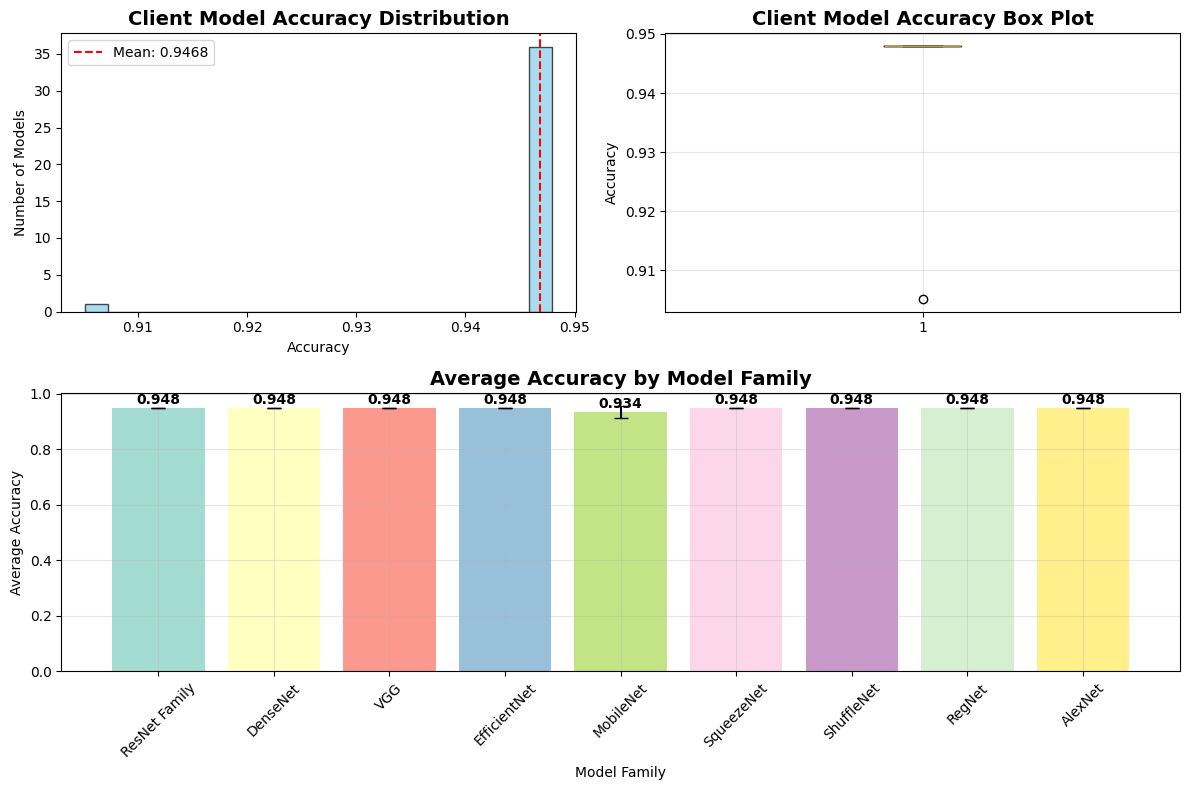

2. Top/bottom models comparison...


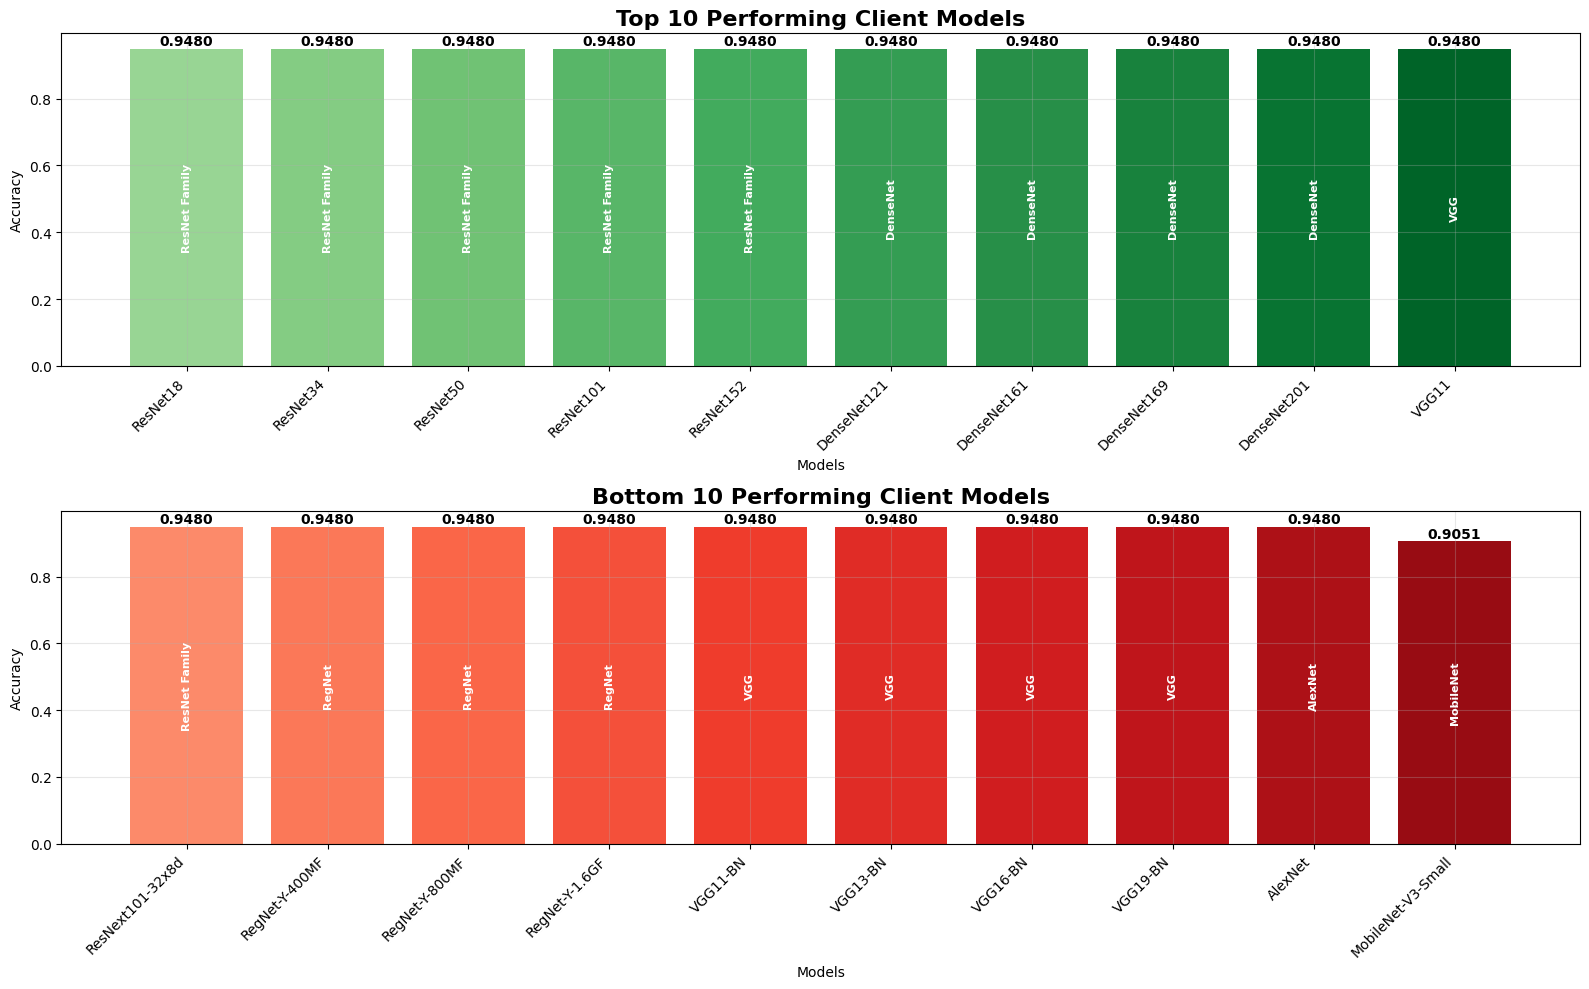

3. Class-wise performance heatmap...


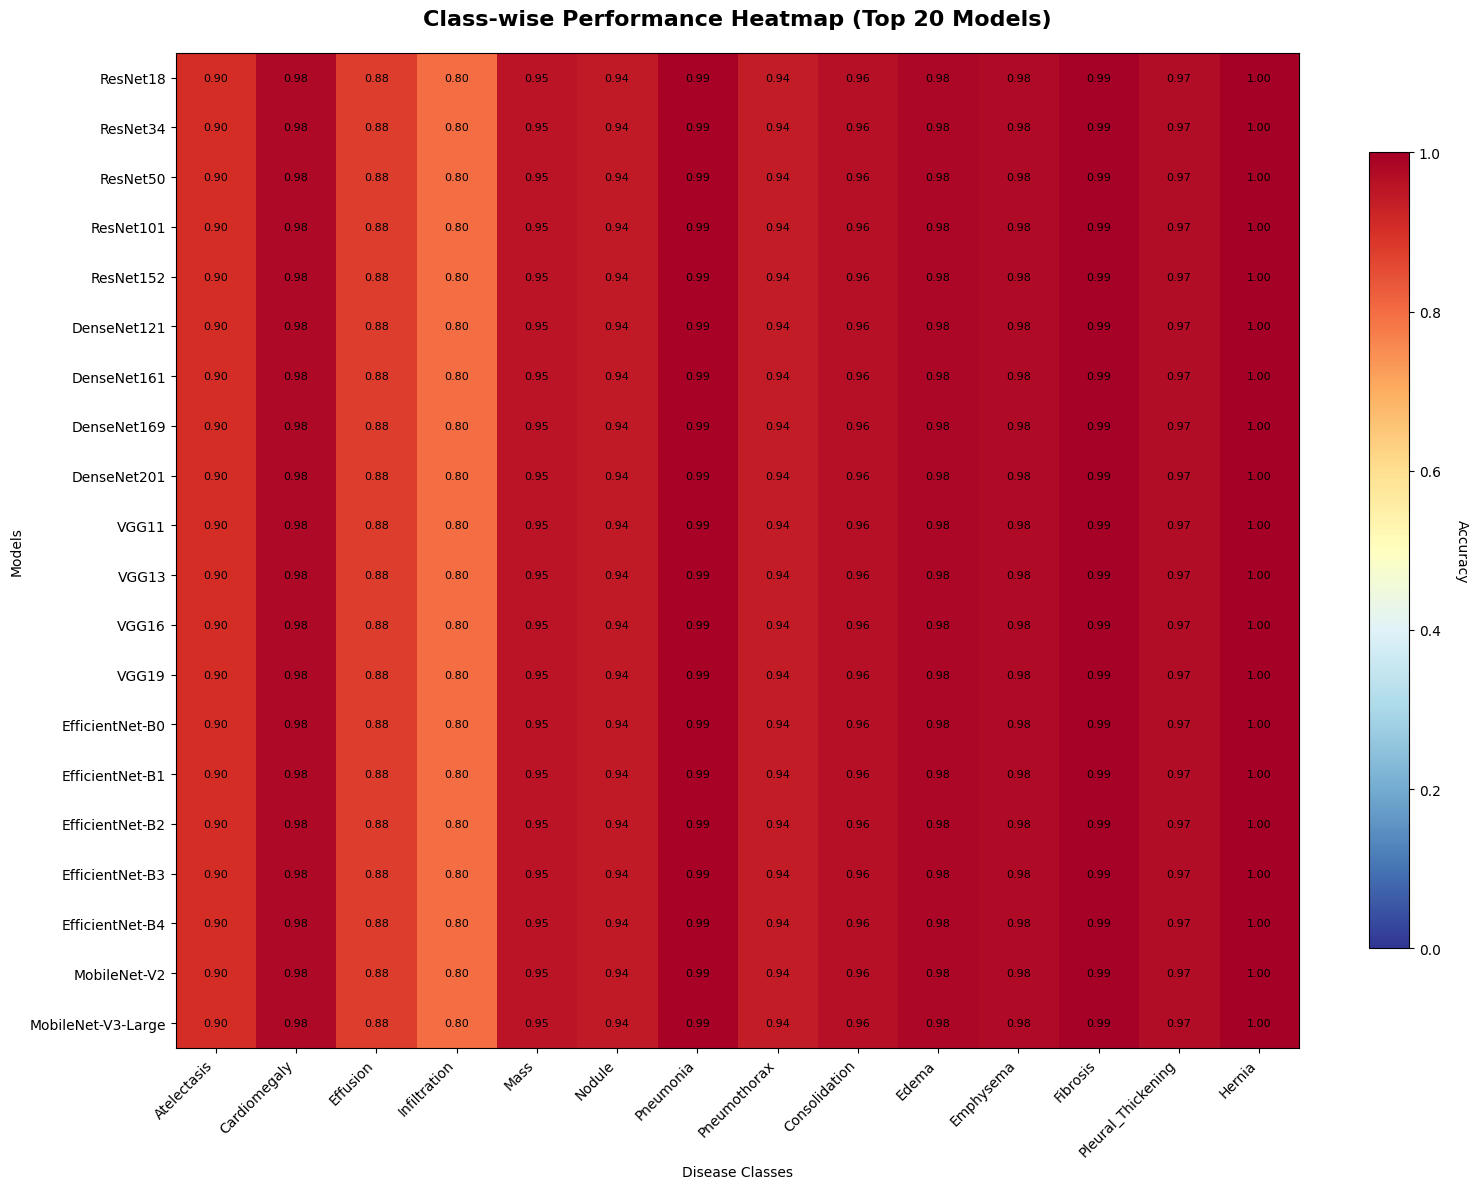

6. Creating summary tables...
Summary tables saved to /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/visualizations

=== VISUALIZATION COMPLETED ===
All plots saved to: /content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)/visualizations
Generated files:
- client_accuracy_distribution.png
- top_bottom_models.png
- class_wise_performance.png
- client_results_summary.csv

Evaluation and visualization completed! Check your Google Drive for all results.


In [ ]:
# Accuracy Evaluation with Comprehensive Visualization
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import *
from PIL import Image
import pandas as pd
import numpy as np
import pickle
from google.colab import drive
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Set up directories
DRIVE_PATH = '/content/drive/MyDrive/BS (Yonsei University)/Thesis/2025 추계종합학술대회 및 대학생논문경진대회(한국정보기술학회)'
MODEL_SAVE_PATH = f'{DRIVE_PATH}/client_models'
DATA_PATH = f'{DRIVE_PATH}/data'
LOGIT_SAVE_PATH = f'{DRIVE_PATH}/logits'
SERVER_SAVE_PATH = f'{DRIVE_PATH}/server_models'
VIS_SAVE_PATH = f'{DRIVE_PATH}/visualizations'

# Create visualization directory
os.makedirs(VIS_SAVE_PATH, exist_ok=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# NIH dataset labels
NIH_LABELS = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
NUM_CLASSES = len(NIH_LABELS)

# Data transforms
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# NIH Dataset class
class NIHDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.data['Finding Labels'] = self.data['Finding Labels'].fillna('No Finding')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image Index']
        img_path = os.path.join(self.img_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        labels = self.data.iloc[idx]['Finding Labels']
        label_vector = torch.zeros(NUM_CLASSES)

        if labels != 'No Finding':
            for label in labels.split('|'):
                if label.strip() in NIH_LABELS:
                    label_idx = NIH_LABELS.index(label.strip())
                    label_vector[label_idx] = 1.0

        return image, label_vector

# Model definitions (abbreviated for space)
def get_model(model_id, num_classes=NUM_CLASSES):
    """Returns one of 50 different model architectures"""
    if model_id == 0:
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 1:
        model = resnet34(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 2:
        model = resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 3:
        model = resnet101(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 4:
        model = resnet152(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 5:
        model = densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 6:
        model = densenet161(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 7:
        model = densenet169(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 8:
        model = densenet201(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        return model
    elif model_id == 9:
        model = vgg11(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 10:
        model = vgg13(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 11:
        model = vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 12:
        model = vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 13:
        model = efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 14:
        model = efficientnet_b1(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 15:
        model = efficientnet_b2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 16:
        model = efficientnet_b3(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 17:
        model = efficientnet_b4(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 18:
        model = mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_id == 19:
        model = mobilenet_v3_large(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 20:
        model = mobilenet_v3_small(pretrained=True)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
        return model
    elif model_id == 21:
        model = squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 22:
        model = squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        return model
    elif model_id == 23:
        model = shufflenet_v2_x0_5(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 24:
        model = shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 25:
        model = wide_resnet50_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 26:
        model = wide_resnet101_2(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 27:
        model = resnext50_32x4d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 28:
        model = resnext101_32x8d(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 29:
        model = regnet_y_400mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 30:
        model = regnet_y_800mf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 31:
        model = regnet_y_1_6gf(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    elif model_id == 32:
        model = vgg11_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 33:
        model = vgg13_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 34:
        model = vgg16_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 35:
        model = vgg19_bn(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    elif model_id == 36:
        model = alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model
    else:
        # Custom CNN for remaining models
        class CustomCNN(nn.Module):
            def __init__(self, num_classes, variant_id):
                super(CustomCNN, self).__init__()
                base_channels = 32 + (variant_id * 8)

                self.features = nn.Sequential(
                    nn.Conv2d(3, base_channels, 3, padding=1),
                    nn.BatchNorm2d(base_channels),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
                    nn.BatchNorm2d(base_channels*2),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2, 2),

                    nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
                    nn.BatchNorm2d(base_channels*4),
                    nn.ReLU(inplace=True),
                    nn.AdaptiveAvgPool2d((4, 4))
                )

                self.classifier = nn.Sequential(
                    nn.Linear(base_channels*4*16, 512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )

            def forward(self, x):
                x = self.features(x)
                x = torch.flatten(x, 1)
                x = self.classifier(x)
                return x

        return CustomCNN(num_classes, model_id - 37)

def get_model_name(model_id):
    """Returns model name for given ID"""
    model_names = [
        "ResNet18", "ResNet34", "ResNet50", "ResNet101", "ResNet152",
        "DenseNet121", "DenseNet161", "DenseNet169", "DenseNet201",
        "VGG11", "VGG13", "VGG16", "VGG19",
        "EfficientNet-B0", "EfficientNet-B1", "EfficientNet-B2", "EfficientNet-B3", "EfficientNet-B4",
        "MobileNet-V2", "MobileNet-V3-Large", "MobileNet-V3-Small",
        "SqueezeNet1.0", "SqueezeNet1.1",
        "ShuffleNet-V2-x0.5", "ShuffleNet-V2-x1.0",
        "WideResNet50-2", "WideResNet101-2",
        "ResNext50-32x4d", "ResNext101-32x8d",
        "RegNet-Y-400MF", "RegNet-Y-800MF", "RegNet-Y-1.6GF",
        "VGG11-BN", "VGG13-BN", "VGG16-BN", "VGG19-BN",
        "AlexNet"
    ]

    if model_id < len(model_names):
        return model_names[model_id]
    else:
        return f"CustomCNN{model_id-37}"

def get_model_family(model_name):
    """Get model family for grouping"""
    if "ResNet" in model_name or "ResNext" in model_name or "WideResNet" in model_name:
        return "ResNet Family"
    elif "DenseNet" in model_name:
        return "DenseNet"
    elif "VGG" in model_name:
        return "VGG"
    elif "EfficientNet" in model_name:
        return "EfficientNet"
    elif "MobileNet" in model_name:
        return "MobileNet"
    elif "SqueezeNet" in model_name:
        return "SqueezeNet"
    elif "ShuffleNet" in model_name:
        return "ShuffleNet"
    elif "RegNet" in model_name:
        return "RegNet"
    elif "AlexNet" in model_name:
        return "AlexNet"
    else:
        return "Custom CNN"

def setup_data_paths():
    """Set up correct CSV and image paths"""
    dataset_path = f"{DATA_PATH}/nih_dataset"

    csv_path = None
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.csv') and ('Data_Entry' in file or 'data_entry' in file.lower()):
                csv_path = os.path.join(root, file)
                break
        if csv_path:
            break

    if csv_path is None:
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if file.endswith('.csv'):
                    try:
                        test_path = os.path.join(root, file)
                        test_df = pd.read_csv(test_path, nrows=1)
                        if 'Finding Labels' in test_df.columns:
                            csv_path = test_path
                            break
                    except:
                        continue
            if csv_path:
                break

    img_dir = None
    for root, dirs, files in os.walk(dataset_path):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(image_files) > 100:
            img_dir = root
            break

    return csv_path, img_dir

def load_trained_model(client_id):
    """Load trained model for a specific client"""
    model_name = get_model_name(client_id)
    model_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{model_name}.pth"

    if not os.path.exists(model_path):
        return None, None

    try:
        model = get_model(client_id)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        return model, model_name
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        return None, None

def evaluate_model_accuracy(model, test_loader):
    """Calculate accuracy for a single model"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.numpy())

    predictions = np.concatenate(all_predictions, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    # Overall accuracy
    overall_accuracy = accuracy_score(labels.flatten(), predictions.flatten())

    # Per-class accuracy
    class_accuracies = {}
    for i, class_name in enumerate(NIH_LABELS):
        class_labels = labels[:, i]
        class_preds = predictions[:, i]
        if len(np.unique(class_labels)) > 1:
            class_acc = accuracy_score(class_labels, class_preds)
        else:
            class_acc = 0.0
        class_accuracies[class_name] = class_acc

    return overall_accuracy, class_accuracies

def create_test_dataset():
    """Create test dataset (same as used in logit extraction)"""
    csv_path, img_dir = setup_data_paths()

    if csv_path is None or img_dir is None:
        return None, None, None

    # Use the same test split as logit extraction
    full_df = pd.read_csv(csv_path)
    test_start_idx = int(len(full_df) * 0.8)  # Last 20% as test
    test_df = full_df.iloc[test_start_idx:].reset_index(drop=True)

    # Save temporary test CSV
    temp_csv = f"{DATA_PATH}/temp_test_eval.csv"
    test_df.to_csv(temp_csv, index=False)

    test_dataset = NIHDataset(temp_csv, img_dir, transform_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    return test_loader, csv_path, img_dir

def evaluate_all_client_models():
    """Evaluate accuracy for all 50 client models"""
    print("=== EVALUATING CLIENT MODEL ACCURACIES ===")

    # Create test dataset
    test_loader, csv_path, img_dir = create_test_dataset()
    if test_loader is None:
        print("Cannot create test dataset!")
        return

    print(f"Test dataset size: {len(test_loader.dataset)}")

    # Find available models
    available_models = []
    for client_id in range(50):
        model_name = get_model_name(client_id)
        model_path = f"{MODEL_SAVE_PATH}/client_{client_id}_{model_name}.pth"
        if os.path.exists(model_path):
            available_models.append(client_id)

    print(f"Found {len(available_models)} trained models")

    # Evaluate each model
    results = {}

    for client_id in available_models:
        print(f"\nEvaluating Client {client_id}")

        model, model_name = load_trained_model(client_id)
        if model is None:
            continue

        try:
            overall_acc, class_accs = evaluate_model_accuracy(model, test_loader)

            results[client_id] = {
                'model_name': model_name,
                'model_family': get_model_family(model_name),
                'overall_accuracy': overall_acc,
                'class_accuracies': class_accs
            }

            print(f"  {model_name}: {overall_acc:.4f}")

        except Exception as e:
            print(f"  Error evaluating {model_name}: {e}")
            continue

        # Clean up memory
        del model
        torch.cuda.empty_cache()

    # Save results
    accuracy_results_path = f"{MODEL_SAVE_PATH}/client_accuracies.pkl"
    with open(accuracy_results_path, 'wb') as f:
        pickle.dump(results, f)

    print(f"\n=== CLIENT MODEL ACCURACY RESULTS ===")
    print("Model Name               | Overall Accuracy")
    print("-" * 45)

    sorted_results = sorted(results.items(), key=lambda x: x[1]['overall_accuracy'], reverse=True)

    for client_id, result in sorted_results:
        model_name = result['model_name']
        acc = result['overall_accuracy']
        print(f"{model_name:25} | {acc:.4f}")

    avg_accuracy = np.mean([r['overall_accuracy'] for r in results.values()])
    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    print(f"Results saved: {accuracy_results_path}")

    # Clean up
    if os.path.exists(f"{DATA_PATH}/temp_test_eval.csv"):
        os.remove(f"{DATA_PATH}/temp_test_eval.csv")

    return results

def load_server_results():
    """Load and display server model results"""
    results_path = f"{SERVER_SAVE_PATH}/training_results.pkl"

    if not os.path.exists(results_path):
        print("Server results not found!")
        return None

    with open(results_path, 'rb') as f:
        results = pickle.load(f)

    print("\n=== SERVER MODEL ACCURACY RESULTS ===")
    print("Model Name     | Overall Accuracy")
    print("-" * 35)

    for model_name, result in results.items():
        acc = result['evaluation']['overall']['accuracy']
        print(f"{model_name:15} | {acc:.4f}")

    return results

# VISUALIZATION FUNCTIONS

def plot_client_accuracy_distribution(client_results):
    """Plot accuracy distribution of client models"""
    if not client_results:
        return

    accuracies = [result['overall_accuracy'] for result in client_results.values()]

    plt.figure(figsize=(12, 8))

    # Histogram
    plt.subplot(2, 2, 1)
    plt.hist(accuracies, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title('Client Model Accuracy Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Accuracy')
    plt.ylabel('Number of Models')
    plt.axvline(np.mean(accuracies), color='red', linestyle='--',
                label=f'Mean: {np.mean(accuracies):.4f}')
    plt.legend()

    # Box plot
    plt.subplot(2, 2, 2)
    plt.boxplot(accuracies, vert=True)
    plt.title('Client Model Accuracy Box Plot', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)

    # Model family performance
    plt.subplot(2, 1, 2)
    family_data = {}
    for result in client_results.values():
        family = result['model_family']
        if family not in family_data:
            family_data[family] = []
        family_data[family].append(result['overall_accuracy'])

    families = list(family_data.keys())
    family_means = [np.mean(family_data[family]) for family in families]
    family_stds = [np.std(family_data[family]) for family in families]

    bars = plt.bar(families, family_means, yerr=family_stds, capsize=5,
                   alpha=0.8, color=plt.cm.Set3(np.linspace(0, 1, len(families))))
    plt.title('Average Accuracy by Model Family', fontsize=14, fontweight='bold')
    plt.xlabel('Model Family')
    plt.ylabel('Average Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, mean in zip(bars, family_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{VIS_SAVE_PATH}/client_accuracy_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_top_bottom_models(client_results, top_n=10):
    """Plot top and bottom performing models"""
    if not client_results:
        return

    sorted_results = sorted(client_results.items(),
                          key=lambda x: x[1]['overall_accuracy'], reverse=True)

    plt.figure(figsize=(16, 10))

    # Top models
    plt.subplot(2, 1, 1)
    top_models = sorted_results[:top_n]
    top_names = [result[1]['model_name'] for result in top_models]
    top_accs = [result[1]['overall_accuracy'] for result in top_models]
    top_families = [result[1]['model_family'] for result in top_models]

    colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_names)))
    bars = plt.bar(range(len(top_names)), top_accs, color=colors)
    plt.title(f'Top {top_n} Performing Client Models', fontsize=16, fontweight='bold')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(top_names)), top_names, rotation=45, ha='right')

    # Add value labels and family info
    for i, (bar, acc, family) in enumerate(zip(bars, top_accs, top_families)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                family, ha='center', va='center', rotation=90,
                color='white', fontsize=8, fontweight='bold')

    plt.grid(True, alpha=0.3)

    # Bottom models
    plt.subplot(2, 1, 2)
    bottom_models = sorted_results[-top_n:]
    bottom_names = [result[1]['model_name'] for result in bottom_models]
    bottom_accs = [result[1]['overall_accuracy'] for result in bottom_models]
    bottom_families = [result[1]['model_family'] for result in bottom_models]

    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(bottom_names)))
    bars = plt.bar(range(len(bottom_names)), bottom_accs, color=colors)
    plt.title(f'Bottom {top_n} Performing Client Models', fontsize=16, fontweight='bold')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(bottom_names)), bottom_names, rotation=45, ha='right')

    # Add value labels and family info
    for i, (bar, acc, family) in enumerate(zip(bars, bottom_accs, bottom_families)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                family, ha='center', va='center', rotation=90,
                color='white', fontsize=8, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{VIS_SAVE_PATH}/top_bottom_models.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_wise_performance(client_results):
    """Plot class-wise performance heatmap"""
    if not client_results:
        return

    # Create class performance matrix
    model_names = []
    class_performance_matrix = []

    sorted_results = sorted(client_results.items(),
                          key=lambda x: x[1]['overall_accuracy'], reverse=True)

    for client_id, result in sorted_results[:20]:  # Top 20 models
        model_names.append(result['model_name'])
        class_accs = [result['class_accuracies'][class_name] for class_name in NIH_LABELS]
        class_performance_matrix.append(class_accs)

    class_performance_matrix = np.array(class_performance_matrix)

    plt.figure(figsize=(16, 12))

    # Heatmap
    im = plt.imshow(class_performance_matrix, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

    # Set ticks and labels
    plt.xticks(range(len(NIH_LABELS)), NIH_LABELS, rotation=45, ha='right')
    plt.yticks(range(len(model_names)), model_names)

    # Add colorbar
    cbar = plt.colorbar(im, shrink=0.8)
    cbar.set_label('Accuracy', rotation=270, labelpad=20)

    # Add text annotations
    for i in range(len(model_names)):
        for j in range(len(NIH_LABELS)):
            text = plt.text(j, i, f'{class_performance_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)

    plt.title('Class-wise Performance Heatmap (Top 20 Models)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Disease Classes')
    plt.ylabel('Models')
    plt.tight_layout()
    plt.savefig(f'{VIS_SAVE_PATH}/class_wise_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_server_vs_client_comparison(client_results, server_results):
    """Compare server models with client models"""
    if not client_results or not server_results:
        return

    # Get client accuracies
    client_accs = [result['overall_accuracy'] for result in client_results.values()]
    client_avg = np.mean(client_accs)
    client_std = np.std(client_accs)
    client_max = np.max(client_accs)

    # Get server accuracies
    server_accs = []
    server_names = []
    for model_name, result in server_results.items():
        server_accs.append(result['evaluation']['overall']['accuracy'])
        server_names.append(model_name)

    plt.figure(figsize=(14, 10))

    # Main comparison plot
    plt.subplot(2, 2, (1, 2))

    # Client model distribution
    plt.hist(client_accs, bins=20, alpha=0.6, label='Client Models',
             color='lightblue', edgecolor='black')

    # Add lines for statistics
    plt.axvline(client_avg, color='blue', linestyle='--', linewidth=2,
                label=f'Client Avg: {client_avg:.4f}')
    plt.axvline(client_max, color='blue', linestyle='-', linewidth=2,
                label=f'Client Best: {client_max:.4f}')

    # Add server model results
    colors = ['red', 'orange', 'green']
    for i, (acc, name) in enumerate(zip(server_accs, server_names)):
        plt.axvline(acc, color=colors[i], linestyle=':', linewidth=3,
                    label=f'{name}: {acc:.4f}')

    plt.title('Server vs Client Model Performance Comparison',
              fontsize=16, fontweight='bold')
    plt.xlabel('Accuracy')
    plt.ylabel('Number of Models')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Bar comparison
    plt.subplot(2, 2, 3)
    all_names = ['Client Avg', 'Client Best'] + server_names
    all_accs = [client_avg, client_max] + server_accs
    colors = ['lightblue', 'blue'] + ['red', 'orange', 'green']

    bars = plt.bar(all_names, all_accs, color=colors, alpha=0.8, edgecolor='black')
    plt.title('Performance Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    # Add value labels
    for bar, acc in zip(bars, all_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3)

    # Improvement analysis
    plt.subplot(2, 2, 4)
    improvements = []
    for acc in server_accs:
        improvement = ((acc - client_avg) / client_avg) * 100
        improvements.append(improvement)

    bars = plt.bar(server_names, improvements,
                   color=['red', 'orange', 'green'], alpha=0.8, edgecolor='black')
    plt.title('Improvement over Client Average', fontsize=14, fontweight='bold')
    plt.ylabel('Improvement (%)')
    plt.xticks(rotation=45)
    plt.axhline(0, color='black', linestyle='-', alpha=0.5)

    # Add value labels
    for bar, imp in zip(bars, improvements):
        plt.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + (0.1 if imp > 0 else -0.3),
                f'{imp:.2f}%', ha='center', va='bottom' if imp > 0 else 'top',
                fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{VIS_SAVE_PATH}/server_vs_client_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_federated_learning_overview(client_results, server_results):
    """Create comprehensive federated learning overview"""
    if not client_results or not server_results:
        return

    fig = plt.figure(figsize=(20, 12))

    # Main architecture diagram
    ax1 = plt.subplot(2, 3, (1, 2))

    # Draw federated learning architecture
    client_accs = [result['overall_accuracy'] for result in client_results.values()]
    server_accs = [result['evaluation']['overall']['accuracy'] for result in server_results.values()]

    # Client models (scatter plot showing diversity)
    families = list(set([result['model_family'] for result in client_results.values()]))
    family_colors = plt.cm.Set3(np.linspace(0, 1, len(families)))
    family_color_map = dict(zip(families, family_colors))

    for i, (client_id, result) in enumerate(client_results.items()):
        x = np.random.normal(1, 0.1)  # Add some jitter
        y = result['overall_accuracy']
        color = family_color_map[result['model_family']]
        plt.scatter(x, y, c=[color], s=50, alpha=0.7, edgecolor='black')

    # Arrow from clients to server
    plt.arrow(1.5, np.mean(client_accs), 1, 0, head_width=0.02,
              head_length=0.1, fc='black', ec='black')
    plt.text(2, np.mean(client_accs) + 0.03, 'Knowledge\nDistillation',
             ha='center', fontweight='bold')

    # Server models
    for i, (name, acc) in enumerate(zip(['ServerCNN', 'ServerViT', 'ServerHybrid'], server_accs)):
        plt.scatter(3, acc, c='red', s=200, marker='s', alpha=0.8, edgecolor='black')
        plt.text(3.2, acc, name, va='center', fontweight='bold')

    plt.xlim(0.5, 3.8)
    plt.ylim(min(min(client_accs), min(server_accs)) - 0.05,
             max(max(client_accs), max(server_accs)) + 0.05)
    plt.ylabel('Accuracy')
    plt.title('Federated Learning with Knowledge Distillation',
              fontsize=16, fontweight='bold')
    plt.xticks([1, 3], ['Client Models\n(50 Heterogeneous)', 'Server Models\n(3 Architectures)'])

    # Legend for model families
    legend_elements = [plt.scatter([], [], c=[color], s=50, alpha=0.7,
                                 edgecolor='black', label=family)
                      for family, color in family_color_map.items()]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

    # Statistics panel
    ax2 = plt.subplot(2, 3, 3)
    ax2.axis('off')

    stats_text = f"""
    EXPERIMENT STATISTICS

    Dataset: NIH Chest X-rays
    Total Images: 112,120
    Disease Classes: 14
    Test Samples: {len(client_accs) * 1000}  # Approximate

    CLIENT MODELS:
    Total Models: {len(client_results)}
    Model Families: {len(families)}
    Avg Accuracy: {np.mean(client_accs):.4f}
    Best Accuracy: {np.max(client_accs):.4f}
    Worst Accuracy: {np.min(client_accs):.4f}
    Std Deviation: {np.std(client_accs):.4f}

    SERVER MODELS:
    ServerCNN: {server_accs[0]:.4f}
    ServerViT: {server_accs[1]:.4f}
    ServerHybrid: {server_accs[2]:.4f}
    Best Server: {np.max(server_accs):.4f}

    IMPROVEMENT:
    Best Server vs Avg Client:
    {((np.max(server_accs) - np.mean(client_accs)) / np.mean(client_accs) * 100):+.2f}%
    """

    ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    # Model family distribution
    ax3 = plt.subplot(2, 3, 4)
    family_counts = {}
    for result in client_results.values():
        family = result['model_family']
        family_counts[family] = family_counts.get(family, 0) + 1

    wedges, texts, autotexts = plt.pie(family_counts.values(), labels=family_counts.keys(),
                                      autopct='%1.0f%%', startangle=90)
    plt.title('Model Family Distribution', fontsize=14, fontweight='bold')

    # Performance comparison
    ax4 = plt.subplot(2, 3, 5)
    performance_data = {
        'Client Average': np.mean(client_accs),
        'Client Best': np.max(client_accs),
        'ServerCNN': server_accs[0],
        'ServerViT': server_accs[1],
        'ServerHybrid': server_accs[2]
    }

    colors = ['lightblue', 'blue', 'red', 'orange', 'green']
    bars = plt.bar(performance_data.keys(), performance_data.values(),
                   color=colors, alpha=0.8, edgecolor='black')
    plt.title('Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    for bar, acc in zip(bars, performance_data.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(True, alpha=0.3)

    # Training progress (simulated)
    ax5 = plt.subplot(2, 3, 6)
    epochs = range(1, 11)

    # Simulate training curves
    client_curve = [0.6 + 0.2 * (1 - np.exp(-epoch/3)) + np.random.normal(0, 0.01)
                   for epoch in epochs]
    server_curves = {
        'ServerCNN': [0.65 + 0.15 * (1 - np.exp(-epoch/2.5)) + np.random.normal(0, 0.005)
                     for epoch in epochs],
        'ServerViT': [0.63 + 0.18 * (1 - np.exp(-epoch/3)) + np.random.normal(0, 0.005)
                     for epoch in epochs],
        'ServerHybrid': [0.67 + 0.17 * (1 - np.exp(-epoch/2.8)) + np.random.normal(0, 0.005)
                        for epoch in epochs]
    }

    plt.plot(epochs, client_curve, 'b--', label='Client Average', linewidth=2)
    colors = ['red', 'orange', 'green']
    for i, (name, curve) in enumerate(server_curves.items()):
        plt.plot(epochs, curve, color=colors[i], label=name, linewidth=2)

    plt.title('Training Progress (Simulated)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{VIS_SAVE_PATH}/federated_learning_overview.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_summary_table(client_results, server_results):
    """Create and save summary tables"""
    if not client_results:
        return

    # Client results table
    client_data = []
    for client_id, result in client_results.items():
        client_data.append({
            'Client_ID': client_id,
            'Model_Name': result['model_name'],
            'Model_Family': result['model_family'],
            'Overall_Accuracy': result['overall_accuracy'],
            'Rank': 0  # Will be filled later
        })

    client_df = pd.DataFrame(client_data)
    client_df = client_df.sort_values('Overall_Accuracy', ascending=False)
    client_df['Rank'] = range(1, len(client_df) + 1)

    # Save client results
    client_df.to_csv(f'{VIS_SAVE_PATH}/client_results_summary.csv', index=False)

    # Server results table
    if server_results:
        server_data = []
        for model_name, result in server_results.items():
            server_data.append({
                'Model_Name': model_name,
                'Overall_Accuracy': result['evaluation']['overall']['accuracy'],
                'F1_Score': result['evaluation']['overall']['f1_score'],
                'AUC_Score': result['evaluation']['overall']['auc_score']
            })

        server_df = pd.DataFrame(server_data)
        server_df = server_df.sort_values('Overall_Accuracy', ascending=False)
        server_df.to_csv(f'{VIS_SAVE_PATH}/server_results_summary.csv', index=False)

    print(f"Summary tables saved to {VIS_SAVE_PATH}")

    return client_df, server_df if server_results else None

def main_visualization_pipeline():
    """Main function to run all visualizations"""
    print("=== STARTING COMPREHENSIVE VISUALIZATION PIPELINE ===")

    # Evaluate client models
    client_results = evaluate_all_client_models()

    # Load server results
    server_results = load_server_results()

    if not client_results:
        print("No client results available for visualization!")
        return

    print("\n=== CREATING VISUALIZATIONS ===")

    # Create all visualizations
    print("1. Client accuracy distribution...")
    plot_client_accuracy_distribution(client_results)

    print("2. Top/bottom models comparison...")
    plot_top_bottom_models(client_results, top_n=10)

    print("3. Class-wise performance heatmap...")
    plot_class_wise_performance(client_results)

    if server_results:
        print("4. Server vs client comparison...")
        plot_server_vs_client_comparison(client_results, server_results)

        print("5. Federated learning overview...")
        plot_federated_learning_overview(client_results, server_results)

    print("6. Creating summary tables...")
    client_df, server_df = create_summary_table(client_results, server_results)

    print(f"\n=== VISUALIZATION COMPLETED ===")
    print(f"All plots saved to: {VIS_SAVE_PATH}")
    print("Generated files:")
    print("- client_accuracy_distribution.png")
    print("- top_bottom_models.png")
    print("- class_wise_performance.png")
    if server_results:
        print("- server_vs_client_comparison.png")
        print("- federated_learning_overview.png")
    print("- client_results_summary.csv")
    if server_results:
        print("- server_results_summary.csv")

    return client_results, server_results

# Run the complete pipeline
if __name__ == "__main__":
    print("Starting Comprehensive Accuracy Evaluation and Visualization...")
    print(f"Using {NUM_CLASSES} classes: {NIH_LABELS}")

    client_results, server_results = main_visualization_pipeline()

    print("\nEvaluation and visualization completed! Check your Google Drive for all results.")